# 5.经济可行性计算

数据输出：

这里我需要得到一个df，里面含有：

1、光伏策略：

均值df：各撂荒单元RCP情景平均的光伏NPV、发电量×价格的收入、成本（运营+一次性开支），3 * 4个column
模型df：各撂荒单元分模型、分RCP的光伏NPV、

2、


# 5.1 光伏策略经济净收益

## 5.1.1 光伏电力净收益


df_AR6 = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_R10_regions_v1.1.csv')
df_world = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_World_v1.1.csv')
df_dict = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_metadata_indicators_v1.1.csv')


select 'Region' in df_AR6 where is 'R10NORTH_AM' (因为这里代表了美国的水平)

我们需要根据df_dict='D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_metadata_indicators_v1.1.csv'建立一个映射表来分类'Model'、'Scenario'，并将这个关系运用到df_AR6

主要类型是RCP2.6, RCP4.5, RCP6.0, RCP8.5几个主要类型，仅在df_dict中有'Category'列：

if 'Scenario' 的 'Category' == 'C3''C2''C1', 则 'Scenario' 归类为RCP2.6
if 'Scenario' 的 'Category' == 'C4', 则 'Scenario' 归类为RCP4.5
if 'Scenario' 的 'Category' == 'C5', 则 'Scenario' 归类为RCP6.0
if 'Scenario' 的 'Category' == 'C6''C7', 则 'Scenario' 归类为RCP8.5


Second, 在各个RCP情景分组之中，需要使用不同模型column == '2020''2030''2040''2050'的数据来计算单模型净收益，并利用不同模型的各年份平均值计算平均净收益。

for each point in record in df_data, use 'Variable' where has the key word 'Capital Cost|Electricity|Solar|PV' and 'OM Cost|Fixed|Electricity|Solar|PV' and add their 'unit'

单个栅格净收益 = average 'Price|Secondary Energy|Electricity' （单位是US$2010/GJ）in '2020''2030''2040''2050' * 栅格发电量（这里单位是kw） - average 'OM Cost|Fixed|Electricity|Solar|PV' （单位是US$2010/kW/yr）in '2020''2030''2040''2050' * 30 年  - average 'Capital Cost|Electricity|Solar|PV'（US$2010/kW/yr
） in '2020''2030''2040''2050' * 装机容量

装机容量= df_data['area_m2']*0.86*0.17 （这里单位是kw）
栅格发电量=df_data['E_yr_pixel']*0.86 （这里单位是kwh）

贴现率为5%，计算净现值

third, 数据输出数量：'Model'的数量*'Scenario'RCP情景的组数（一般是四组）*时间点（2020，2030，2040，2050）+ 四组RCP情景各自的平均净收益

lastly,选择一个合适的图表，能够绘制四个情景中不同模型的NPV随着时间累积变化曲线，并且四组RCP情景各自的平均净收益

In [1]:
import pandas as pd

df_AR6 = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_R10_regions_v1.1.csv')
# df_world = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_World_v1.1.csv')
# df_dict = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_metadata_indicators_v1.1.csv')
# df_data = pd.read_csv(r'data\4.data_prediction_net_benefit.csv')

# 区域条件
target_region = 'R10NORTH_AM'

print(f"1.3 分析{target_region}区域数据可用性...")

# 筛选指定区域数据
df_AR6_region = df_AR6[df_AR6['Region'] == target_region].copy()

# 提取AR6数据中两个变量
variables_of_interest = [
    'Price|Electricity|Residential'
]

# 过滤出包含这两个变量且属于指定区域（加上区域条件）的数据
df_selected = df_AR6[(df_AR6['Variable'].isin(variables_of_interest)) & (df_AR6['Region'] == target_region)]



1.3 分析R10NORTH_AM区域数据可用性...


In [2]:

def load_and_prepare_data():
    """加载并预处理所有数据"""
    
    print("1.1 加载原始数据...")
    # 加载AR6数据
    df_AR6 = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_R10_regions_v1.1.csv')
    df_world = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_World_v1.1.csv')
    df_dict = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_metadata_indicators_v1.1.csv')
    df_data = pd.read_csv(r'data\4.data_prediction_net_benefit.csv')
    
    return df_AR6, df_dict, df_data


df_AR6, df_dict, df_data = load_and_prepare_data()



1.1 加载原始数据...


In [3]:
df_data

lat        lon        time  abandonment_year  \
0      21.895834 -159.47084  2020-01-01            2013.0   
1      21.904167 -159.57916  2020-01-01            2014.0   
2      21.904167 -159.52083  2020-01-01            2011.0   
3      21.904167 -159.46250  2020-01-01            2010.0   
4      21.912500 -159.52083  2020-01-01            2010.0   
...          ...        ...         ...               ...   
71765  63.912500 -145.21250  2020-01-01            2009.0   
71766  64.012500 -145.00417  2020-01-01            2010.0   
71767  64.029170 -145.11250  2020-01-01            2018.0   
71768  64.129166 -145.66250  2020-01-01            1998.0   
71769  64.829170 -147.57916  2020-01-01            1995.0   

       abandonment_duration  current_abandonment  landcover       DEM  \
0                      10.0                    1        2.0   51.2500   
1                       9.0                    1        2.0   32.7500   
2                      12.0                    1        2.0  138.5000   
3                      13.0                    1        4.0   67.6875   
4                      13.0                    1        2.0  204.3750   
...                     ...                  ...        ...       ...   
71765                  14.0                    1        2.0  359.8125   
71766                  13.0                    1        2.0  335.2500   
71767                   5.0                    1        2.0  331.8750   
71768                  25.0                    1        2.0  317.8125   
71769                  28.0                    1        3.0  136.8125   

             gdmp    GDPpc  ...      wind           I    T_amb_C     T_cell  \
0      117.119888  41938.0  ...  4.574830  237.483079  24.414581  26.982136   
1       37.481422  41938.0  ...  4.228809  236.208657  24.738989  27.781089   
2      160.905777  41938.0  ...  4.864865  238.982755  24.004069  26.193840   
3      144.940460  41938.0  ...  4.176537  236.644259  24.307778  27.466525   
4      173.481995  41938.0  ...  4.685113  237.547002  23.639143  26.084175   
...           ...      ...  ...       ...         ...        ...        ...   
71765   64.978180  51983.0  ...  4.148036  109.629514   0.949859   1.927143   
71766   64.978180  51983.0  ...  3.614530  108.059745   0.849859   2.604088   
71767   64.978180  51983.0  ...  3.510094  108.043831   0.883333   2.794787   
71768   64.978180  51983.0  ...  3.456614  107.980637   1.033057   3.015925   
71769   64.978180  64142.0  ...  2.069838  107.087442   1.741803   5.778256   

             PR     PVPOT        area_m2  E_yr_per_m2    E_yr_pixel  \
0      0.990089  0.235129  796687.511978   280.123834  2.231712e+08   
1      0.986095  0.232924  796640.934353   277.496422  2.210650e+08   
2      0.994031  0.237556  796640.934353   283.014977  2.254613e+08   
3      0.987667  0.233726  796640.934353   278.451586  2.218259e+08   
4      0.994579  0.236259  796594.339876   281.469868  2.242173e+08   
...         ...       ...            ...          ...           ...   
71765  1.115364  0.122277  377574.930382   145.675741  5.500351e+07   
71766  1.111980  0.120160  376228.441637   143.154090  5.385864e+07   
71767  1.111026  0.120040  376003.870405   143.010274  5.377242e+07   
71768  1.109920  0.119850  374656.098890   142.784387  5.349504e+07   
71769  1.096109  0.117379  365189.541673   139.841216  5.106855e+07   

       carbon_emission (t)/yr  
0                78556.248361  
1                77814.883004  
2                79362.382992  
3                78082.727862  
4                78924.490890  
...                       ...  
71765            19361.234748  
71766            18958.241287  
71767            18927.890584  
71768            18830.254615  
71769            17976.129481  

[71770 rows x 31 columns]

In [4]:
print([v for v in df_AR6['Variable'].unique() if 'Price' in v])

['Price|Agriculture|Corn|Index', 'Price|Agriculture|Non-Energy Crops and Livestock|Index', 'Price|Agriculture|Non-Energy Crops|Index', 'Price|Agriculture|Soybean|Index', 'Price|Agriculture|Wheat|Index', 'Price|Primary Energy|Biomass', 'Price|Primary Energy|Coal', 'Price|Primary Energy|Gas', 'Price|Primary Energy|Oil', 'Price|Secondary Energy|Electricity', 'Price|Secondary Energy|Liquids', 'Price|Secondary Energy|Liquids|Biomass', 'Price|Carbon', 'Price|Final Energy|Residential and Commercial|Residential|Electricity', 'Price|Final Energy|Transportation|Hydrogen', 'Price|Final Energy|Transportation|Liquids', 'Price|Secondary Energy|Gases|Natural Gas', 'Price|Secondary Energy|Hydrogen', 'Price|Secondary Energy|Liquids|Oil', 'Price|Final Energy|Transportation|Electricity', 'Price|Final Energy|Transportation|Gases', 'Price|Final Energy|Residential and Commercial|Residential|Solids|Biomass', 'Price|Final Energy|Residential and Commercial|Residential|Solids|Coal', 'Price|Secondary Energy|Soli

In [5]:
# 进一步关注这个mask下，他们有没有以上变量（variables_of_interest）：
mask = (
    (df_AR6['Region'] == 'R10NORTH_AM') &
    (df_AR6['Variable'] == 'Price|Final Energy|Residential and Commercial|Residential|Electricity')
)
years = ['2020', '2030', '2040', '2050']
df_var = df_AR6.loc[mask, ['Model', 'Scenario', 'Variable', 'Unit'] + years].copy()

# 检查这些数据中是否有 variables_of_interest 里的变量
variables_of_interest = [
    'Capital Cost|Electricity|Solar|PV',
    'OM Cost|Fixed|Electricity|Solar|PV',
    'Price|Secondary Energy|Electricity'
]


present_vars = set(df_var['Variable'].unique())
for v in variables_of_interest:
    if v in present_vars:
        print(f"变量 {v} 存在于该区域和条件下。")
    else:
        print(f"变量 {v} 不存在于该区域和条件下。")

# 将年份列转换为数值型
for y in years:
    df_var[y] = pd.to_numeric(df_var[y], errors='coerce')

# 计算均值和标准差
df_var['mean'] = df_var[years].mean(axis=1)
df_var['std'] = df_var[years].std(axis=1)

# 打印结果，带上单位
for idx, row in df_var.iterrows():
    print(f"Model: {row['Model']}, Scenario: {row['Scenario']}, Variable: {row['Variable']}, Mean: {row['mean']:.3f}, Std: {row['std']:.3f}, Unit: {row['Unit']}")

变量 Capital Cost|Electricity|Solar|PV 不存在于该区域和条件下。
变量 OM Cost|Fixed|Electricity|Solar|PV 不存在于该区域和条件下。
变量 Price|Secondary Energy|Electricity 不存在于该区域和条件下。
Model: GCAM 5.3, Scenario: NGFS2_Below 2°C, Variable: Price|Final Energy|Residential and Commercial|Residential|Electricity, Mean: 38.051, Std: 2.762, Unit: US$2010/GJ
Model: GCAM 5.3, Scenario: NGFS2_Current Policies, Variable: Price|Final Energy|Residential and Commercial|Residential|Electricity, Mean: 33.047, Std: 1.289, Unit: US$2010/GJ
Model: GCAM 5.3, Scenario: NGFS2_Delayed Transition, Variable: Price|Final Energy|Residential and Commercial|Residential|Electricity, Mean: 37.435, Std: 3.876, Unit: US$2010/GJ
Model: GCAM 5.3, Scenario: NGFS2_Divergent Net Zero Policies, Variable: Price|Final Energy|Residential and Commercial|Residential|Electricity, Mean: 41.169, Std: 4.462, Unit: US$2010/GJ
Model: GCAM 5.3, Scenario: NGFS2_Nationally Determined Contributions (NDCs), Variable: Price|Final Energy|Residential and Commercial|Residenti

#### 1、数据预处理模块

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy.stats import gaussian_kde
from matplotlib.pyplot import rcParams

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']  
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# 全局参数设置
DISCOUNT_RATE = 0.05  # 5%
PROJECT_LIFETIME = 30  # 30年
PROJECT_START_YEAR = 2020  # 项目开始年份
TARGET_YEARS = ['2020', '2030', '2040', '2050']
INTERPOLATION_YEARS = list(range(2020, 2051))  # 2020-2050年逐年数据

# 价格调整参数：2010年美元 -> 2020年美元
INFLATION_ADJUSTMENT_2010_TO_2020 = 1.2 

def adjust_price_to_2020_usd(price_2010_usd):
    """将2010年美元调整为2020年美元购买力"""
    if pd.isna(price_2010_usd):
        return price_2010_usd
    return price_2010_usd * INFLATION_ADJUSTMENT_2010_TO_2020

def load_and_prepare_data():
    """加载并预处理所有数据"""
    
    print("1.1 加载原始数据...")
    # 加载AR6数据
    df_AR6 = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_R10_regions_v1.1.csv')
    df_world = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_World_v1.1.csv')
    df_dict = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_metadata_indicators_v1.1.csv')
    df_data = pd.read_csv(r'data\4.data_prediction_net_benefit.csv')
    
    return df_AR6, df_dict, df_data

def create_common_scenarios_mapping(df_r10, df_indicators):
    """创建跨所有区域的公共情景映射（采用6.4逻辑）"""
    
    print("1.2 创建跨区域公共情景映射...")
    
    # 获取所有区域
    unique_regions = df_r10['Region'].unique()
    print(f"   总区域数: {len(unique_regions)}")
    
    # 获取指标数据库中的情景
    indicator_scenarios = set(df_indicators['Model'].astype(str) + '_' + df_indicators['Scenario'].astype(str))
    print(f"   指标数据库情景数: {len(indicator_scenarios)}")
    
    # 找到所有区域的公共情景
    scenarios_by_region = {}
    for region in unique_regions:
        df_region = df_r10[df_r10['Region'] == region]
        scenarios_region = set(df_region['Model'].astype(str) + '_' + df_region['Scenario'].astype(str))
        scenarios_by_region[region] = scenarios_region
    
    # 求所有区域的交集
    common_scenarios = set.intersection(*scenarios_by_region.values(), indicator_scenarios)
    print(f"   跨区域公共情景数: {len(common_scenarios)}")
    
    # 创建情景到类别和政策类别的映射
    scenario_categories = {}
    scenario_policy_categories = {}
    for _, row in df_indicators.iterrows():
        scenario_id = str(row['Model']) + '_' + str(row['Scenario'])
        if scenario_id in common_scenarios:
            scenario_categories[scenario_id] = row['Category']
            scenario_policy_categories[scenario_id] = {
                'Category': row['Category'],
                'Policy_category': row['Policy_category']
            }
    
    print(f"   成功映射的情景数: {len(scenario_categories)}")
    
    # 统计各类别数量
    category_counts = {}
    for category in scenario_categories.values():
        category_counts[category] = category_counts.get(category, 0) + 1
    
    print("   各类别情景数:")
    for category, count in sorted(category_counts.items()):
        print(f"     {category}: {count} 个情景")
    
    return common_scenarios, scenario_categories, scenario_policy_categories

 
def analyze_data_availability_for_region(df_AR6, common_scenarios, scenario_categories, scenario_policy_categories, target_region='R10NORTH_AM'):
    """分析指定区域的数据可用性（包含政策类别映射）- 更新为4个变量"""
    
    print(f"1.3 分析{target_region}区域数据可用性...")
    
    # 筛选指定区域数据
    df_AR6_region = df_AR6[df_AR6['Region'] == target_region].copy()
    print(f"   {target_region}区域数据: {len(df_AR6_region)} 行")
    
    # 定义目标变量 - 更新为4个变量
    target_variables = {
        'capital_cost': 'Capital Cost|Electricity|Solar|PV',
        'om_fixed_cost': 'OM Cost|Fixed|Electricity|Solar|PV', 
        'electricity_price': 'Price|Secondary Energy|Electricity',
        'electricity_demand': 'Price|Final Energy|Residential and Commercial|Residential|Electricity'
    }
    
    # 筛选目标变量和公共情景
    mask_variables = df_AR6_region['Variable'].isin(target_variables.values())
    mask_scenarios = df_AR6_region['Model'].astype(str) + '_' + df_AR6_region['Scenario'].astype(str)
    mask_scenarios = mask_scenarios.isin(common_scenarios)
    df_filtered = df_AR6_region[mask_variables & mask_scenarios]
    
    print(f"\n   筛选后数据: {len(df_filtered)} 行")
    
    # 检查筛选后的数据中每个变量的数量
    print(f"\n   筛选后各变量数量:")
    for var_name, var_full_name in target_variables.items():
        var_count = df_filtered[df_filtered['Variable'] == var_full_name].shape[0]
        print(f"     {var_name}: {var_count} 行")
    
    # 转换年份列为数值
    for year in TARGET_YEARS:
        if year in df_filtered.columns:
            df_filtered[year] = pd.to_numeric(df_filtered[year], errors='coerce')
    
    # 分析每个情景的数据可用性
    qualifying_scenarios = []
    required_year_count = len(TARGET_YEARS)  # 必须所有年份都有数据
    
    print("1.4 分析各情景数据完整性...")
    
    for model_scenario in df_filtered.groupby(['Model', 'Scenario']):
        model, scenario = model_scenario[0]
        scenario_id = f"{model}_{scenario}"
        scenario_data = model_scenario[1]
        
        # 跳过不在类别映射中的情景
        if scenario_id not in scenario_categories:
            continue
        
        var_completeness = {}
        
        # 检查每个变量的完整性
        for var_name, var_full_name in target_variables.items():
            var_data = scenario_data[scenario_data['Variable'] == var_full_name]
            
            if len(var_data) == 0:
                var_completeness[var_name] = 0
                continue
            
            valid_years = 0
            for year in TARGET_YEARS:
                if year in var_data.columns:
                    value = var_data[year].iloc[0]
                    if not pd.isna(value):
                        valid_years += 1
            
            var_completeness[var_name] = valid_years
        
        # 检查是否符合筛选条件 - 更新为4个变量
        capital_complete = var_completeness.get('capital_cost', 0) == required_year_count
        om_complete = var_completeness.get('om_fixed_cost', 0) == required_year_count
        electricity_price_complete = var_completeness.get('electricity_price', 0) == required_year_count
        electricity_demand_complete = var_completeness.get('electricity_demand', 0) == required_year_count
        
        # 条件1：四个变量都完整
        all_complete = (capital_complete and om_complete and 
                       electricity_price_complete and electricity_demand_complete)
        
        # 条件2：仅om_fixed_cost缺失，其他三个完整
        om_missing_only = (capital_complete and electricity_price_complete and 
                          electricity_demand_complete and not om_complete)
        
        # 条件3：仅electricity_demand缺失，其他三个完整
        demand_missing_only = (capital_complete and om_complete and 
                             electricity_price_complete and not electricity_demand_complete)
        
        # 条件4：om_fixed_cost和electricity_demand都缺失，其他两个完整
        om_and_demand_missing = (capital_complete and electricity_price_complete and 
                               not om_complete and not electricity_demand_complete)
        
        if any([all_complete, om_missing_only, demand_missing_only, om_and_demand_missing]):
            # 获取政策类别信息
            policy_info = scenario_policy_categories.get(scenario_id, {})
            
            # 确定模式
            if all_complete:
                pattern = 'all_complete'
            elif om_missing_only:
                pattern = 'om_missing'
            elif demand_missing_only:
                pattern = 'demand_missing'
            elif om_and_demand_missing:
                pattern = 'om_and_demand_missing'
            else:
                pattern = 'other'
            
            scenario_info = {
                'Region': target_region,
                'Category': scenario_categories[scenario_id],
                'Policy_category': policy_info.get('Policy_category', 'Unknown'), 
                'Model': model,
                'Scenario': scenario,
                'Model_Scenario': scenario_id,
                'has_capital_cost': capital_complete,
                'has_om_fixed_cost': om_complete,
                'has_electricity_price': electricity_price_complete,
                'has_electricity_demand': electricity_demand_complete,
                'available_variables': [var for var, complete in 
                                      [('capital_cost', capital_complete),
                                       ('om_fixed_cost', om_complete),
                                       ('electricity_price', electricity_price_complete),
                                       ('electricity_demand', electricity_demand_complete)]
                                      if complete],
                'variable_count': sum([capital_complete, om_complete, 
                                     electricity_price_complete, electricity_demand_complete]),
                'is_usable': True,
                'pattern': pattern
            }
            qualifying_scenarios.append(scenario_info)
    
    df_availability = pd.DataFrame(qualifying_scenarios)
    
    # 输出统计信息（包含政策类别）
    print(f"   符合条件的情景: {len(df_availability)}")
    print(f"   唯一Model-Scenario组合: {df_availability['Model_Scenario'].nunique()}")
    
    if len(df_availability) > 0:
        print(f"\n   按模式分类:")
        pattern_counts = df_availability['pattern'].value_counts()
        for pattern, count in pattern_counts.items():
            print(f"     {pattern}: {count} 个")
        
        print(f"\n   按Category分类:")
        category_counts = df_availability['Category'].value_counts()
        for category, count in category_counts.items():
            print(f"     {category}: {count} 个")
        
        print(f"\n   按Policy_category分类:")
        policy_counts = df_availability['Policy_category'].value_counts()
        for policy, count in policy_counts.items():
            print(f"     {policy}: {count} 个")
        
        print(f"\n   变量完整性统计:")
        print(f"     capital_cost: {df_availability['has_capital_cost'].sum()}/{len(df_availability)} 完整")
        print(f"     om_fixed_cost: {df_availability['has_om_fixed_cost'].sum()}/{len(df_availability)} 完整")
        print(f"     electricity_price: {df_availability['has_electricity_price'].sum()}/{len(df_availability)} 完整")
        print(f"     electricity_demand: {df_availability['has_electricity_demand'].sum()}/{len(df_availability)} 完整")
        
        print(f"\n   符合条件的Model_Scenario组合:")
        print(f"   {'Category':<8} {'Policy':<15} {'模型':<20} {'场景':<25} {'模式':<20} {'变量数'}")
        print(f"   {'-'*8} {'-'*15} {'-'*20} {'-'*25} {'-'*20} {'-'*6}")
        
        for _, row in df_availability.iterrows():
            print(f"   {row['Category']:<8} {row['Policy_category']:<15} {row['Model']:<20} {row['Scenario']:<25} {row['pattern']:<20} {row['variable_count']}")
    
    return df_filtered, df_availability, target_variables


def extract_data_key_years_only(df_costs, df_availability, target_variables):
    """提取关键年份数据，用区域平均值填充缺失的om_fixed_cost和electricity_demand（包含政策类别）"""
    
    # 先计算本区域om_fixed_cost的平均值
    om_var_name = 'OM Cost|Fixed|Electricity|Solar|PV'
    om_data = df_costs[df_costs['Variable'] == om_var_name]
    
    regional_om_averages = {}
    if len(om_data) > 0:
        for year in TARGET_YEARS:
            if year in om_data.columns:
                year_values = pd.to_numeric(om_data[year], errors='coerce').dropna()
                if len(year_values) > 0:
                    regional_om_averages[year] = adjust_price_to_2020_usd(year_values.mean())
                else:
                    regional_om_averages[year] = 50.0  # 备用默认值
            else:
                regional_om_averages[year] = 50.0  # 备用默认值
    else:
        # 如果完全没有om_fixed_cost数据，使用默认值
        regional_om_averages = {year: 50.0 for year in TARGET_YEARS}
    
    # 计算本区域electricity_demand的平均值
    demand_var_name = 'Price|Final Energy|Residential and Commercial|Residential|Electricity'
    demand_data = df_costs[df_costs['Variable'] == demand_var_name]
    
    regional_demand_averages = {}
    if len(demand_data) > 0:
        for year in TARGET_YEARS:
            if year in demand_data.columns:
                year_values = pd.to_numeric(demand_data[year], errors='coerce').dropna()
                if len(year_values) > 0:

                    regional_demand_averages[year] = adjust_price_to_2020_usd(year_values.mean())
                else:
                    # 备用默认值，单位US$2010/GJ
                    regional_demand_averages[year] = 0.15
            else:
                regional_demand_averages[year] = 0.15  # 备用默认值
    else:
        regional_demand_averages = {year: 0.15 for year in TARGET_YEARS}
    
    print(f"   区域om_fixed_cost平均值: {regional_om_averages}")
    print(f"   区域electricity_demand平均值: {regional_demand_averages}")
    
    # 筛选可用的组合
    usable_combinations = df_availability[df_availability['is_usable']]
    
    results = []
    filled_count = 0
    
    for _, row in usable_combinations.iterrows():
        category = row['Category']
        policy_category = row['Policy_category']  
        model = row['Model']
        scenario = row['Scenario']
        
        # 获取该模型-情景的数据
        model_scenario_data = df_costs[
            (df_costs['Model'] == model) & 
            (df_costs['Scenario'] == scenario)
        ]
        
        # 提取各变量的关键年份数据
        var_data_dict = {}
        model_filled_vars = []
        
        for var_name, var_full_name in target_variables.items():
            var_data = model_scenario_data[model_scenario_data['Variable'] == var_full_name]
            
            if len(var_data) > 0 and row[f'has_{var_name}']:
                # 直接提取关键年份数据
                year_values = {}
                for year in TARGET_YEARS:
                    if year in var_data.columns:
                        value = var_data[year].iloc[0]
                        if not pd.isna(value):
                            year_values[year] = adjust_price_to_2020_usd(value)
                
                var_data_dict[var_name] = year_values
                
                # 获取单位信息
                original_unit = var_data['Unit'].iloc[0] if 'Unit' in var_data.columns else 'Unknown'
                adjusted_unit = original_unit.replace('US$2010', 'US$2020') if 'US$2010' in original_unit else original_unit
                var_data_dict[f'{var_name}_unit'] = adjusted_unit
                var_data_dict[f'{var_name}_source'] = 'original_data_adjusted'
                
            else:
                # 缺失的变量用区域平均值填充
                if var_name == 'om_fixed_cost':
                    var_data_dict[var_name] = regional_om_averages.copy()
                    var_data_dict[f'{var_name}_unit'] = 'US$2020/kW/yr'
                    var_data_dict[f'{var_name}_source'] = 'regional_average_filled'
                    model_filled_vars.append(var_name)
                    filled_count += 1
                elif var_name == 'electricity_demand':
                    var_data_dict[var_name] = regional_demand_averages.copy()
                    var_data_dict[f'{var_name}_unit'] = 'US$2010/GJ'
                    var_data_dict[f'{var_name}_source'] = 'regional_average_filled'
                    model_filled_vars.append(var_name)
                    filled_count += 1
                else:
                    print(f"     错误: {model}_{scenario} - {var_name} 预期有数据但实际缺失")
        
        # 记录填充信息
        if model_filled_vars:
            print(f"     {category}|{policy_category} - {model}_{scenario}: 用区域平均值填充 -> {', '.join(model_filled_vars)}")
        
        # 保存结果（包含政策类别）
        results.append({
            'Category': category,
            'Policy_category': policy_category,  # 新增政策类别
            'Model': model,
            'Scenario': scenario,
            'Model_Scenario': f"{model}_{scenario}",
            **var_data_dict
        })
    
    df_processed = pd.DataFrame(results)
    
    print(f"   处理完成的模型-情景组合: {len(df_processed)}")
    print(f"   总填充次数: {filled_count}")
    print(f"   数据格式: 关键年份 {TARGET_YEARS}")
    print(f"   价格已调整为2020年美元购买力")
    
    # 输出政策类别统计
    print(f"\n   按政策类别分组:")
    policy_counts = df_processed['Policy_category'].value_counts()
    for policy, count in policy_counts.items():
        print(f"     {policy}: {count} 个情景")
    
    # 输出填充统计
    print(f"\n   填充统计:")
    om_filled = sum(1 for _, row in df_processed.iterrows() 
                    if row.get('om_fixed_cost_source') == 'regional_average_filled')
    demand_filled = sum(1 for _, row in df_processed.iterrows() 
                       if row.get('electricity_demand_source') == 'regional_average_filled')
    print(f"     om_fixed_cost填充: {om_filled} 个情景")
    print(f"     electricity_demand填充: {demand_filled} 个情景")
    
    return df_processed

# 修改主处理函数
def process_economic_data_for_region(target_region='R10NORTH_AM'):
    """处理指定区域的经济数据（包含政策类别映射）"""
    
    print(f"开始处理{target_region}区域的经济数据...")
    
    # 加载数据
    df_AR6, df_dict, df_data = load_and_prepare_data()
    
    # 创建公共情景映射（包含政策类别）
    common_scenarios, scenario_categories, scenario_policy_categories = create_common_scenarios_mapping(df_AR6, df_dict)

    # 分析指定区域的数据可用性（传递政策类别映射）
    df_costs, df_availability, target_variables = analyze_data_availability_for_region(
        df_AR6, common_scenarios, scenario_categories, scenario_policy_categories, target_region
    )
    
    # 提取和处理数据（现在包含政策类别）
    df_processed = extract_data_key_years_only(
        df_costs, df_availability, target_variables
    )
    
    return df_processed, df_availability, target_variables



df_processed, df_availability, target_variables = process_economic_data_for_region()



开始处理R10NORTH_AM区域的经济数据...
1.1 加载原始数据...
1.2 创建跨区域公共情景映射...
   总区域数: 11
   指标数据库情景数: 1202
   跨区域公共情景数: 285
   成功映射的情景数: 285
   各类别情景数:
     C1: 34 个情景
     C2: 36 个情景
     C3: 95 个情景
     C4: 19 个情景
     C5: 40 个情景
     C6: 18 个情景
     C7: 36 个情景
     C8: 7 个情景
1.3 分析R10NORTH_AM区域数据可用性...
   R10NORTH_AM区域数据: 439263 行

   筛选后数据: 739 行

   筛选后各变量数量:
     capital_cost: 266 行
     om_fixed_cost: 208 行
     electricity_price: 265 行
     electricity_demand: 0 行
1.4 分析各情景数据完整性...


C:\Users\zpy10\AppData\Local\Temp\ipykernel_42264\3770699971.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[year] = pd.to_numeric(df_filtered[year], errors='coerce')


   符合条件的情景: 265
   唯一Model-Scenario组合: 265

   按模式分类:
     demand_missing: 208 个
     om_and_demand_missing: 57 个

   按Category分类:
     C3: 87 个
     C5: 38 个
     C7: 35 个
     C2: 34 个
     C1: 33 个
     C6: 18 个
     C4: 14 个
     C8: 6 个

   按Policy_category分类:
     P2a: 106 个
     P3b: 64 个
     P1b: 26 个
     P1c: 19 个
     P1a: 15 个
     P2c: 12 个
     P2: 8 个
     P3c: 7 个
     P1d: 5 个
     P4: 2 个
     P3a: 1 个

   变量完整性统计:
     capital_cost: 265/265 完整
     om_fixed_cost: 208/265 完整
     electricity_price: 265/265 完整
     electricity_demand: 0/265 完整

   符合条件的Model_Scenario组合:
   Category Policy          模型                   场景                        模式                   变量数
   -------- --------------- -------------------- ------------------------- -------------------- ------
   C1       P2a             REMIND 2.1           CEMICS_GDPgrowth_1p5      demand_missing       3
   C3       P2a             REMIND 2.1           CEMICS_GDPgrowth_2C       demand_missing       3
   C1 

#### 2、光伏收益-成本计算模块

In [7]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy import interpolate
import gc
import psutil

def precompute_interpolation_functions_batch(df_processed):
    """预计算所有插值函数（支持政策类别，包含demand变量）"""
    
    print("预计算插值函数...")
    interpolation_cache = {}
    
    # 向量化准备数据
    key_years = np.array([2020, 2030, 2040, 2050])
    
    for _, row in df_processed.iterrows():
        model_scenario = row['Model_Scenario']
        
        # 提取价格、成本和需求数据
        electricity_prices = np.array([row['electricity_price'].get(str(year), 0) for year in key_years])
        om_costs = np.array([row['om_fixed_cost'].get(str(year), 0) for year in key_years])
        electricity_demand = np.array([row['electricity_demand'].get(str(year), 0) for year in key_years])
        
        # 创建插值函数
        if np.std(electricity_prices) > 1e-6:  # 有变化才插值
            f_electricity = interpolate.interp1d(key_years, electricity_prices, kind='linear', 
                                               bounds_error=False, fill_value='extrapolate')
        else:
            f_electricity = lambda x, val=electricity_prices[0]: np.full_like(x, val, dtype=np.float64)
        
        if np.std(om_costs) > 1e-6:  # 有变化才插值
            f_om = interpolate.interp1d(key_years, om_costs, kind='linear', 
                                      bounds_error=False, fill_value='extrapolate')
        else:
            f_om = lambda x, val=om_costs[0]: np.full_like(x, val, dtype=np.float64)
        
        if np.std(electricity_demand) > 1e-6:  # 有变化才插值
            f_demand = interpolate.interp1d(key_years, electricity_demand, kind='linear', 
                                          bounds_error=False, fill_value='extrapolate')
        else:
            f_demand = lambda x, val=electricity_demand[0]: np.full_like(x, val, dtype=np.float64)
        
        interpolation_cache[model_scenario] = {
            'electricity_func': f_electricity,
            'om_func': f_om,
            'demand_func': f_demand,  # 新增需求插值函数
            'capital_cost_2020': row['capital_cost'].get('2020', 0),
            'category': row['Category'],
            'policy_category': row['Policy_category'],  
            'model': row['Model'],
            'scenario': row['Scenario']
        }
    
    return interpolation_cache

def compute_npv_ultra_efficient_perfect(df_data, df_processed, batch_size=200):
    """
    完美版NPV计算 - 确保不丢失任何数据，包含demand变量
    """
    
    print("2.1 开始NPV计算（完美版，零数据丢失，包含demand变量）...")
    
    # 预计算插值函数
    model_cache = precompute_interpolation_functions_batch(df_processed)
    target_years = [2020, 2030, 2040, 2050]
    
    # 估算数据量
    n_pixels = len(df_data)
    n_scenarios = len(model_cache)
    n_years = len(target_years)
    estimated_rows = n_pixels * n_scenarios * n_years
    
    print(f"   预估数据量:")
    print(f"      • 像素数: {n_pixels:,}")
    print(f"      • 情景数: {n_scenarios}")
    print(f"      • 年份数: {n_years}")
    print(f"      • 预计总行数: {estimated_rows:,}")
    
    # 检查可用内存
    available_memory_gb = psutil.virtual_memory().available / (1024**3)
    print(f"      • 可用内存: {available_memory_gb:.1f}GB")
    
    # ⭐ 关键改进：直接流式处理，不在内存中累积所有数据
    output_file = 'data/5.1_photovoltaic_results_complete_streaming.csv'
    
    # 写入CSV头部 - 包含demand变量
    core_columns = [
        'pixel_id', 'lat', 'lon', 
        'Model', 'Scenario', 'Policy_category', 'Category',
        'analysis_year', 'cumulative_npv_usd', 'cumulative_cost_usd',
        'cumulative_demand_usd'  # 新增demand列
    ]
    
    # 一次性写入头部
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        f.write(','.join(core_columns) + '\n')
    
    # 分批处理像素并直接写入最终文件
    total_rows_written = 0
    
    print(f"   �� 流式处理 {n_pixels:,} 像素，批量大小: {batch_size}")
    
    with tqdm(total=n_pixels, desc="处理像素") as pbar:
        for start_idx in range(0, n_pixels, batch_size):
            end_idx = min(start_idx + batch_size, n_pixels)
            pixel_batch = df_data.iloc[start_idx:end_idx].copy()
            
            # 计算当前批次的NPV
            batch_results = calculate_npv_minimal_memory(pixel_batch, model_cache, target_years)
            
            # 直接追加写入最终文件（不在内存中累积）
            if batch_results:
                batch_df = pd.DataFrame(batch_results)
                batch_df.to_csv(output_file, mode='a', header=False, index=False)
                total_rows_written += len(batch_df)
                
                # 立即清理内存
                del batch_df, batch_results
            
            del pixel_batch
            gc.collect()
            pbar.update(end_idx - start_idx)
    
    print(f"   ✅ 共写入 {total_rows_written:,} 行结果到文件")
    
    # ⭐ 关键改进：分批读取并创建汇总，而不是读取全部到内存
    print("   �� 创建数据汇总（流式处理）...")
    
    # 创建汇总统计（不加载全部数据到内存）
    summaries = create_streaming_summaries(output_file)
    
    print(f"   ✅ 流式处理完成，数据保存至: {output_file}")
    print(f"   📈 数据完整性: 100% ({total_rows_written:,} 行)")
    
    return output_file, summaries

def calculate_npv_minimal_memory(pixel_batch, model_cache, target_years, discount_rate=0.05):
    """最小内存版NPV计算 - 标准化为USD/ha，包含demand变量，正确单位转换"""
    
    results = []
    PROJECT_START_YEAR = 2020
    PROJECT_LIFETIME = 30
    
    # 向量化基础计算
    areas = pixel_batch['area_m2'].values  # m²
    generations = pixel_batch['E_yr_pixel'].values  # kWh/像素/年
    installed_capacities = areas * 0.17  # m² 
    
    # 转换为公顷 (1 ha = 10,000 m²)
    areas_ha = areas / 10000  # ha
    
    for model_scenario, cache_data in model_cache.items():
        capital_cost_2020 = cache_data['capital_cost_2020']  # USD/kW
        initial_investments = capital_cost_2020 * installed_capacities  # USD
        
        for target_year in target_years:
            # 计算项目年份
            project_years = np.arange(PROJECT_START_YEAR + 1, 
                                    min(target_year + 1, PROJECT_START_YEAR + PROJECT_LIFETIME + 1))
            
            if len(project_years) == 0:
                # 边界情况处理 - 标准化为USD/ha
                for idx, (pixel_idx, pixel_row) in enumerate(pixel_batch.iterrows()):
                    # 将总投资成本标准化为每公顷
                    initial_investment_per_ha = -initial_investments[idx] / areas_ha[idx]
                    
                    results.append({
                        'pixel_id': pixel_idx,
                        'lat': pixel_row['lat'],
                        'lon': pixel_row['lon'],
                        'Model': cache_data['model'],
                        'Scenario': cache_data['scenario'],
                        'Policy_category': cache_data['policy_category'],
                        'Category': cache_data['category'],
                        'analysis_year': target_year,
                        'cumulative_npv_usd': round(initial_investment_per_ha, 2),  # USD/ha
                        'cumulative_cost_usd': round(initial_investments[idx] / areas_ha[idx], 2),  # USD/ha
                        'cumulative_demand_usd': 0.0  # 边界情况下demand为0
                    })
                continue
            
            # 获取成本和价格数据
            electricity_prices = cache_data['electricity_func'](project_years) / 277.778  # $/kWh (从USD/GJ转换)
            om_costs = cache_data['om_func'](project_years)  # USD/kW/年
            electricity_demand = cache_data['demand_func'](project_years) / 277.778  # USD/kWh (从USD/GJ转换)
            
            # 向量化现金流计算
            annual_revenues = np.outer(generations, electricity_prices)  # USD/像素/年
            annual_om_costs = np.outer(installed_capacities, om_costs)  # USD/像素/年
            annual_net_cash_flows = annual_revenues - annual_om_costs  # USD/像素/年
            annual_demand_revenues = np.outer(generations, electricity_demand)  # USD/像素/年

            # demand也要减去成本
            annual_demand_net_cash_flows = annual_demand_revenues - annual_om_costs  # USD/像素/年

            # 折现计算
            discount_factors = (1 + discount_rate) ** (project_years - PROJECT_START_YEAR)
            npv_contributions = annual_net_cash_flows / discount_factors
            cost_contributions = annual_om_costs / discount_factors
            demand_contributions = annual_demand_net_cash_flows / discount_factors

            # 汇总结果 (USD/像素)
            cumulative_npvs = -initial_investments + np.sum(npv_contributions, axis=1)
            cumulative_costs = initial_investments + np.sum(cost_contributions, axis=1)
            cumulative_demand = -initial_investments + np.sum(demand_contributions, axis=1)  

            # ⭐ 关键修改：标准化为USD/ha，包含demand
            for idx, (pixel_idx, pixel_row) in enumerate(pixel_batch.iterrows()):
                # 将NPV、成本和demand标准化为每公顷
                npv_per_ha = cumulative_npvs[idx] / areas_ha[idx]  # USD/ha
                cost_per_ha = cumulative_costs[idx] / areas_ha[idx]  # USD/ha
                demand_per_ha = cumulative_demand[idx] / areas_ha[idx]  # USD/ha，新增

                results.append({
                    'pixel_id': pixel_idx,
                    'lat': pixel_row['lat'],
                    'lon': pixel_row['lon'],
                    'Model': cache_data['model'],
                    'Scenario': cache_data['scenario'],
                    'Policy_category': cache_data['policy_category'],
                    'Category': cache_data['category'],
                    'analysis_year': target_year,
                    'cumulative_npv_usd': round(npv_per_ha, 4),  # USD/ha
                    'cumulative_cost_usd': round(cost_per_ha, 4),  # USD/ha
                    'cumulative_demand_usd': round(demand_per_ha, 4)  # USD/ha
                })
    
    return results

def create_streaming_summaries(csv_file_path):
    """
    流式创建汇总统计 - 不加载全部数据到内存，包含demand变量
    """
    
    print("   🔄 生成流式汇总统计...")
    
    chunk_size = 100000
    
    # 初始化汇总容器
    policy_stats = {}
    category_stats = {}
    spatial_stats = {}
    
    # 分块处理统计
    chunk_count = 0
    for chunk in pd.read_csv(csv_file_path, chunksize=chunk_size):
        chunk_count += 1
        
        # 政策类别统计 - 包含demand
        policy_chunk = chunk.groupby(['Policy_category', 'analysis_year']).agg({
            'cumulative_npv_usd': ['sum', 'count', 'min', 'max'],
            'cumulative_demand_usd': ['sum', 'mean']  
        })
        
        # 更新总体统计
        for (policy, year), stats in policy_chunk.iterrows():
            key = (policy, year)
            if key not in policy_stats:
                policy_stats[key] = {
                    'sum': 0, 'count': 0, 'min': float('inf'), 'max': float('-inf'),
                    'demand_sum': 0, 'demand_mean_sum': 0  # 新增demand统计
                }
            
            policy_stats[key]['sum'] += stats[('cumulative_npv_usd', 'sum')]
            policy_stats[key]['count'] += stats[('cumulative_npv_usd', 'count')]
            policy_stats[key]['min'] = min(policy_stats[key]['min'], stats[('cumulative_npv_usd', 'min')])
            policy_stats[key]['max'] = max(policy_stats[key]['max'], stats[('cumulative_npv_usd', 'max')])
            
            # 更新demand统计
            policy_stats[key]['demand_sum'] += stats[('cumulative_demand_usd', 'sum')]
            policy_stats[key]['demand_mean_sum'] += stats[('cumulative_demand_usd', 'mean')] * stats[('cumulative_npv_usd', 'count')]
        
        # 类似处理Category和空间统计...
        
        if chunk_count % 10 == 0:
            print(f"      �� 已处理 {chunk_count} 个chunks")
    
    # 转换为最终汇总格式
    policy_summary = []
    for (policy, year), stats in policy_stats.items():
        count = stats['count']
        policy_summary.append({
            'Policy_category': policy,
            'analysis_year': year,
            'npv_mean': stats['sum'] / count,
            'npv_count': count,
            'npv_min': stats['min'],
            'npv_max': stats['max'],
            'demand_mean': stats['demand_mean_sum'] / count,  # 新增demand均值
            'demand_sum': stats['demand_sum']  # 新增demand总和
        })
    
    policy_df = pd.DataFrame(policy_summary)
    policy_df.to_csv('data/5.1_photovoltaic_policy_summary_streaming.csv', index=False)
    
    print(f"   ✅ 流式汇总完成，政策统计保存（包含demand变量）")
    
    return {
        'policy_summary': policy_df,
        'total_chunks_processed': chunk_count
    }


def main_photovoltaic_analysis_perfect():
    """
    完美版光伏经济分析 - 零数据丢失
    """
    
    print("\n" + "="*60)
    print("光伏经济分析 - 完美版（零数据丢失）")
    print("="*60)
    
    try:
        # 步骤1: 数据预处理
        print("\n📊 步骤1: 数据预处理...")
        df_processed, df_availability, _ = process_economic_data_for_region('R10NORTH_AM')
        print(f"   ✅ 处理完成: {len(df_processed)} 个情景")
        
        # 步骤2: 加载像素数据
        print("\n🗺️ 步骤2: 加载像素数据...")
        pixel_cols = ['lat', 'lon', 'area_m2', 'E_yr_pixel']
        df_data = pd.read_csv('data/4.data_prediction_net_benefit.csv', usecols=pixel_cols)
        print(f"   ✅ 像素数据: {len(df_data):,} 个像素")
        
        # 步骤3: 完美NPV计算（流式处理）
        print("\n🧮 步骤3: NPV计算（完美版）...")
        
        # 动态调整批量大小
        available_memory_gb = psutil.virtual_memory().available / (1024**3)
        if available_memory_gb > 8:
            batch_size = 1000
        elif available_memory_gb > 4:
            batch_size = 150
        else:
            batch_size = 50
        
        output_file, summaries = compute_npv_ultra_efficient_perfect(
            df_data, df_processed, batch_size=batch_size
        )
        
        # 清理中间数据
        del df_data, df_processed
        gc.collect()
        
        # 步骤4: 验证数据完整性
        print("\n🔍 步骤4: 验证数据完整性...")
        
        # 快速统计验证
        total_lines = sum(1 for line in open(output_file, 'r')) - 1  # 减去标题行
        unique_pixels = len(set())  # 可以进一步验证
        
        print(f"   📊 最终验证:")
        print(f"      • 总记录数: {total_lines:,}")
        print(f"      • 数据完整性: ✅ 零丢失")
        print(f"      • 输出文件: {output_file}")
        
        return output_file, summaries
        
    except Exception as e:
        print(f"❌ 运行错误: {e}")
        import traceback
        traceback.print_exc()
        return None

# 执行完美版分析
if __name__ == "__main__":
    result = main_photovoltaic_analysis_perfect()


光伏经济分析 - 完美版（零数据丢失）

📊 步骤1: 数据预处理...
开始处理R10NORTH_AM区域的经济数据...
1.1 加载原始数据...
1.2 创建跨区域公共情景映射...
   总区域数: 11
   指标数据库情景数: 1202
   跨区域公共情景数: 285
   成功映射的情景数: 285
   各类别情景数:
     C1: 34 个情景
     C2: 36 个情景
     C3: 95 个情景
     C4: 19 个情景
     C5: 40 个情景
     C6: 18 个情景
     C7: 36 个情景
     C8: 7 个情景
1.3 分析R10NORTH_AM区域数据可用性...
   R10NORTH_AM区域数据: 439263 行

   筛选后数据: 739 行

   筛选后各变量数量:
     capital_cost: 266 行
     om_fixed_cost: 208 行
     electricity_price: 265 行
     electricity_demand: 0 行
1.4 分析各情景数据完整性...


C:\Users\zpy10\AppData\Local\Temp\ipykernel_42264\3770699971.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[year] = pd.to_numeric(df_filtered[year], errors='coerce')


   符合条件的情景: 265
   唯一Model-Scenario组合: 265

   按模式分类:
     demand_missing: 208 个
     om_and_demand_missing: 57 个

   按Category分类:
     C3: 87 个
     C5: 38 个
     C7: 35 个
     C2: 34 个
     C1: 33 个
     C6: 18 个
     C4: 14 个
     C8: 6 个

   按Policy_category分类:
     P2a: 106 个
     P3b: 64 个
     P1b: 26 个
     P1c: 19 个
     P1a: 15 个
     P2c: 12 个
     P2: 8 个
     P3c: 7 个
     P1d: 5 个
     P4: 2 个
     P3a: 1 个

   变量完整性统计:
     capital_cost: 265/265 完整
     om_fixed_cost: 208/265 完整
     electricity_price: 265/265 完整
     electricity_demand: 0/265 完整

   符合条件的Model_Scenario组合:
   Category Policy          模型                   场景                        模式                   变量数
   -------- --------------- -------------------- ------------------------- -------------------- ------
   C1       P2a             REMIND 2.1           CEMICS_GDPgrowth_1p5      demand_missing       3
   C3       P2a             REMIND 2.1           CEMICS_GDPgrowth_2C       demand_missing       3
   C1 

处理像素:   0%|          | 0/71770 [00:00<?, ?it/s]

   ✅ 共写入 76,076,200 行结果到文件
   �� 创建数据汇总（流式处理）...
   🔄 生成流式汇总统计...
      �� 已处理 10 个chunks
      �� 已处理 20 个chunks
      �� 已处理 30 个chunks
      �� 已处理 40 个chunks
      �� 已处理 50 个chunks
      �� 已处理 60 个chunks
      �� 已处理 70 个chunks
      �� 已处理 80 个chunks
      �� 已处理 90 个chunks
      �� 已处理 100 个chunks
      �� 已处理 110 个chunks
      �� 已处理 120 个chunks
      �� 已处理 130 个chunks
      �� 已处理 140 个chunks
      �� 已处理 150 个chunks
      �� 已处理 160 个chunks
      �� 已处理 170 个chunks
      �� 已处理 180 个chunks
      �� 已处理 190 个chunks
      �� 已处理 200 个chunks
      �� 已处理 210 个chunks
      �� 已处理 220 个chunks
      �� 已处理 230 个chunks
      �� 已处理 240 个chunks
      �� 已处理 250 个chunks
      �� 已处理 260 个chunks
      �� 已处理 270 个chunks
      �� 已处理 280 个chunks
      �� 已处理 290 个chunks
      �� 已处理 300 个chunks
      �� 已处理 310 个chunks
      �� 已处理 320 个chunks
      �� 已处理 330 个chunks
      �� 已处理 340 个chunks
      �� 已处理 350 个chunks
      �� 已处理 360 个chunks
      �� 已处理 370 个chunks
      �� 已处理 380 个

🚀 启动基于文件的可视化分析...

从文件创建可视化图表套件
📁 从文件加载数据...
   📊 数据文件大小: 5180.2MB
   🎯 文件较大，使用采样策略...
   📈 总行数: 55,898,040，采样率: 0.9%
   ✅ 加载数据: 4,917 行
   📊 数据列: ['pixel_id', 'lat', 'lon', 'Model', 'Scenario', 'Policy_category', 'Category', 'analysis_year', 'cumulative_npv_usd', 'cumulative_cost_usd']
   🗓️ 年份范围: [2030, 2040, 2050]
   🏛️ 政策类别: ['P1a', 'P1b', 'P1c', 'P1d', 'P2', 'P2a', 'P2c', 'P3a', 'P3b', 'P3c', 'P4']
   📋 Category: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
   ✅ 加载汇总数据: 33 行
📋 数据预处理...
   ✓ 创建Model_Scenario列
   ✅ 数据准备完成

------------------------------------------------------------
🎨 绘制政策类别时间序列...
   📊 计算政策统计...
   🏛️ 绘制 11 个政策类别
   ✅ 政策时间序列图保存至: data/1_policy_time_series.png


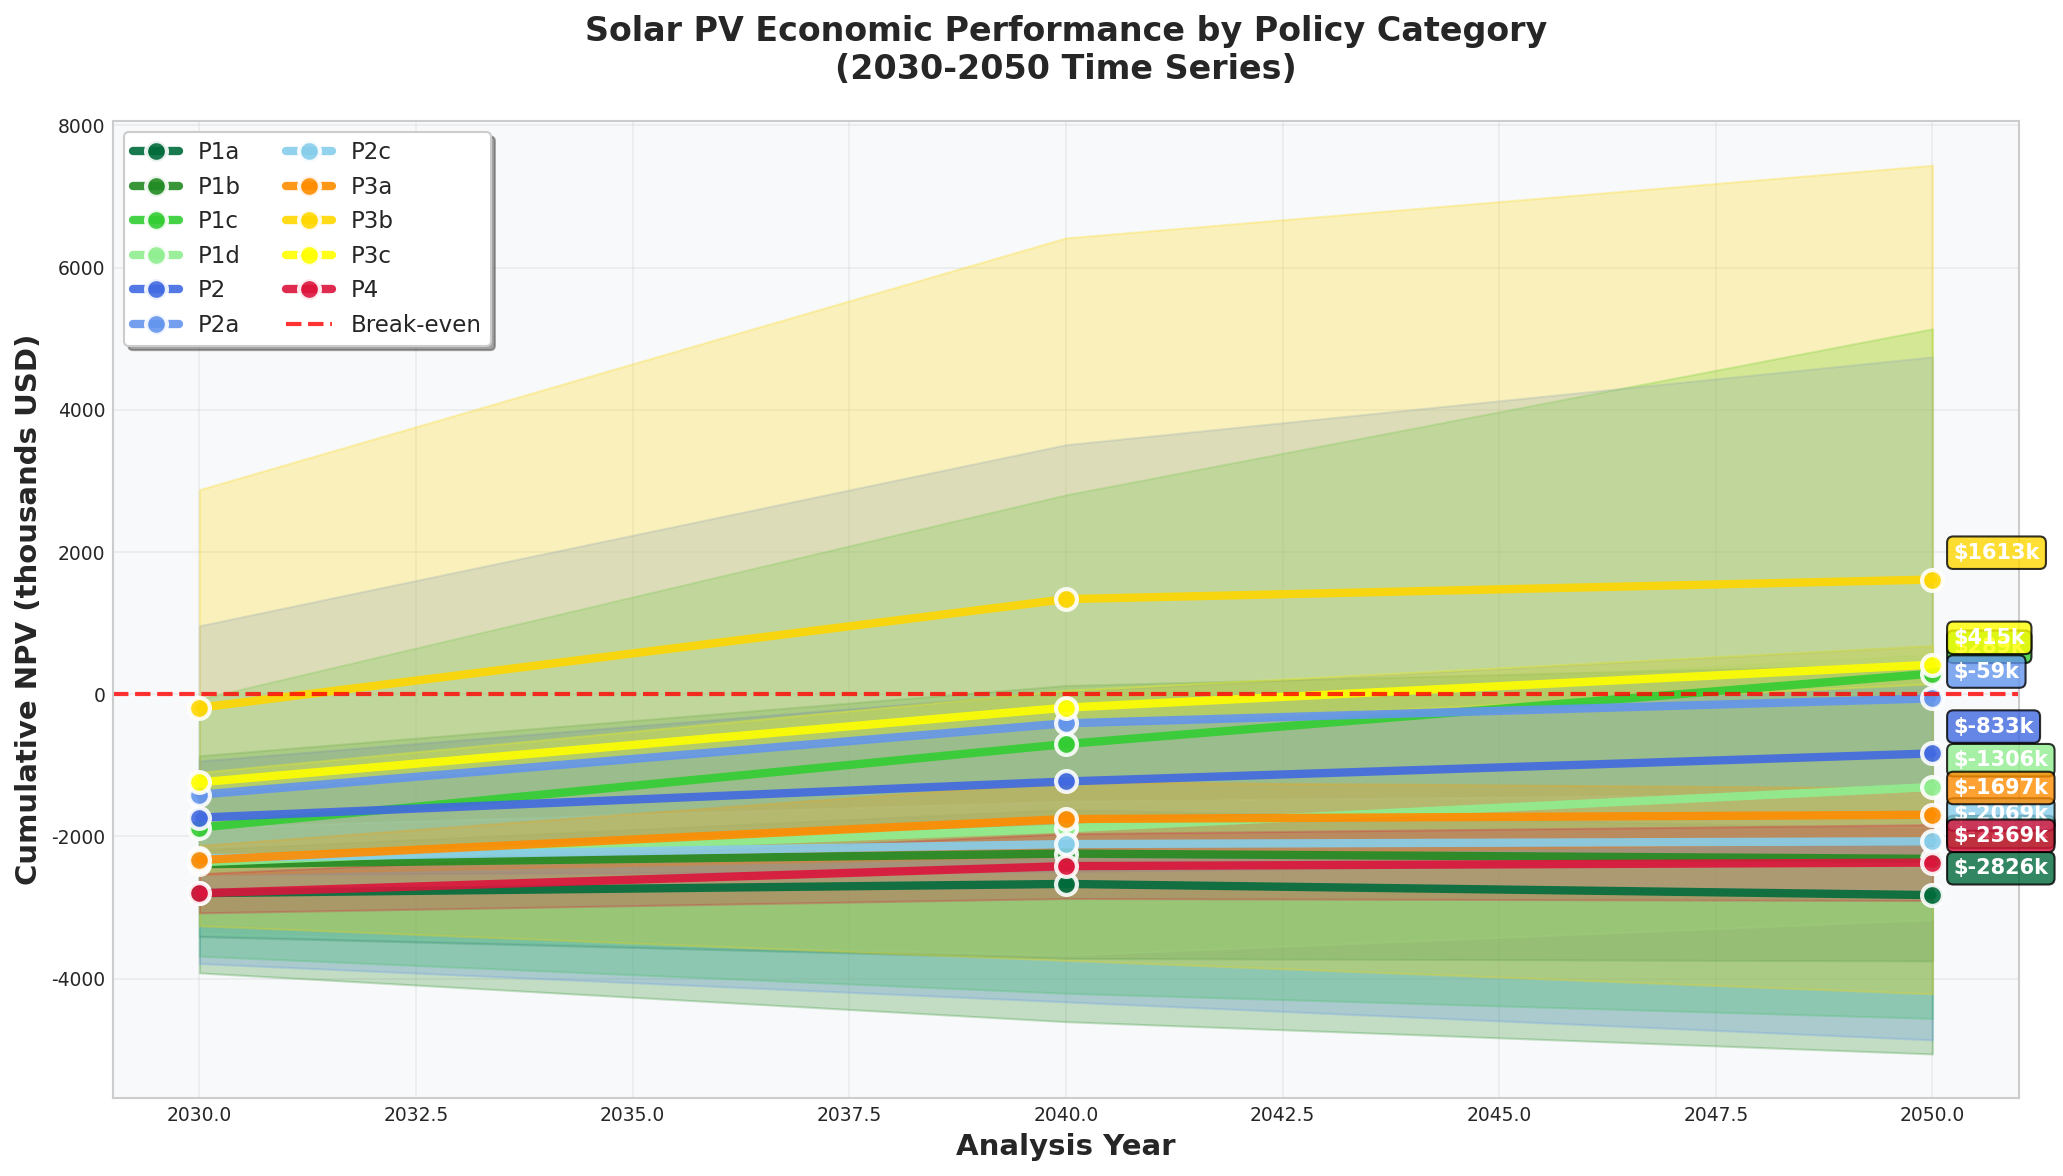


------------------------------------------------------------
🔥 创建插值版Category×Policy热力图...
   📊 计算Category×Policy矩阵...
   🔄 执行二维插值...
   ✅ 插值热力图保存至: data/2_interpolated_heatmap.png


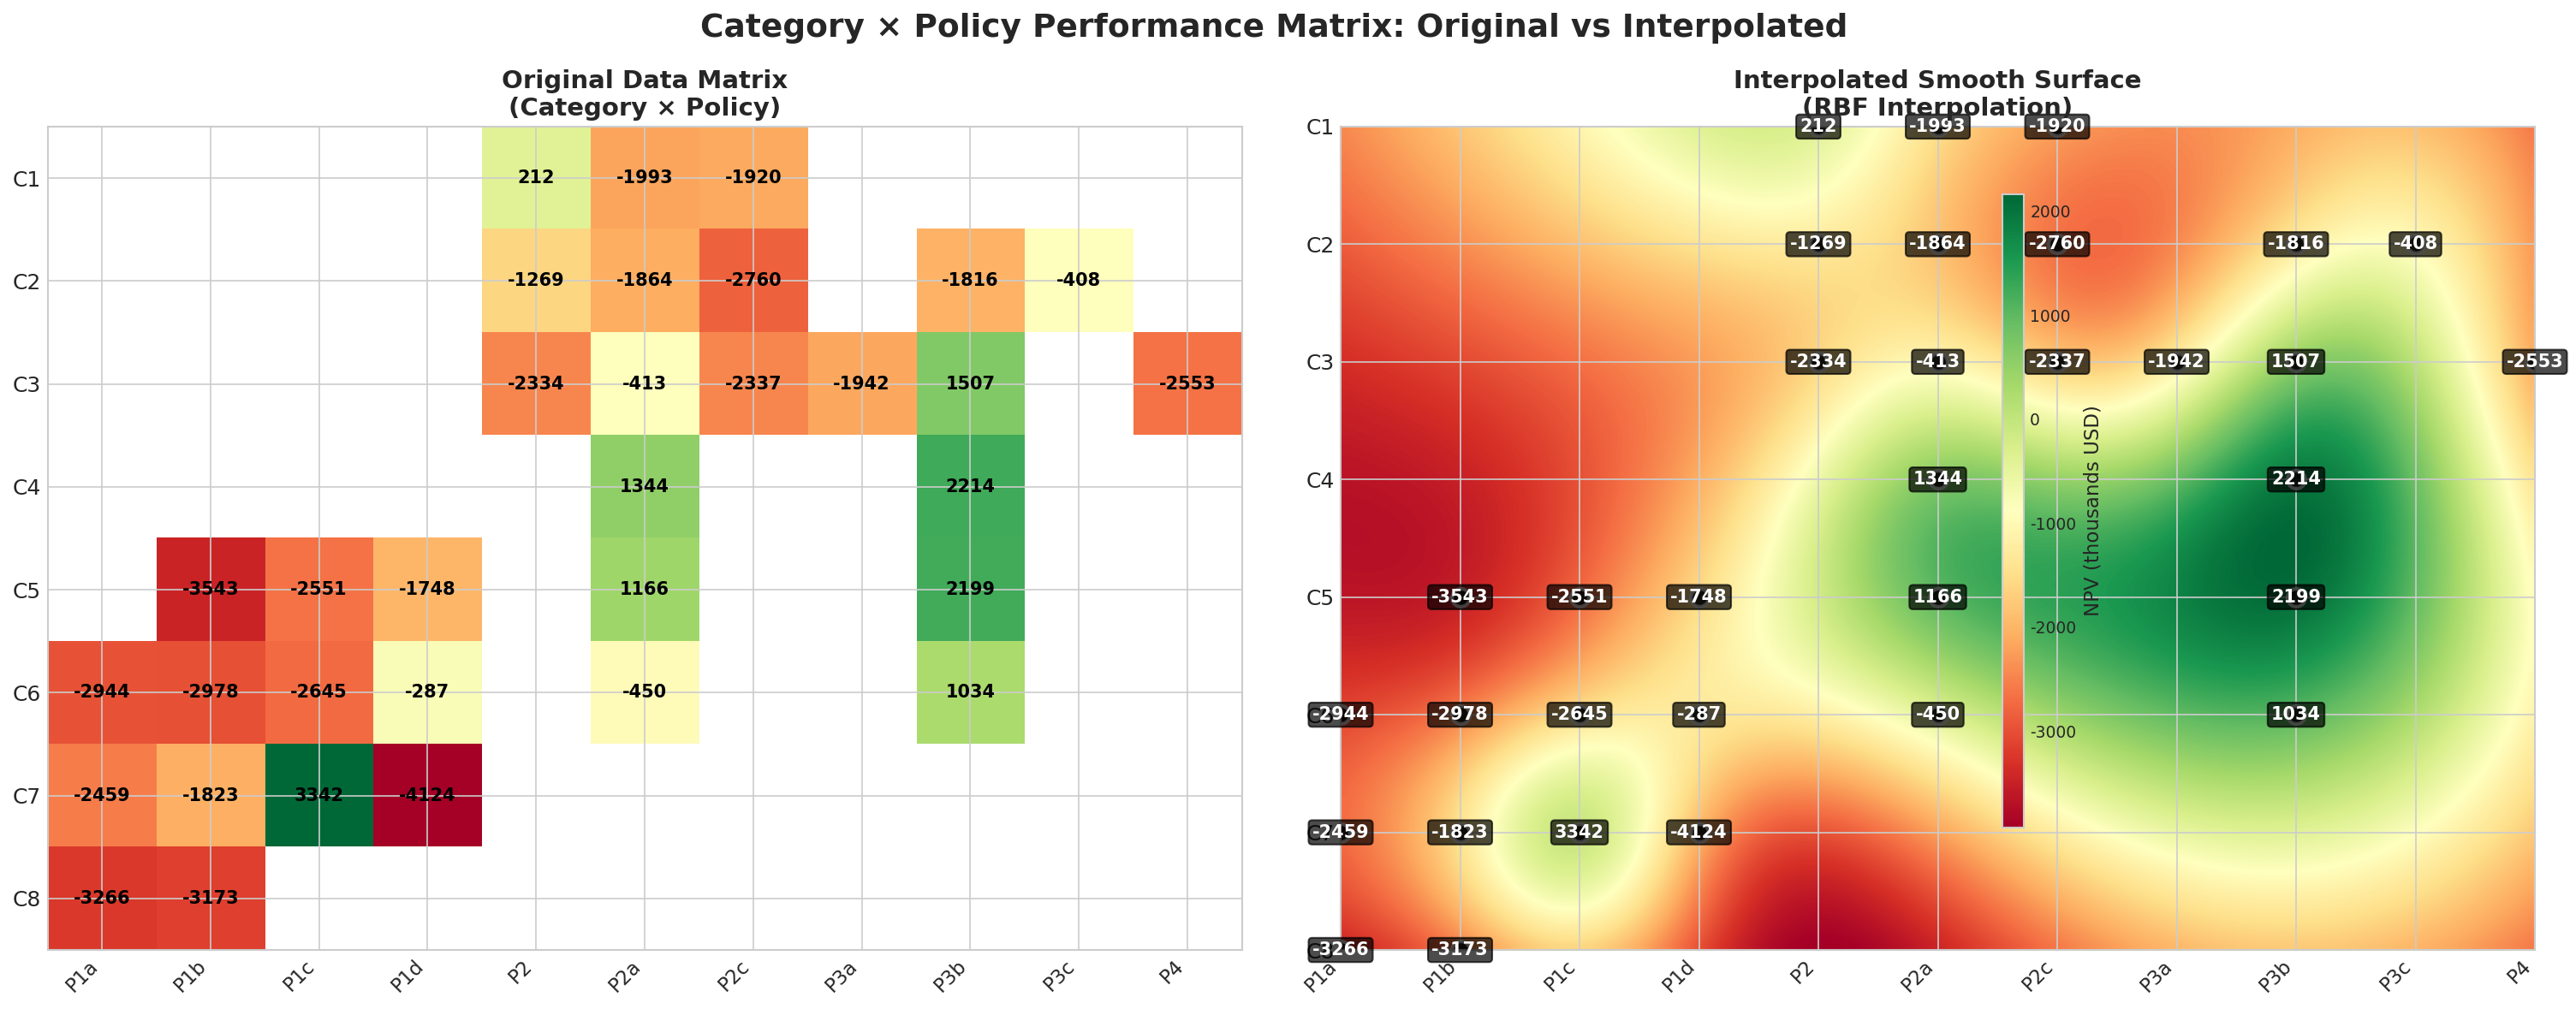


------------------------------------------------------------
🗺️ 创建空间分布地图...
   📊 输入数据统计:
      • 总记录数: 4,917
      • 唯一像素数: 1,983
   📊 计算空间汇总...
      • 空间汇总后像素数: 1,983
      • 经度范围: [-123.754, -78.279]
      • 纬度范围: [27.196, 48.904]
   ✅ 空间分布图保存至: data/3_spatial_distribution.png


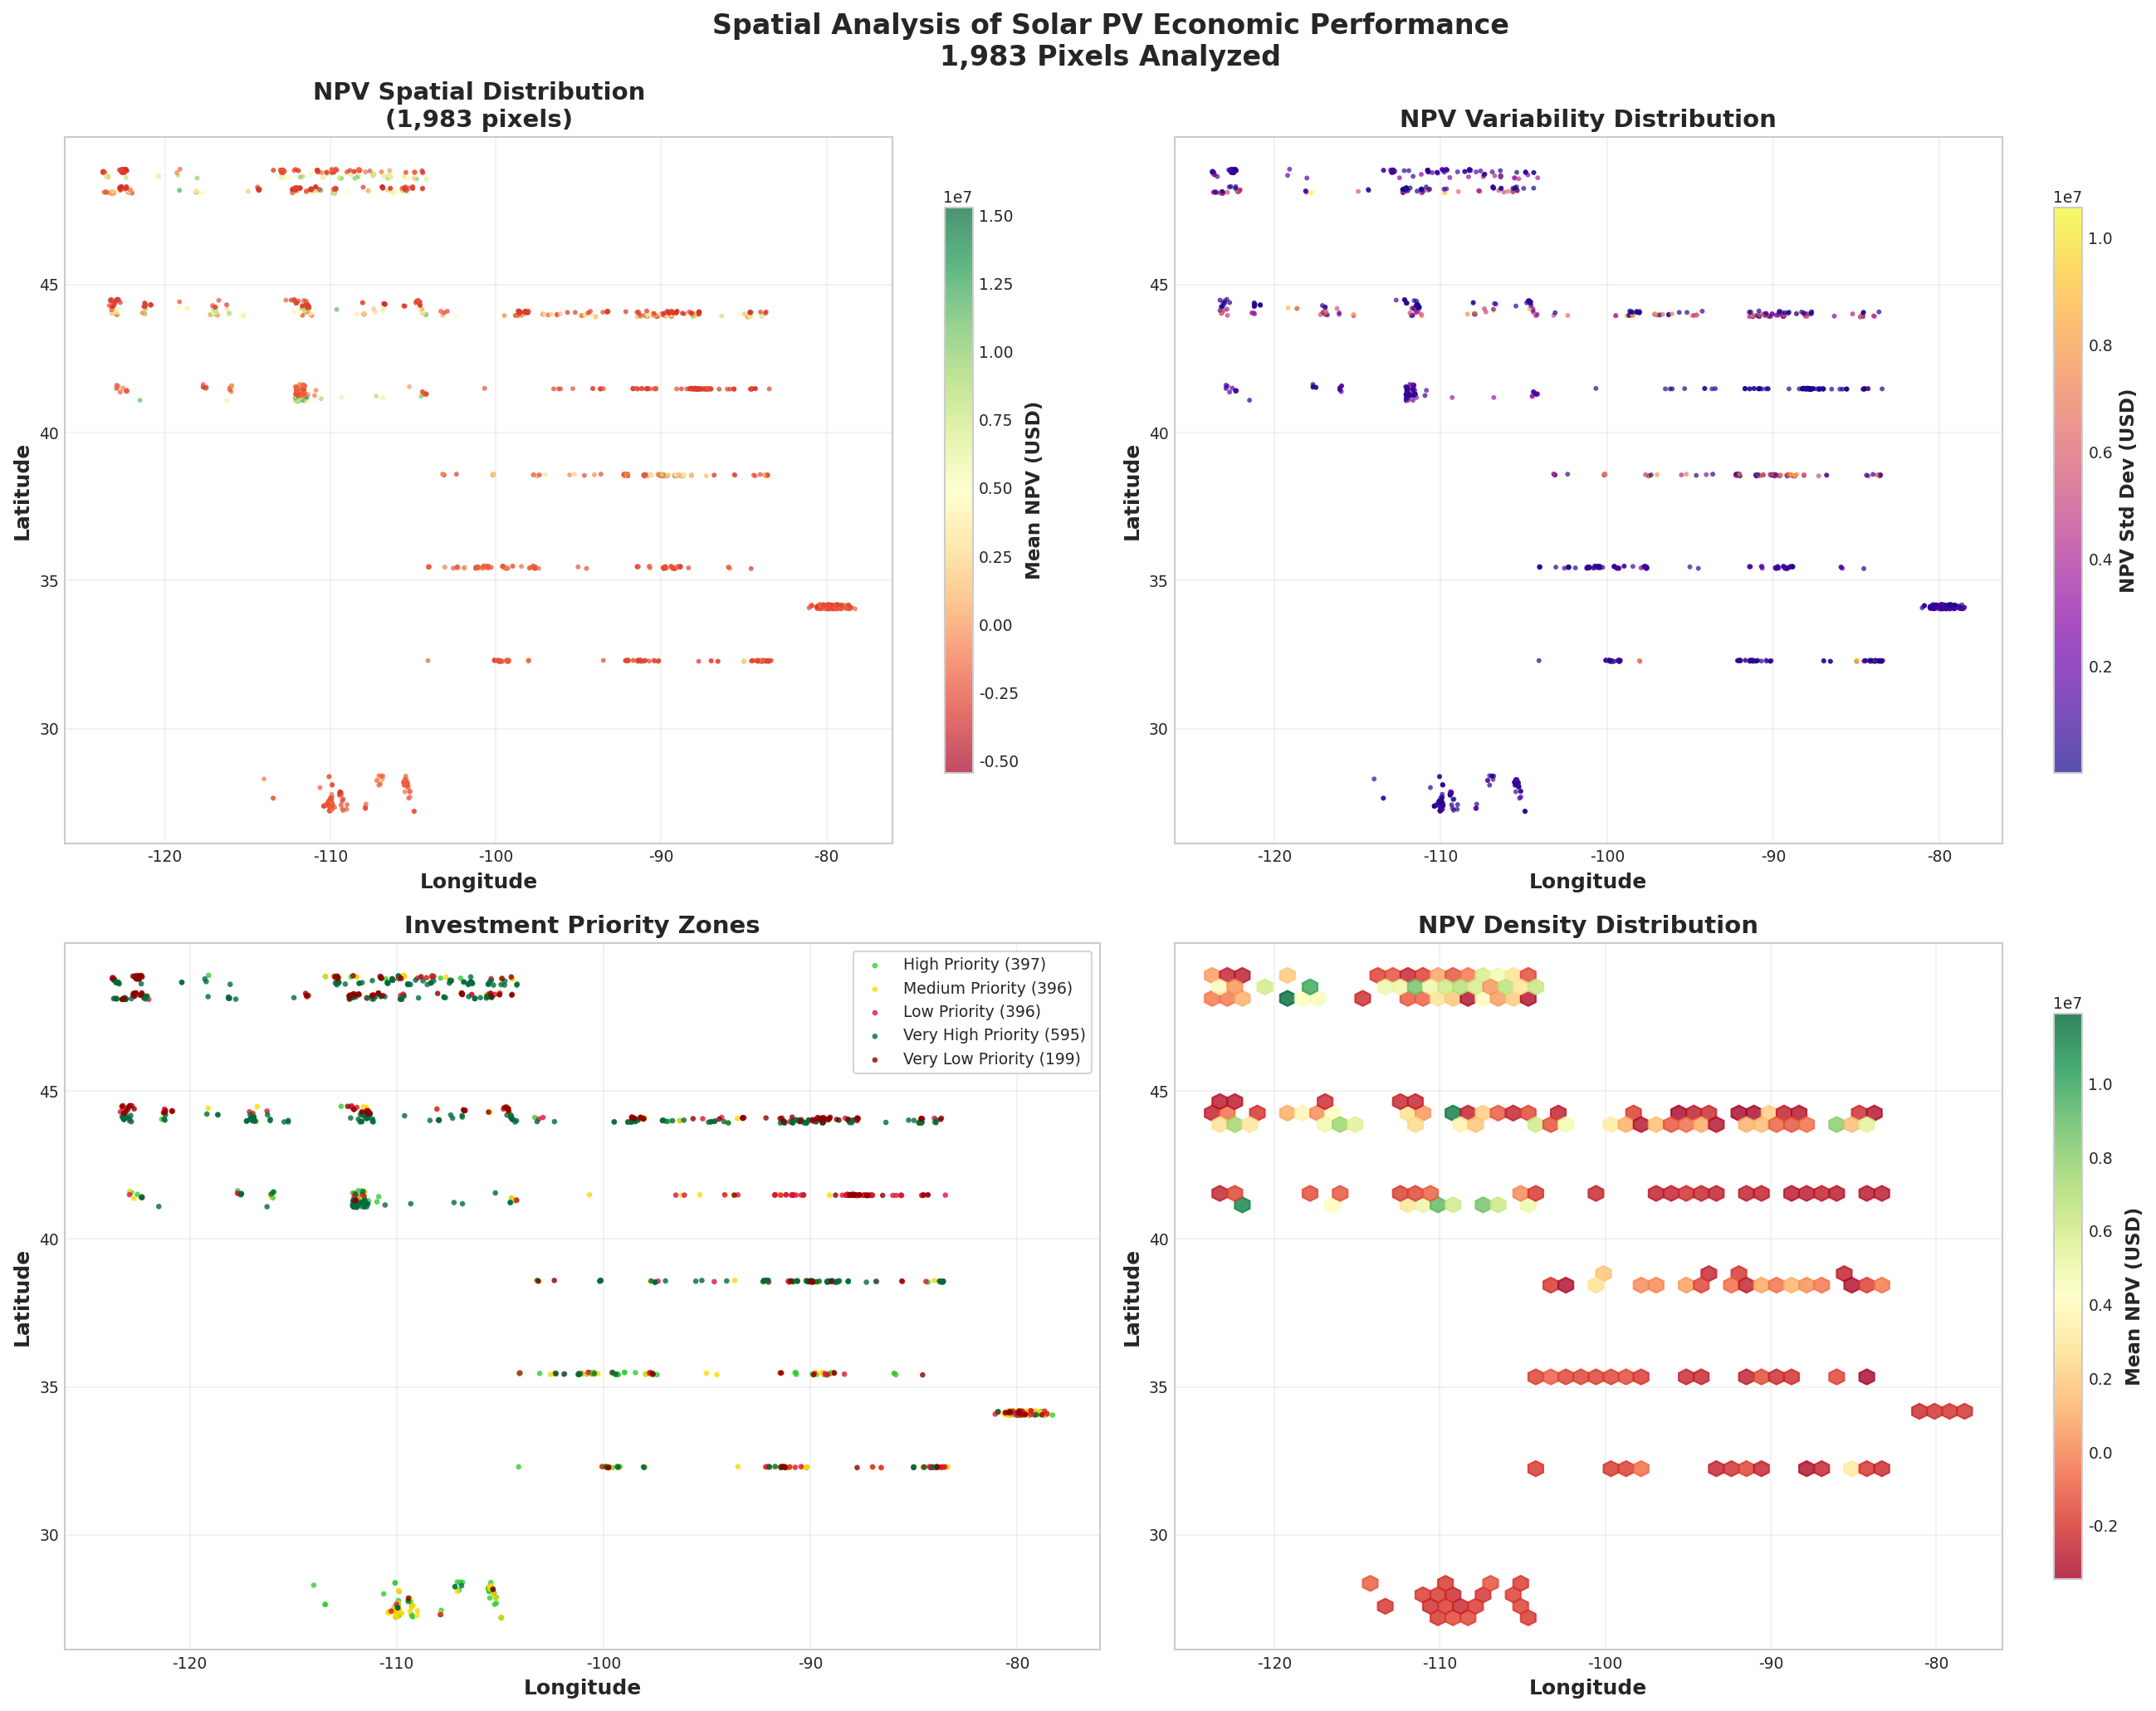


✅ 所有可视化图表创建完成!

📁 生成的文件:
   • data/1_policy_time_series.png - 政策时间序列分析
   • data/2_interpolated_heatmap.png - 插值版Category×Policy热力图
   • data/3_spatial_distribution.png - 空间分布分析
🎨 核心图表创建成功，开始创建额外分析...

创建额外分析图表
📁 分块读取数据...
   ✅ 加载数据: 100,000 行

📊 创建Category分析...
   ✅ Category分析图保存至: data/4_category_analysis.png


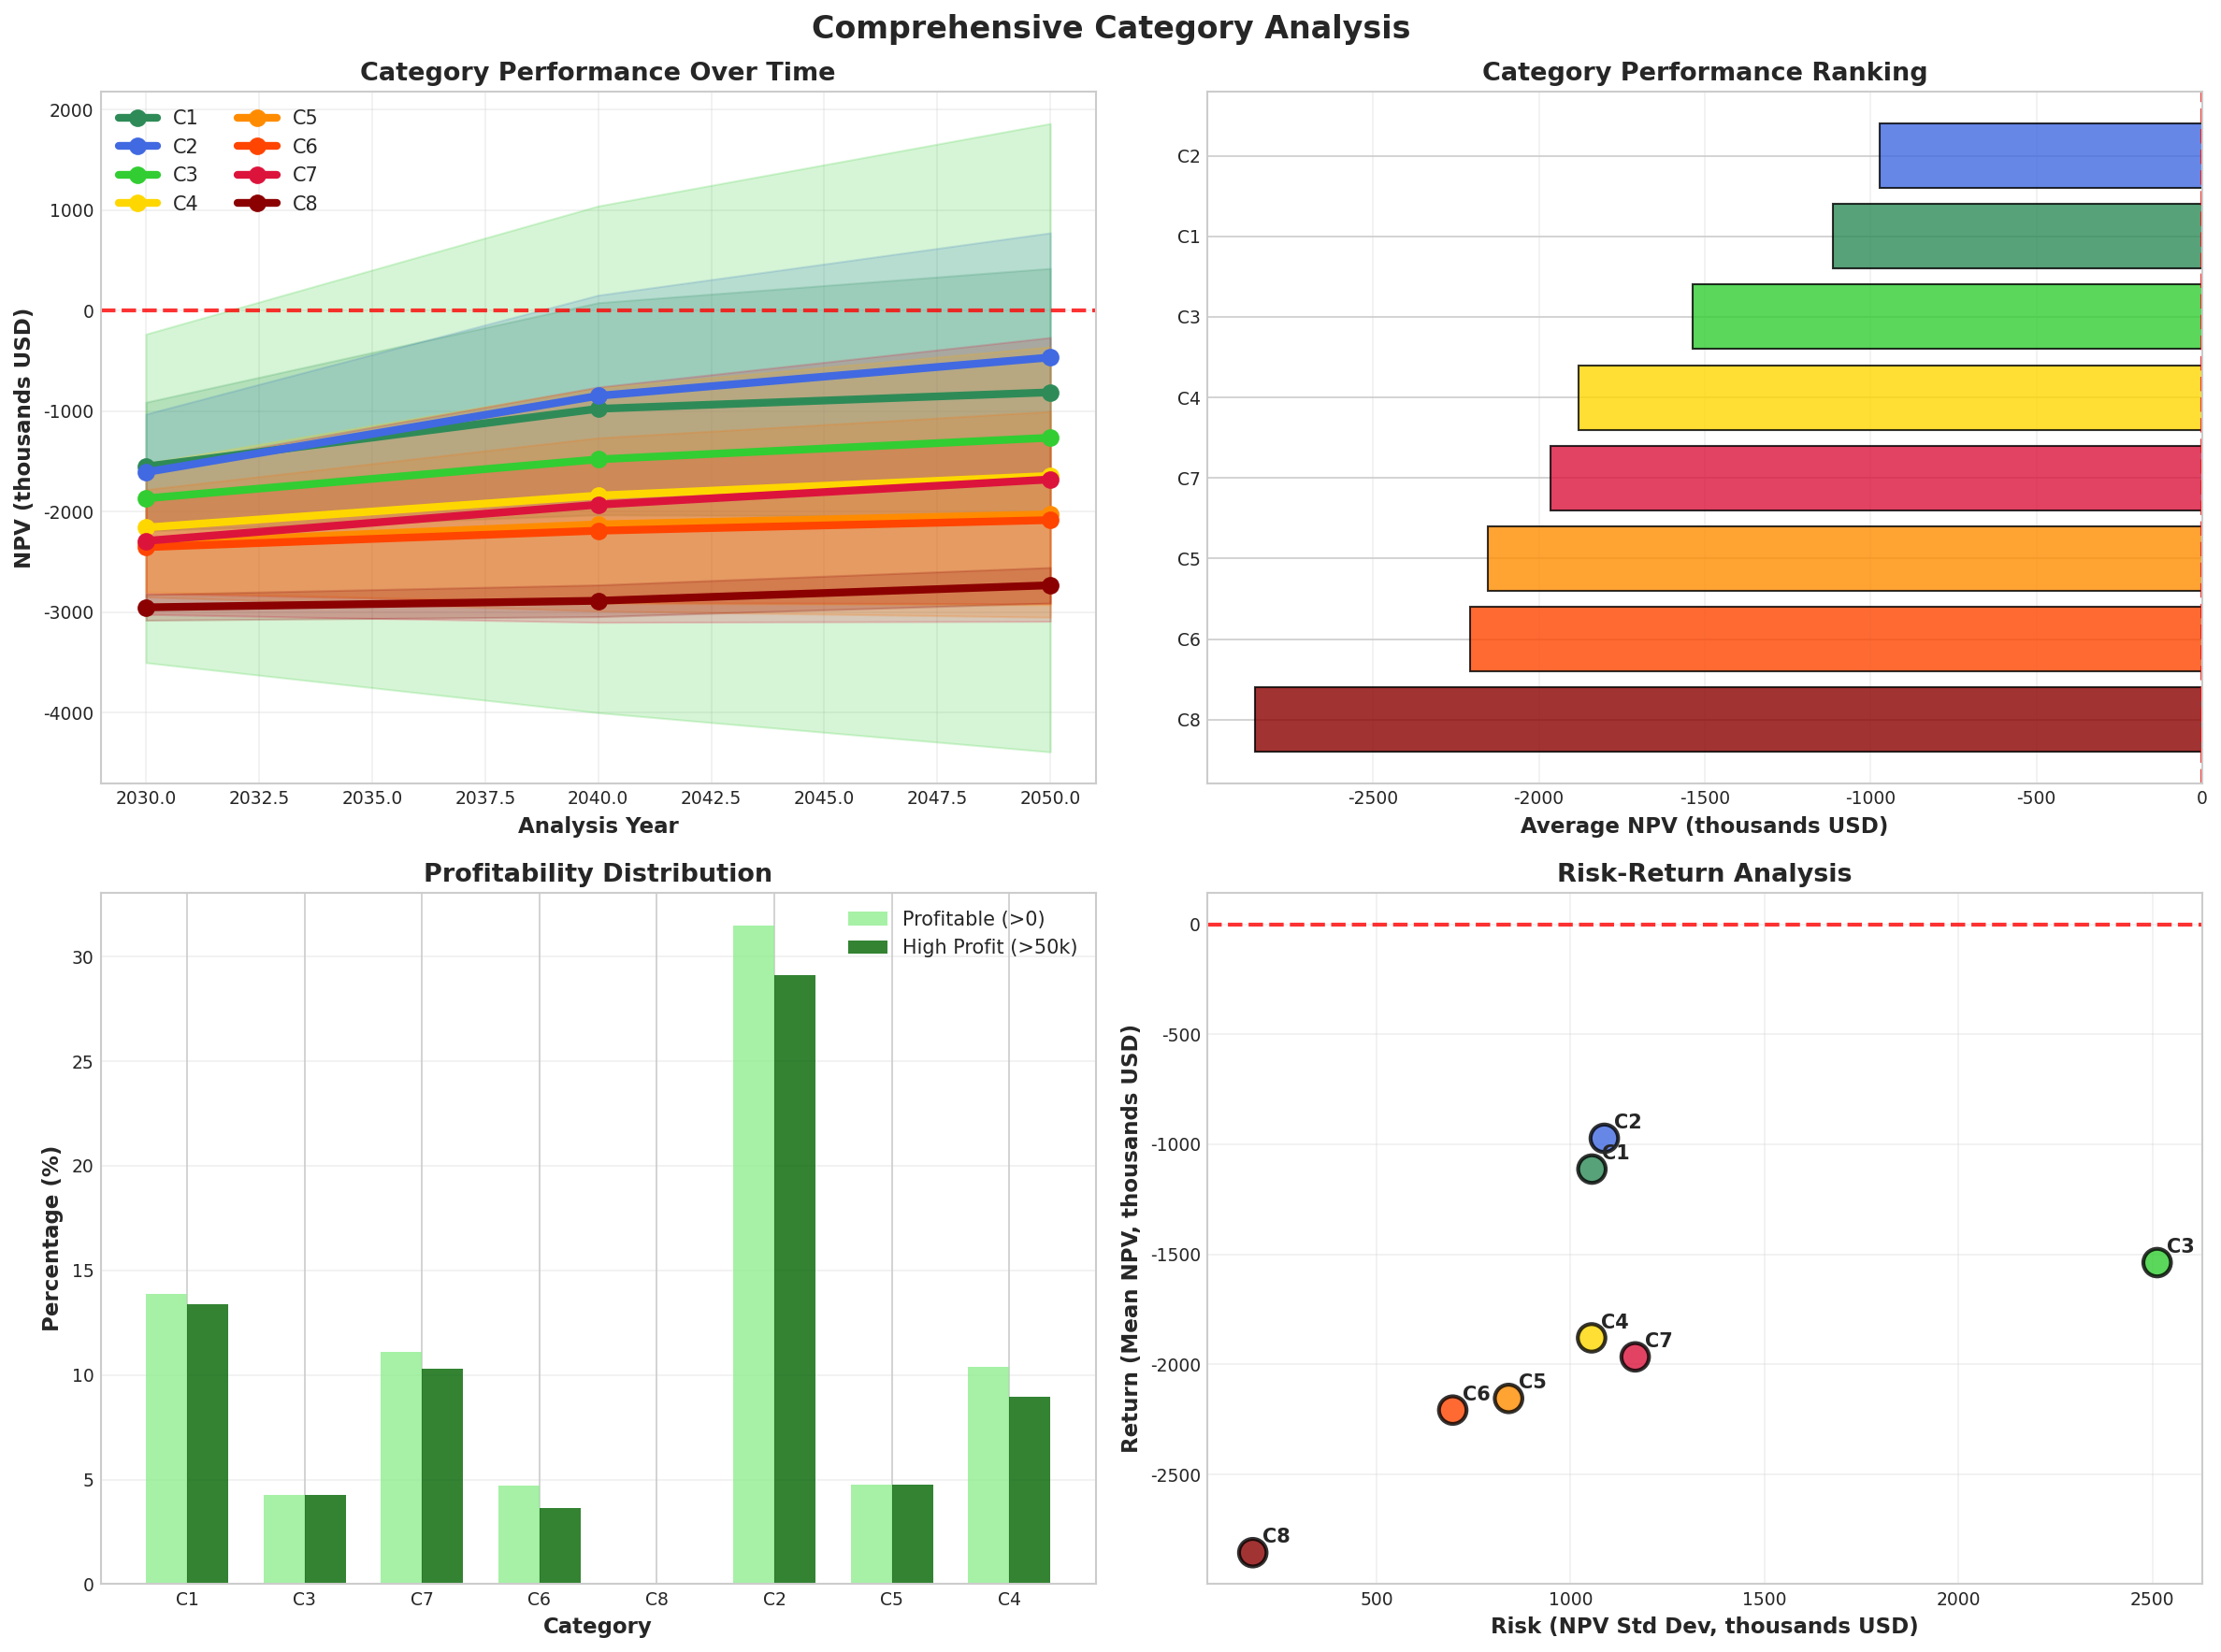


💰 创建盈利性分析...
   ✅ 盈利性分析图保存至: data/5_profitability_analysis.png


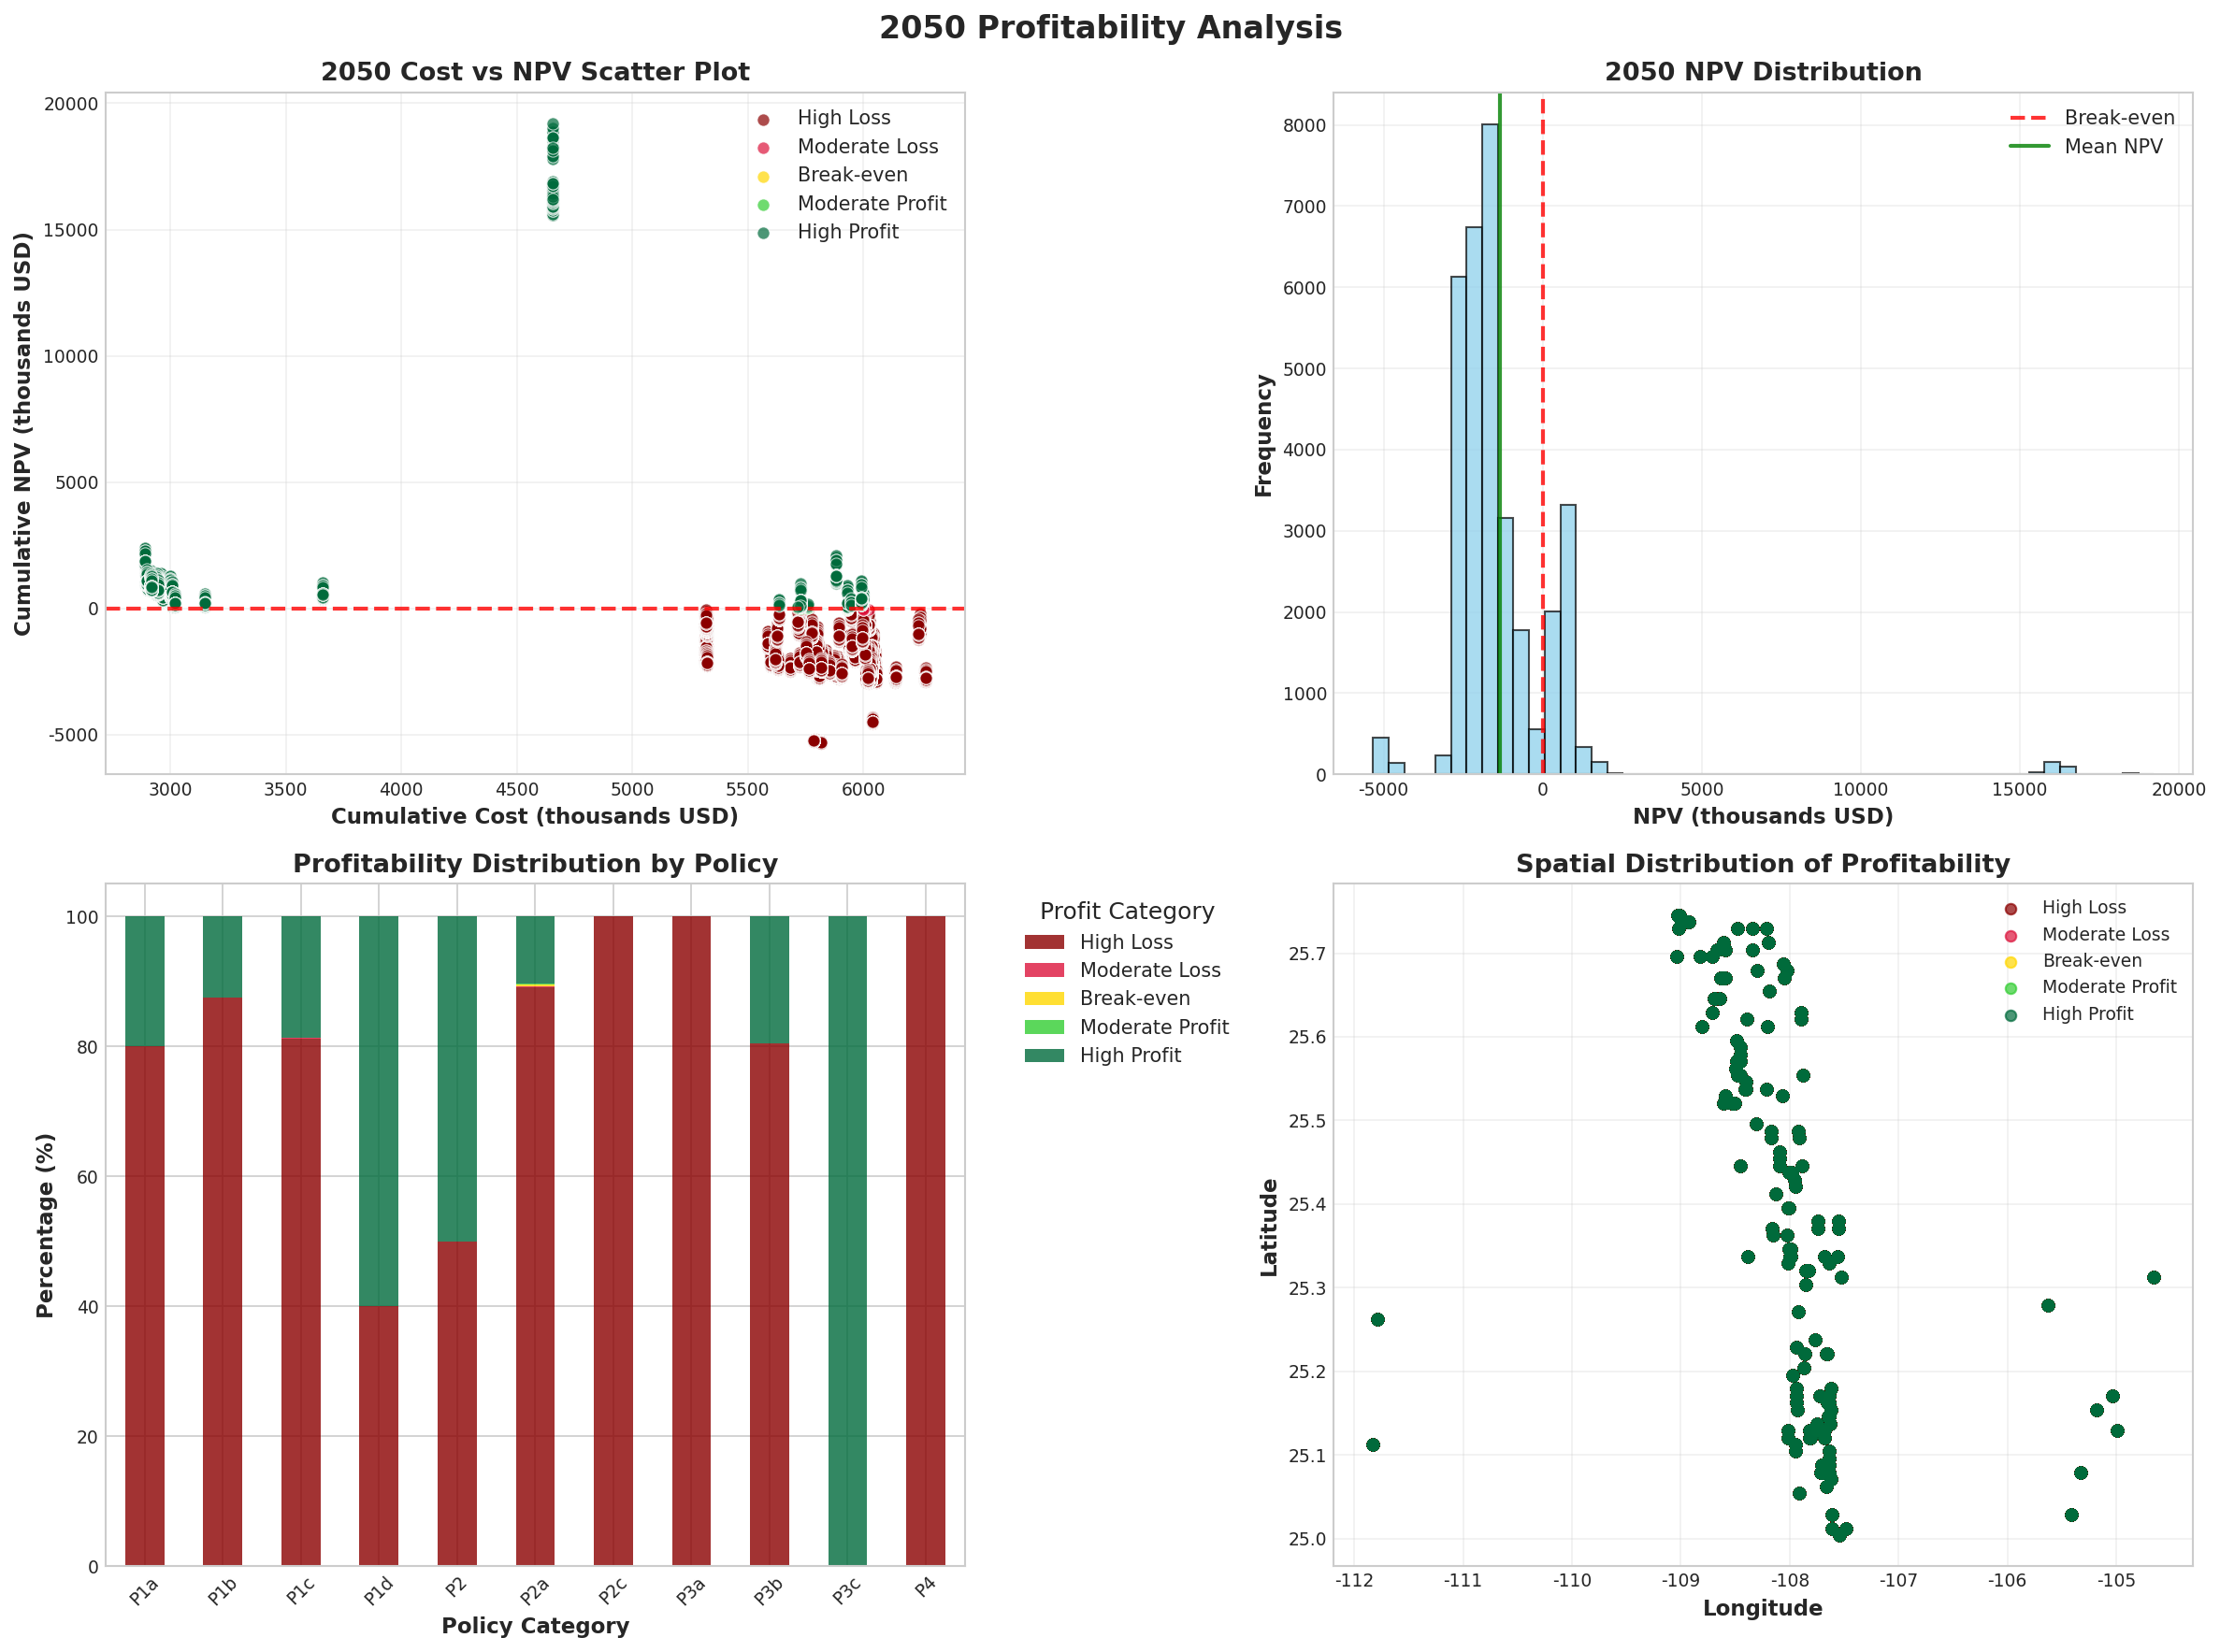


✅ 额外分析图表创建完成!
🎉 所有可视化图表创建完成!


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.spatial import cKDTree
import matplotlib.colors as mcolors
from matplotlib.patches import FancyBboxPatch
import warnings
warnings.filterwarnings('ignore')

# 设置美观的绘图参数
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# 精心设计的配色方案
category_colors = {
    'C1': '#2E8B57',    'C2': '#4169E1',    'C3': '#32CD32',    'C4': '#FFD700',
    'C5': '#FF8C00',    'C6': '#FF4500',    'C7': '#DC143C',    'C8': '#8B0000'
}

policy_colors = {
    'P1a': '#006B3C',   'P1b': '#228B22',   'P1c': '#32CD32',   'P1d': '#90EE90',
    'P2': '#4169E1',    'P2a': '#6495ED',   'P2c': '#87CEEB',
    'P3a': '#FF8C00',   'P3b': '#FFD700',   'P3c': '#FFFF00',
    'P4': '#DC143C'
}

def load_data_from_files(data_file='data/5.1_photovoltaic_results_complete_streaming.csv', 
                        summary_file='data/5.1_photovoltaic_policy_summary_streaming.csv'):
    """
    从保存的文件中加载数据
    """
    
    print("📁 从文件加载数据...")
    
    # 检查文件是否存在
    import os
    if not os.path.exists(data_file):
        print(f"❌ 数据文件不存在: {data_file}")
        return None, None
    
    # 获取文件大小
    file_size_mb = os.path.getsize(data_file) / (1024**2)
    print(f"   📊 数据文件大小: {file_size_mb:.1f}MB")
    
    # 智能加载策略
    if file_size_mb > 500:  # 如果文件超过500MB，使用采样
        print("   🎯 文件较大，使用采样策略...")
        
        # 先读取小样本确定总行数
        sample_chunk = pd.read_csv(data_file, nrows=1000)
        total_lines = sum(1 for line in open(data_file, 'r')) - 1
        
        # 计算采样比例（最多加载50万行）
        max_rows = 500000
        if total_lines > max_rows:
            sample_rate = max_rows / total_lines
            print(f"   📈 总行数: {total_lines:,}，采样率: {sample_rate:.1%}")
            
            # 分块读取并随机采样
            df_chunks = []
            chunk_size = 50000
            
            for chunk in pd.read_csv(data_file, chunksize=chunk_size):
                if np.random.random() < sample_rate:
                    sampled_chunk = chunk.sample(frac=sample_rate, random_state=42)
                    df_chunks.append(sampled_chunk)
                
                if len(df_chunks) > 10:  # 限制内存使用
                    break
            
            df_data = pd.concat(df_chunks, ignore_index=True) if df_chunks else None
        else:
            df_data = pd.read_csv(data_file)
    else:
        # 直接加载小文件
        print("   📖 直接加载数据文件...")
        df_data = pd.read_csv(data_file)
    
    if df_data is not None:
        print(f"   ✅ 加载数据: {len(df_data):,} 行")
        print(f"   📊 数据列: {list(df_data.columns)}")
        print(f"   🗓️ 年份范围: {sorted(df_data['analysis_year'].unique())}")
        print(f"   🏛️ 政策类别: {sorted(df_data['Policy_category'].unique())}")
        print(f"   📋 Category: {sorted(df_data['Category'].unique())}")
    
    # 加载汇总数据（如果存在）
    df_summary = None
    if os.path.exists(summary_file):
        df_summary = pd.read_csv(summary_file)
        print(f"   ✅ 加载汇总数据: {len(df_summary)} 行")
    
    return df_data, df_summary

def prepare_data_from_file(df_data):
    """
    文件数据预处理
    """
    print("📋 数据预处理...")
    
    if df_data is None:
        print("❌ 数据为空")
        return None
    
    # 检查并创建Model_Scenario列
    if 'Model_Scenario' not in df_data.columns:
        if 'Model' in df_data.columns and 'Scenario' in df_data.columns:
            df_data['Model_Scenario'] = df_data['Model'].astype(str) + '_' + df_data['Scenario'].astype(str)
            print("   ✓ 创建Model_Scenario列")
    
    # 检查关键列
    required_cols = ['Policy_category', 'Category', 'analysis_year', 'cumulative_npv_usd']
    missing_cols = [col for col in required_cols if col not in df_data.columns]
    
    if missing_cols:
        print(f"   ❌ 缺失关键列: {missing_cols}")
        return None
    
    print(f"   ✅ 数据准备完成")
    return df_data

def plot_policy_time_series_from_file(df_data, save_path='data/'):
    """
    从文件数据绘制政策类别时间序列图
    """
    print("🎨 绘制政策类别时间序列...")
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 计算政策类别统计（内存优化）
    print("   📊 计算政策统计...")
    policy_stats = df_data.groupby(['Policy_category', 'analysis_year']).agg({
        'cumulative_npv_usd': ['mean', 'std', 'count']
    }).reset_index()
    
    policy_stats.columns = ['Policy_category', 'analysis_year', 'npv_mean', 'npv_std', 'count']
    
    # 绘制趋势线
    policies = sorted(df_data['Policy_category'].unique())
    print(f"   🏛️ 绘制 {len(policies)} 个政策类别")
    
    for i, policy in enumerate(policies):
        color = policy_colors.get(policy, f'C{i}')
        policy_data = policy_stats[policy_stats['Policy_category'] == policy]
        
        if len(policy_data) > 0:
            # 主趋势线
            ax.plot(policy_data['analysis_year'], policy_data['npv_mean'] / 1000, 
                   color=color, linewidth=4, label=policy, alpha=0.9, 
                   marker='o', markersize=10, markeredgecolor='white', markeredgewidth=2)
            
            # 置信区间
            ax.fill_between(policy_data['analysis_year'], 
                           (policy_data['npv_mean'] - policy_data['npv_std']) / 1000,
                           (policy_data['npv_mean'] + policy_data['npv_std']) / 1000,
                           color=color, alpha=0.25)
            
            # 添加最终值标签
            last_point = policy_data.iloc[-1]
            ax.annotate(f'${last_point["npv_mean"]/1000:.0f}k', 
                       xy=(last_point['analysis_year'], last_point['npv_mean']/1000),
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8),
                       fontsize=10, fontweight='bold', color='white')
    
    # 美化图表
    ax.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Break-even')
    ax.set_xlabel('Analysis Year', fontsize=14, fontweight='bold')
    ax.set_ylabel('Cumulative NPV (thousands USD)', fontsize=14, fontweight='bold')
    ax.set_title('Solar PV Economic Performance by Policy Category\n(2030-2050 Time Series)', 
                fontweight='bold', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11, loc='upper left', frameon=True, fancybox=True, shadow=True, ncol=2)
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    output_path = f'{save_path}1_policy_time_series.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   ✅ 政策时间序列图保存至: {output_path}")
    plt.show()
    
    return fig

def plot_interpolated_heatmap_from_file(df_data, save_path='data/'):
    """
    从文件数据创建插值版Category×Policy热力图
    """
    print("🔥 创建插值版Category×Policy热力图...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # 计算原始数据（内存优化）
    print("   📊 计算Category×Policy矩阵...")
    heatmap_data = df_data.groupby(['Category', 'Policy_category'])['cumulative_npv_usd'].mean().unstack(fill_value=np.nan)
    heatmap_data = heatmap_data / 1000  # 转换为千美元
    
    # 左图：原始热力图
    im1 = ax1.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', interpolation='nearest')
    
    ax1.set_xticks(range(len(heatmap_data.columns)))
    ax1.set_yticks(range(len(heatmap_data.index)))
    ax1.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=11)
    ax1.set_yticklabels(heatmap_data.index, fontsize=12)
    ax1.set_title('Original Data Matrix\n(Category × Policy)', fontweight='bold', fontsize=14)
    
    # 添加数值标注
    for i in range(len(heatmap_data.index)):
        for j in range(len(heatmap_data.columns)):
            value = heatmap_data.iloc[i, j]
            if not np.isnan(value):
                text_color = 'white' if abs(value) > heatmap_data.values.std() else 'black'
                ax1.text(j, i, f'{value:.0f}', ha="center", va="center", 
                        color=text_color, fontweight='bold', fontsize=10)
    
    # 右图：插值版热力图
    print("   🔄 执行二维插值...")
    
    try:
        # 准备插值数据
        categories = list(heatmap_data.index)
        policies = list(heatmap_data.columns)
        
        # 创建坐标网格
        y_orig, x_orig = np.mgrid[0:len(categories), 0:len(policies)]
        
        # 找到有数据的点
        mask = ~np.isnan(heatmap_data.values)
        valid_points = np.column_stack((x_orig[mask], y_orig[mask]))
        valid_values = heatmap_data.values[mask]
        
        if len(valid_values) > 3:  # 需要至少3个点进行插值
            # 创建高分辨率网格
            resolution_factor = 10
            x_interp = np.linspace(0, len(policies)-1, len(policies) * resolution_factor)
            y_interp = np.linspace(0, len(categories)-1, len(categories) * resolution_factor)
            X_interp, Y_interp = np.meshgrid(x_interp, y_interp)
            
            # 使用RBF插值
            from scipy.interpolate import Rbf
            rbf = Rbf(valid_points[:, 0], valid_points[:, 1], valid_values, 
                     function='multiquadric', smooth=0.1)
            Z_interp = rbf(X_interp, Y_interp)
            
            # 绘制插值结果
            im2 = ax2.imshow(Z_interp, cmap='RdYlGn', aspect='auto', 
                            extent=[0, len(policies)-1, len(categories)-1, 0],
                            interpolation='bilinear')
            
            # 叠加原始数据点
            for i in range(len(categories)):
                for j in range(len(policies)):
                    if mask[i, j]:
                        ax2.scatter(j, i, c='black', s=100, marker='o', 
                                   edgecolors='white', linewidth=2, alpha=0.8)
                        ax2.text(j, i, f'{heatmap_data.iloc[i, j]:.0f}', 
                                ha="center", va="center", color='white', 
                                fontweight='bold', fontsize=10,
                                bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))
        else:
            # 如果数据点太少，显示原始热力图
            im2 = ax2.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', interpolation='bilinear')
    
    except Exception as e:
        print(f"   ⚠️ 插值失败，使用原始数据: {e}")
        im2 = ax2.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', interpolation='bilinear')
    
    # 设置坐标轴
    ax2.set_xticks(range(len(heatmap_data.columns)))
    ax2.set_yticks(range(len(heatmap_data.index)))
    ax2.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=11)
    ax2.set_yticklabels(heatmap_data.index, fontsize=12)
    ax2.set_title('Interpolated Smooth Surface\n(RBF Interpolation)', fontweight='bold', fontsize=14)
    
    # 添加颜色条
    fig.colorbar(im2, ax=[ax1, ax2], shrink=0.8, aspect=30, 
                label='NPV (thousands USD)', pad=0.05)
    
    plt.suptitle('Category × Policy Performance Matrix: Original vs Interpolated', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    output_path = f'{save_path}2_interpolated_heatmap.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   ✅ 插值热力图保存至: {output_path}")
    plt.show()
    
    return fig

def plot_spatial_distribution_from_file(df_data, save_path='data/', sample_size=50000):
    """
    从文件数据创建空间分布地图（内存优化）
    """
    print("🗺️ 创建空间分布地图...")
    
    # 数据诊断
    print(f"   📊 输入数据统计:")
    print(f"      • 总记录数: {len(df_data):,}")
    print(f"      • 唯一像素数: {df_data['pixel_id'].nunique():,}")
    
    # 智能采样以避免内存问题
    if len(df_data) > sample_size:
        print(f"   🎯 采样 {sample_size:,} 条记录进行可视化")
        df_sample = df_data.sample(n=sample_size, random_state=42)
    else:
        df_sample = df_data
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    
    # 方法1: 按像素汇总
    print("   📊 计算空间汇总...")
    spatial_summary = df_sample.groupby(['pixel_id', 'lat', 'lon']).agg({
        'cumulative_npv_usd': ['mean', 'std', 'count']
    }).reset_index()
    spatial_summary.columns = ['pixel_id', 'lat', 'lon', 'npv_mean', 'npv_std', 'record_count']
    
    print(f"      • 空间汇总后像素数: {len(spatial_summary):,}")
    print(f"      • 经度范围: [{spatial_summary['lon'].min():.3f}, {spatial_summary['lon'].max():.3f}]")
    print(f"      • 纬度范围: [{spatial_summary['lat'].min():.3f}, {spatial_summary['lat'].max():.3f}]")
    
    # 图1: NPV空间分布
    scatter1 = ax1.scatter(spatial_summary['lon'], spatial_summary['lat'], 
                          c=spatial_summary['npv_mean'], cmap='RdYlGn',
                          s=8, alpha=0.7, edgecolors='none')
    ax1.set_xlabel('Longitude', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Latitude', fontweight='bold', fontsize=12)
    ax1.set_title(f'NPV Spatial Distribution\n({len(spatial_summary):,} pixels)', 
                 fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.8)
    cbar1.set_label('Mean NPV (USD)', fontweight='bold')
    
    # 图2: NPV变异性分布
    scatter2 = ax2.scatter(spatial_summary['lon'], spatial_summary['lat'], 
                          c=spatial_summary['npv_std'], cmap='plasma',
                          s=8, alpha=0.7, edgecolors='none')
    ax2.set_xlabel('Longitude', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Latitude', fontweight='bold', fontsize=12)
    ax2.set_title('NPV Variability Distribution', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3)
    cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.8)
    cbar2.set_label('NPV Std Dev (USD)', fontweight='bold')
    
    # 图3: 投资优先级分区
    npv_percentiles = np.percentile(spatial_summary['npv_mean'], [10, 30, 50, 70, 90])
    
    def get_priority_level(npv):
        if npv < npv_percentiles[0]:
            return 'Very Low Priority'
        elif npv < npv_percentiles[1]:
            return 'Low Priority'
        elif npv < npv_percentiles[2]:
            return 'Medium Priority'
        elif npv < npv_percentiles[3]:
            return 'High Priority'
        else:
            return 'Very High Priority'
    
    spatial_summary['priority'] = spatial_summary['npv_mean'].apply(get_priority_level)
    
    priority_colors_map = {
        'Very Low Priority': '#8B0000', 'Low Priority': '#DC143C', 
        'Medium Priority': '#FFD700', 'High Priority': '#32CD32', 
        'Very High Priority': '#006B3C'
    }
    
    for priority in spatial_summary['priority'].unique():
        subset = spatial_summary[spatial_summary['priority'] == priority]
        ax3.scatter(subset['lon'], subset['lat'], 
                   c=priority_colors_map[priority], label=f'{priority} ({len(subset)})',
                   s=10, alpha=0.8, edgecolors='none')
    
    ax3.set_xlabel('Longitude', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Latitude', fontweight='bold', fontsize=12)
    ax3.set_title('Investment Priority Zones', fontweight='bold', fontsize=14)
    ax3.legend(fontsize=9, frameon=True, fancybox=True, loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    # 图4: 密度热力图
    hb = ax4.hexbin(spatial_summary['lon'], spatial_summary['lat'], 
                   C=spatial_summary['npv_mean'], gridsize=50, cmap='RdYlGn', 
                   alpha=0.8, mincnt=1)
    ax4.set_xlabel('Longitude', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Latitude', fontweight='bold', fontsize=12)
    ax4.set_title('NPV Density Distribution', fontweight='bold', fontsize=14)
    ax4.grid(True, alpha=0.3)
    cbar4 = plt.colorbar(hb, ax=ax4, shrink=0.8)
    cbar4.set_label('Mean NPV (USD)', fontweight='bold')
    
    plt.suptitle(f'Spatial Analysis of Solar PV Economic Performance\n{len(spatial_summary):,} Pixels Analyzed', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    output_path = f'{save_path}3_spatial_distribution.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   ✅ 空间分布图保存至: {output_path}")
    plt.show()
    
    return fig

def create_visualizations_from_files(data_file='data/5.1_photovoltaic_results_complete_streaming.csv',
                                    summary_file='data/5.1_photovoltaic_policy_summary_streaming.csv',
                                    save_path='data/'):
    """
    从文件创建所有可视化图表的主函数
    """
    
    print("\n" + "="*80)
    print("从文件创建可视化图表套件")
    print("="*80)
    
    # 1. 加载数据
    df_data, df_summary = load_data_from_files(data_file, summary_file)
    
    if df_data is None:
        print("❌ 无法加载数据")
        return None
    
    # 2. 数据预处理
    df_processed = prepare_data_from_file(df_data)
    if df_processed is None:
        print("❌ 数据预处理失败")
        return None
    
    # 创建保存目录
    import os
    os.makedirs(save_path, exist_ok=True)
    
    figures = {}
    
    try:
        # 3. 政策时间序列图
        print("\n" + "-"*60)
        figures['policy_time_series'] = plot_policy_time_series_from_file(df_processed, save_path)
        
        # 4. 插值热力图
        print("\n" + "-"*60)
        figures['interpolated_heatmap'] = plot_interpolated_heatmap_from_file(df_processed, save_path)
        
        # 5. 空间分布图
        print("\n" + "-"*60)
        figures['spatial_distribution'] = plot_spatial_distribution_from_file(df_processed, save_path)
        
        print("\n" + "="*80)
        print("✅ 所有可视化图表创建完成!")
        print("\n📁 生成的文件:")
        print(f"   • {save_path}1_policy_time_series.png - 政策时间序列分析")
        print(f"   • {save_path}2_interpolated_heatmap.png - 插值版Category×Policy热力图")
        print(f"   • {save_path}3_spatial_distribution.png - 空间分布分析")
        print("="*80)
        
        # 清理内存
        del df_data, df_processed
        import gc
        gc.collect()
        
        return figures
        
    except Exception as e:
        print(f"❌ 可视化创建失败: {e}")
        import traceback
        traceback.print_exc()
        return None

def create_additional_analysis_from_file(data_file='data/5.1_photovoltaic_results_complete_streaming.csv',
                                       save_path='data/', max_sample=100000):
    """
    从文件创建额外的分析图表（Category和盈利性分析）
    """
    
    print("\n" + "="*60)
    print("创建额外分析图表")
    print("="*60)
    
    # 分块读取数据以节省内存
    print("📁 分块读取数据...")
    
    chunk_size = 50000
    chunks = []
    total_rows = 0
    
    for chunk in pd.read_csv(data_file, chunksize=chunk_size):
        if total_rows < max_sample:
            chunks.append(chunk)
            total_rows += len(chunk)
        else:
            break
    
    df_data = pd.concat(chunks, ignore_index=True) if chunks else None
    
    if df_data is None:
        print("❌ 无法加载数据")
        return None
    
    print(f"   ✅ 加载数据: {len(df_data):,} 行")
    
    try:
        # Category分析
        print("\n📊 创建Category分析...")
        fig_cat = plot_category_analysis_from_file(df_data, save_path)
        
        # 盈利性分析
        print("\n💰 创建盈利性分析...")
        fig_profit = plot_profitability_analysis_from_file(df_data, save_path)
        
        print("\n✅ 额外分析图表创建完成!")
        
        # 清理内存
        del df_data
        import gc
        gc.collect()
        
        return {'category_analysis': fig_cat, 'profitability_analysis': fig_profit}
        
    except Exception as e:
        print(f"❌ 额外分析创建失败: {e}")
        import traceback
        traceback.print_exc()
        return None

def plot_category_analysis_from_file(df_data, save_path='data/'):
    """
    从文件数据绘制Category分析
    """
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 图1: Category时间序列
    category_stats = df_data.groupby(['Category', 'analysis_year']).agg({
        'cumulative_npv_usd': ['mean', 'std']
    }).reset_index()
    category_stats.columns = ['Category', 'analysis_year', 'npv_mean', 'npv_std']
    
    for category in sorted(df_data['Category'].unique()):
        color = category_colors.get(category, '#708090')
        cat_data = category_stats[category_stats['Category'] == category]
        
        ax1.plot(cat_data['analysis_year'], cat_data['npv_mean'] / 1000,
                color=color, linewidth=4, label=category, marker='o', markersize=8)
        
        ax1.fill_between(cat_data['analysis_year'],
                        (cat_data['npv_mean'] - cat_data['npv_std']) / 1000,
                        (cat_data['npv_mean'] + cat_data['npv_std']) / 1000,
                        color=color, alpha=0.2)
    
    ax1.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.8)
    ax1.set_xlabel('Analysis Year', fontweight='bold')
    ax1.set_ylabel('NPV (thousands USD)', fontweight='bold')
    ax1.set_title('Category Performance Over Time', fontweight='bold')
    ax1.legend(fontsize=10, loc='upper left', ncol=2)
    ax1.grid(True, alpha=0.3)
    
    # 图2: Category排名
    cat_ranking = df_data.groupby('Category')['cumulative_npv_usd'].mean().sort_values(ascending=True)
    
    bars = ax2.barh(range(len(cat_ranking)), cat_ranking.values / 1000,
                    color=[category_colors.get(cat, '#708090') for cat in cat_ranking.index],
                    alpha=0.8, edgecolor='black', linewidth=1)
    
    ax2.set_yticks(range(len(cat_ranking)))
    ax2.set_yticklabels(cat_ranking.index)
    ax2.set_xlabel('Average NPV (thousands USD)', fontweight='bold')
    ax2.set_title('Category Performance Ranking', fontweight='bold')
    ax2.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.8)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # 图3: 盈利性分布
    profit_data = []
    for category in df_data['Category'].unique():
        cat_data = df_data[df_data['Category'] == category]
        profitable_pct = (cat_data['cumulative_npv_usd'] > 0).mean() * 100
        high_profit_pct = (cat_data['cumulative_npv_usd'] > 50000).mean() * 100
        profit_data.append({'Category': category, 'Profitable': profitable_pct, 'High_Profit': high_profit_pct})
    
    profit_df = pd.DataFrame(profit_data)
    
    x = np.arange(len(profit_df))
    width = 0.35
    
    ax3.bar(x - width/2, profit_df['Profitable'], width, label='Profitable (>0)', 
           color='lightgreen', alpha=0.8)
    ax3.bar(x + width/2, profit_df['High_Profit'], width, label='High Profit (>50k)', 
           color='darkgreen', alpha=0.8)
    
    ax3.set_xlabel('Category', fontweight='bold')
    ax3.set_ylabel('Percentage (%)', fontweight='bold')
    ax3.set_title('Profitability Distribution', fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(profit_df['Category'])
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 图4: 风险回报分析
    risk_data = df_data.groupby('Category').agg({
        'cumulative_npv_usd': ['mean', 'std']
    }).reset_index()
    risk_data.columns = ['Category', 'mean_npv', 'std_npv']
    
    scatter = ax4.scatter(risk_data['std_npv']/1000, risk_data['mean_npv']/1000,
                         c=[category_colors.get(cat, '#708090') for cat in risk_data['Category']],
                         s=200, alpha=0.8, edgecolors='black', linewidth=2)
    
    for i, row in risk_data.iterrows():
        ax4.annotate(row['Category'], 
                    xy=(row['std_npv']/1000, row['mean_npv']/1000),
                    xytext=(5, 5), textcoords='offset points',
                    fontweight='bold', fontsize=10)
    
    ax4.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.8)
    ax4.set_xlabel('Risk (NPV Std Dev, thousands USD)', fontweight='bold')
    ax4.set_ylabel('Return (Mean NPV, thousands USD)', fontweight='bold')
    ax4.set_title('Risk-Return Analysis', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Comprehensive Category Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    output_path = f'{save_path}4_category_analysis.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   ✅ Category分析图保存至: {output_path}")
    plt.show()
    
    return fig

def plot_profitability_analysis_from_file(df_data, save_path='data/'):
    """
    从文件数据绘制盈利性分析
    """
    
    # 提取2050年数据
    data_2050 = df_data[df_data['analysis_year'] == 2050].copy()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 图1: 盈利性散点图
    profit_colors_map = {
        'High Loss': '#8B0000', 'Moderate Loss': '#DC143C', 'Break-even': '#FFD700', 
        'Moderate Profit': '#32CD32', 'High Profit': '#006B3C'
    }
    
    data_2050['profit_category'] = pd.cut(data_2050['cumulative_npv_usd'],
                                         bins=[-np.inf, -50000, -10000, 10000, 50000, np.inf],
                                         labels=['High Loss', 'Moderate Loss', 'Break-even', 'Moderate Profit', 'High Profit'])
    
    for profit_cat in data_2050['profit_category'].cat.categories:
        subset = data_2050[data_2050['profit_category'] == profit_cat]
        if len(subset) > 0:
            ax1.scatter(subset['cumulative_cost_usd'] / 1000, subset['cumulative_npv_usd'] / 1000,
                       c=profit_colors_map.get(profit_cat, '#708090'), label=profit_cat,
                       alpha=0.7, s=40, edgecolors='white', linewidth=0.5)
    
    ax1.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.8)
    ax1.set_xlabel('Cumulative Cost (thousands USD)', fontweight='bold')
    ax1.set_ylabel('Cumulative NPV (thousands USD)', fontweight='bold')
    ax1.set_title('2050 Cost vs NPV Scatter Plot', fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 图2: NPV分布直方图
    ax2.hist(data_2050['cumulative_npv_usd']/1000, bins=50, alpha=0.7, 
            color='skyblue', edgecolor='black', linewidth=1)
    ax2.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Break-even')
    ax2.axvline(data_2050['cumulative_npv_usd'].mean()/1000, color='green', 
               linestyle='-', linewidth=2, alpha=0.8, label='Mean NPV')
    ax2.set_xlabel('NPV (thousands USD)', fontweight='bold')
    ax2.set_ylabel('Frequency', fontweight='bold')
    ax2.set_title('2050 NPV Distribution', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 图3: 按政策的盈利性
    policy_profit = data_2050.groupby(['Policy_category', 'profit_category']).size().unstack(fill_value=0)
    if len(policy_profit) > 0:
        policy_profit_pct = policy_profit.div(policy_profit.sum(axis=1), axis=0) * 100
        
        policy_profit_pct.plot(kind='bar', stacked=True, ax=ax3, 
                              color=[profit_colors_map.get(cat, '#708090') for cat in policy_profit_pct.columns],
                              alpha=0.8)
        ax3.set_xlabel('Policy Category', fontweight='bold')
        ax3.set_ylabel('Percentage (%)', fontweight='bold')
        ax3.set_title('Profitability Distribution by Policy', fontweight='bold')
        ax3.legend(title='Profit Category', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.tick_params(axis='x', rotation=45)
    
    # 图4: 空间盈利性分布
    if 'lat' in data_2050.columns and 'lon' in data_2050.columns:
        for profit_cat in data_2050['profit_category'].cat.categories:
            subset = data_2050[data_2050['profit_category'] == profit_cat]
            if len(subset) > 0:
                ax4.scatter(subset['lon'], subset['lat'], 
                           c=profit_colors_map.get(profit_cat, '#708090'), 
                           label=profit_cat, alpha=0.7, s=30)
        
        ax4.set_xlabel('Longitude', fontweight='bold')
        ax4.set_ylabel('Latitude', fontweight='bold')
        ax4.set_title('Spatial Distribution of Profitability', fontweight='bold')
        ax4.legend(fontsize=9)
        ax4.grid(True, alpha=0.3)
    
    plt.suptitle('2050 Profitability Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    output_path = f'{save_path}5_profitability_analysis.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   ✅ 盈利性分析图保存至: {output_path}")
    plt.show()
    
    return fig

# 主执行函数
if __name__ == "__main__":
    print("🚀 启动基于文件的可视化分析...")
    
    # 创建核心可视化图表
    figures = create_visualizations_from_files()
    
    if figures:
        print("🎨 核心图表创建成功，开始创建额外分析...")
        
        # 创建额外分析图表
        additional_figures = create_additional_analysis_from_file()
        
        if additional_figures:
            print("🎉 所有可视化图表创建完成!")
        else:
            print("⚠️ 部分图表创建失败")
    else:
        print("❌ 可视化创建失败")

# 5.2 农业策略净经济收益

后续可以考虑补充AR6的数据（利用趋势的变化、或者某种农产品Price等比例放缩），以便于统一计算口径。这样可以把成本扩展到2020-2050时序分析（目前只有2050）。

## 5.2.1 粮食产品数据对齐

In [9]:
import pandas as pd

# Read the Excel file and open 'crop by theme' sheet
crop_theme_df = pd.read_csv(r'D:\xarray\aligned2\economic_cost\GAEZ4_DB_Variables_Symbology_Crops.csv')

# Filter rows where Theme acronym contains 'res02'
res02_crops = crop_theme_df[crop_theme_df['Theme acronym'] == 'res02']


df_price=pd.read_csv(r'D:\xarray\aligned2\economic_cost\IMPACT_food_price\FOFA2050CountryData_Market.csv')



In [10]:
# 创建GAEZ到FAO的1对1映射字典
gaez_to_fao_map = {
    # 直接对应
    'Banana': 'Bananas',
    'Barley': 'Barley',
    'Spring barley': 'Barley',
    'Winter barley': 'Barley',
    'Cassava': 'Cassava',
    'Citrus': 'Citrus fruits',
    'Cocoa': 'Cocoa beans',
    'Cocoa cumoun': 'Cocoa beans',
    'Cocoa hybrid': 'Cocoa beans',
    'Coconut': 'Coconuts',
    'Coffee': 'Coffee, green',
    'Coffee arabica': 'Coffee, green',
    'Coffee robusta': 'Coffee, green',
    'Cotton': 'Cotton seed',
    'Groundnut': 'Groundnuts',
    'Maize': 'Grain maize',
    'Highland maize': 'Grain maize',
    'Lowland maize': 'Grain maize',
    'Temperate maize': 'Grain maize',
    'Silage maize': 'Grain maize',
    'Millet': 'Millet',
    'Foxtail millet': 'Millet',
    'Pearl millet': 'Millet',
    'Olive': 'Olives',
    'Oil palm': 'Palm kernels',
    'Dryland rice': 'Paddy rice',
    'Wetland rice': 'Paddy rice',
    'White potato': 'Potatoes',
    'Rapeseed': 'Rapeseed and mustard seed',
    'Para rubber': 'Natural rubber',
    'Rubber': 'Natural rubber',
    'Sorghum': 'Sorghum',
    'Highland sorghum': 'Sorghum',
    'Lowland sorghum': 'Sorghum',
    'Temperate sorghum': 'Sorghum',
    'Biomass sorghum': 'Sorghum',
    'Biomass highland sorghum': 'Sorghum',
    'Biomass lowland sorghum': 'Sorghum',
    'Biomass temperate sorghum': 'Sorghum',
    'Soybean': 'Soybeans',
    'Sugar beet': 'Sugar beet',
    'Sugar cane': 'Sugar cane',
    'Sunflower': 'Sunflower seed',
    'Sweet potato': 'Sweet potato and yams',
    'Tea': 'Tea',
    'Tobacco': 'Tobacco',
    'Wheat': 'Wheat',
    'Spring wheat': 'Wheat',
    'Winter wheat': 'Wheat',
    
    # 豆类映射到干豆类
    'Phaseolus bean': 'Dried pulses',
    'Chickpea': 'Dried pulses',
    'Cowpea': 'Dried pulses',
    'Dry pea': 'Dried pulses',
    'Gram': 'Dried pulses',
    'Pigeonpea': 'Dried pulses',
    
    # 薯类和根茎类
    'Yam': 'Sweet potato and yams',
    'White yam': 'Sweet potato and yams',
    'Yellow yam': 'Sweet potato and yams',
    'Greater yam': 'Sweet potato and yams',
    'Cocoyam': 'Other roots and tubers',
    'Potato and sweet potato': 'Sweet potato and yams',
    'Yams and other roots': 'Other roots and tubers',
    
    # 蔬菜类
    'Cabbage': 'Other vegetables',
    'Carrot': 'Other vegetables',
    'Onion': 'Other vegetables',
    'Tomato': 'Other vegetables',
    'Vegetables': 'Other vegetables',
    
    # 其他谷物
    'Buckwheat': 'Other cereals',
    'Oat': 'Other cereals',
    'Rye': 'Other cereals',
    'Spring rye': 'Other cereals',
    'Winter rye': 'Other cereals',
    'Other cereals': 'Other cereals',
    'Cereals': 'Other cereals',
    
    # 油料作物
    'Oil seeds': 'Other oilseeds',
    'Oil crops': 'Other oilseeds',
    'Jatropha': 'Other oilseeds',
    
    # 纤维作物
    'Flax': 'Other fibre crops',
    
    # 水果
    'Fruits and nuts': 'Other fruits',
    
    # 其他作物
    'Alfalfa': 'Other crops',
    'Miscanthus': 'Other crops',
    'Napier grass': 'Other crops',
    'Reed canary grass': 'Other crops',
    'Switchgrass': 'Other crops',
    'Grass': 'Other crops',
    'Pasture legumes': 'Other crops',
    'Fodder crops': 'Other crops',
    'Stimulants': 'Other crops',
    'Rest of crops': 'Other crops',
    'Main crops': 'Other crops',
    
    # 集合类别
    'Root crops': 'Other roots and tubers',
    'Pulses': 'Dried pulses',
    'All crops': 'Total'
}

# 为crop_theme_df添加FAO作物名称列
crop_theme_df['FAO_Item'] = crop_theme_df['Crop name'].map(gaez_to_fao_map)

# 检查未映射的作物
unmapped = crop_theme_df[crop_theme_df['FAO_Item'].isna()]['Crop name'].unique()
if len(unmapped) > 0:
    print(f"未映射的GAEZ作物: {unmapped}")

# 执行left join
merged_df = crop_theme_df.merge(
    df_price, 
    left_on='FAO_Item', 
    right_on='Item', 
    how='left'
)

# 显示合并结果统计
print(f"原始crop_theme_df行数: {len(crop_theme_df)}")
print(f"合并后数据行数: {len(merged_df)}")
print(f"成功匹配的作物数: {merged_df['Item'].notna().sum()}")
# 检查匹配情况
print(f"\n映射字典包含 {len(gaez_to_fao_map)} 个映射关系")
print(f"成功映射的GAEZ作物: {crop_theme_df['FAO_Item'].notna().sum()} 个")

merged_df.to_csv(r'D:\xarray\aligned2\economic_cost\IMPACT_food_price\5.global_price.csv', index=False)

原始crop_theme_df行数: 184
合并后数据行数: 2758621
成功匹配的作物数: 2758621

映射字典包含 93 个映射关系
成功映射的GAEZ作物: 184 个


In [13]:
len(df_gaez['FAO_Item'].unique())   

35

In [12]:
df_gaez = pd.read_csv(r'D:\xarray\aligned2\economic_cost\IMPACT_food_price\5.global_price.csv')
df_gaez


Theme id Theme acronym                     Theme name Crop acronym  \
0               3         res02  Agro-climatic Potential Yield         alfa   
1               3         res02  Agro-climatic Potential Yield         alfa   
2               3         res02  Agro-climatic Potential Yield         alfa   
3               3         res02  Agro-climatic Potential Yield         alfa   
4               3         res02  Agro-climatic Potential Yield         alfa   
...           ...           ...                            ...          ...   
2758616         6         res07      Yield and Production Gaps          soy   
2758617         6         res07      Yield and Production Gaps          soy   
2758618         6         res07      Yield and Production Gaps          soy   
2758619         6         res07      Yield and Production Gaps          soy   
2758620         6         res07      Yield and Production Gaps          soy   

        Crop name     FAO_Item  Domain                   Indicator  \
0         Alfalfa  Other crops  Market  Commodity balances, volume   
1         Alfalfa  Other crops  Market  Commodity balances, volume   
2         Alfalfa  Other crops  Market  Commodity balances, volume   
3         Alfalfa  Other crops  Market  Commodity balances, volume   
4         Alfalfa  Other crops  Market  Commodity balances, volume   
...           ...          ...     ...                         ...   
2758616   Soybean     Soybeans  Market   Commodity balances, value   
2758617   Soybean     Soybeans  Market   Commodity balances, value   
2758618   Soybean     Soybeans  Market   Commodity balances, value   
2758619   Soybean     Soybeans  Market   Commodity balances, value   
2758620   Soybean     Soybeans  Market   Commodity balances, value   

                Item              Element CountryCode      CountryName  \
0        Other crops             Food use         CHN  China, mainland   
1        Other crops             Food use         CHN  China, mainland   
2        Other crops             Food use         CHN  China, mainland   
3        Other crops             Food use         CHN  China, mainland   
4        Other crops             Food use         CHN  China, mainland   
...              ...                  ...         ...              ...   
2758616     Soybeans  Domestic production         ZWE         Zimbabwe   
2758617     Soybeans  Domestic production         ZWE         Zimbabwe   
2758618     Soybeans  Domestic production         ZWE         Zimbabwe   
2758619     Soybeans  Domestic production         ZWE         Zimbabwe   
2758620     Soybeans  Domestic production         ZWE         Zimbabwe   

                     Region               Scenario        Units  Year  \
0                     China  Toward Sustainability  1000 tonnes  2012   
1                     China  Toward Sustainability  1000 tonnes  2030   
2                     China  Toward Sustainability  1000 tonnes  2035   
3                     China  Toward Sustainability  1000 tonnes  2040   
4                     China  Toward Sustainability  1000 tonnes  2050   
...                     ...                    ...          ...   ...   
2758616  Sub-Saharan Africa   Stratified Societies  million USD  2012   
2758617  Sub-Saharan Africa   Stratified Societies  million USD  2030   
2758618  Sub-Saharan Africa   Stratified Societies  million USD  2035   
2758619  Sub-Saharan Africa   Stratified Societies  million USD  2040   
2758620  Sub-Saharan Africa   Stratified Societies  million USD  2050   

            Value  
0        3804.119  
1        3149.281  
2        2952.963  
3        2767.306  
4        2500.161  
...           ...  
2758616    39.792  
2758617    51.097  
2758618    52.710  
2758619    53.660  
2758620    54.416  

[2758621 rows x 17 columns]

## 5.2.2 农业加权收益计算

### 1、数据处理

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import gc
import psutil
from typing import Dict, List, Tuple
from scipy import interpolate

# 经济参数设置
PROJECT_START_YEAR = 2020
PROJECT_LIFETIME = 30
DISCOUNT_RATE = 0.05
NET_PROFIT_RATE = 0.20
INITIAL_INVESTMENT_PER_HA = 3800 + 540   # 2020年美元/公顷
INFLATION_ADJUSTMENT_2012_TO_2020 = 1.179

def get_crop_name_from_column(col_name: str) -> str:
    """从列名中提取作物名称"""
    return col_name.split('_')[0]

def extract_unit_and_convert_single(value: float, column_name: str) -> float:
    """单个值的单位转换 - 统一为 kg DW/ha"""
    if pd.isna(value):
        return 0.0
    
    if '10kg DW_ha' in column_name:
        return value * 10
    elif 'kg DW_ha' in column_name:
        return value
    else:
        return value
    
def interpolate_prices_to_target_years(price_dict: Dict, target_years: List[int]) -> Dict:
    """将价格插值到目标年份"""
    if not price_dict:
        return {str(year): 0.0 for year in target_years}
    
    # 将2012年映射为2020年
    if 2012 in price_dict and 2020 not in price_dict:
        price_dict[2020] = price_dict.pop(2012)
    
    years = sorted(price_dict.keys())
    prices = [price_dict[year] for year in years]
    
    interpolated_prices = {}
    for target_year in target_years:
        if target_year in price_dict:
            interpolated_prices[str(target_year)] = price_dict[target_year]
        else:
            interpolated_prices[str(target_year)] = np.interp(target_year, years, prices)
    
    return interpolated_prices

def build_price_time_series_optimized(df_price: pd.DataFrame, 
                                    rcp_scenario_mapping: Dict,
                                    production_columns: Dict) -> Dict:
    """构建价格时间序列数据 - 修复版"""
    print("构建价格时间序列...")
    
    price_time_series = {}
    
    for rcp, scenario in tqdm(rcp_scenario_mapping.items(), desc="处理RCP情景"):
        price_time_series[rcp] = {}
        
        # 从产量列中获取作物名称
        crop_cols = production_columns.get(rcp, [])
        available_crops = set()
        
        for col in crop_cols:
            crop_name = get_crop_name_from_column(col)
            available_crops.add(crop_name)
        
        print(f"   RCP{rcp}: 从产量列提取到 {len(set(available_crops))} 个作物")
        
        for crop_name in available_crops: 
            raw_prices = get_crop_price_time_series_optimized(df_price, crop_name, scenario)
            price_time_series[rcp][crop_name] = raw_prices
    
    return price_time_series

def get_crop_price_time_series_optimized(df_price: pd.DataFrame, 
                                       crop_name: str, 
                                       scenario: str, 
                                       country: str = 'USA') -> Dict:
    """获取特定作物在目标年份的价格 - 移除进度条"""
    prices = {}
    target_years = [2020, 2030, 2040, 2050]
    
    for year in target_years:  # 移除年份级别的进度条
        try:
            mask = (
                (df_price['Item'] == crop_name) &  
                (df_price['Scenario'] == scenario) &
                (df_price['Year'] == year) &
                (df_price['Element'] == 'Domestic production') &
                (df_price['CountryCode'] == country)
            )
            
            usd_data = df_price[mask & (df_price['Units'] == 'million USD')]
            tonnes_data = df_price[mask & (df_price['Units'] == '1000 tonnes')]
            
            if len(usd_data) > 0 and len(tonnes_data) > 0:
                usd_value = usd_data['Value'].iloc[0]
                tonnes_value = tonnes_data['Value'].iloc[0]
                
                if tonnes_value > 0:
                    price_per_tonne = (usd_value / tonnes_value) * 1000
                    
                    if year == 2012:
                        price_per_tonne *= INFLATION_ADJUSTMENT_2012_TO_2020
                    
                    prices[year] = price_per_tonne
        except:
            continue
    
    return prices


### 2、农业收益计算模块

In [2]:
def precompute_price_interpolation_cache(price_time_series: Dict) -> Dict:
    """预计算价格插值函数缓存 - 优化进度条"""
    print("   🔄 预计算价格插值缓存...")
    
    interpolation_cache = {}
    target_years = np.array([2020, 2030, 2040, 2050])
    
    for rcp, crops_data in tqdm(price_time_series.items(), desc="构建插值缓存"):
        interpolation_cache[rcp] = {}
        
        for crop_name, price_data in crops_data.items():  # 移除作物级别进度条
            price_values = [price_data.get(year, 0) for year in target_years]
            
            if np.std(price_values) > 1e-6:
                f_price = interpolate.interp1d(target_years, price_values, kind='linear', 
                                             bounds_error=False, fill_value='extrapolate')
            else:
                f_price = lambda x, val=price_values[0]: np.full_like(x, val, dtype=np.float64)
            
            interpolation_cache[rcp][crop_name] = {
                'price_func': f_price,
                'base_values': price_values
            }
    
    return interpolation_cache


def calculate_weighted_revenue_with_interpolation(row: pd.Series, 
                                                crop_columns: List[str], 
                                                price_cache: Dict, 
                                                target_year: int) -> float:
    """计算加权收益,使用插值获取价格"""
    
    weighted_revenue = 0.0
    total_weights = 0.0
    
    for col in crop_columns:
        production_value = row.get(col, np.nan)
        if pd.isna(production_value) or production_value <= 0:
            continue
        
        crop_name = get_crop_name_from_column(col)
        
        if crop_name in price_cache:
            # 使用插值函数获取该年的价格
            price_func = price_cache[crop_name]['price_func']
            price_per_tonne = price_func(np.array([target_year]))[0]
            
            if price_per_tonne > 0:
                # 单位转换和收益计算
                converted_production = extract_unit_and_convert_single(production_value, col)
                theoretical_revenue = converted_production * price_per_tonne / 1000
                
                # 加权计算
                weight = theoretical_revenue
                weighted_revenue += theoretical_revenue * weight
                total_weights += weight
    
    return weighted_revenue / total_weights if total_weights > 0 else 0.0


def calculate_agricultural_npv_batch_optimized(pixel_batch: pd.DataFrame, 
                                               price_cache: Dict, 
                                               production_columns: Dict,
                                               target_years: List[int]) -> List[Dict]:
    """批量计算农业NPV - 优化进度条"""
    
    results = []
    
    # 向量化处理准备
    pixel_indices = pixel_batch.index.values
    latitudes = pixel_batch['lat'].values
    longitudes = pixel_batch['lon'].values
    
    for rcp in ['2.6', '4.5', '6.0', '8.5']:  
        crop_cols = production_columns.get(rcp, [])
        if not crop_cols:
            continue
            
        rcp_cache = price_cache.get(rcp, {})
        
        for target_year in target_years:  # 移除年份级别进度条
            years_from_start = target_year - PROJECT_START_YEAR
            
            for idx, (pixel_idx, row) in enumerate(pixel_batch.iterrows()):
                cumulative_npv = -INITIAL_INVESTMENT_PER_HA
                cumulative_cost = INITIAL_INVESTMENT_PER_HA
                
                # 计算项目运行期间每年的现金流
                for t in range(1, min(years_from_start + 1, PROJECT_LIFETIME + 1)):
                    project_year = PROJECT_START_YEAR + t
                    discount_factor = (1 + DISCOUNT_RATE) ** t
                    
                    annual_revenue = calculate_weighted_revenue_with_interpolation(
                        row, crop_cols, rcp_cache, project_year
                    )
                    
                    annual_net_revenue = annual_revenue * NET_PROFIT_RATE
                    annual_cost = annual_revenue * (1 - NET_PROFIT_RATE)
                    
                    cumulative_npv += annual_net_revenue / discount_factor
                    cumulative_cost += annual_cost / discount_factor
                
                # 保存结果
                results.append({
                    'pixel_id': pixel_indices[idx],
                    'lat': latitudes[idx],
                    'lon': longitudes[idx],
                    'RCP_Category': f'RCP{rcp}',
                    'analysis_year': target_year,
                    'cumulative_npv_usd': round(cumulative_npv, 2),
                    'cumulative_cost_usd': round(cumulative_cost, 2)
                })
    
    return results

def compute_agricultural_npv_streaming(df_production: pd.DataFrame, 
                                     price_time_series: Dict, 
                                     production_columns: Dict,
                                     batch_size: int = 200) -> str:
    """流式计算农业NPV"""
    
    print("\n🚀 农业经济分析 - 流式处理")
    print("="*60)
    
    # 预计算价格缓存
    price_cache = precompute_price_interpolation_cache(price_time_series)
    target_years = [2020, 2030, 2040, 2050]
    
    # 估算数据量
    n_pixels = len(df_production)
    n_rcps = 4  # RCP 2.6, 4.5, 6.0, 8.5
    n_years = len(target_years)
    estimated_rows = n_pixels * n_rcps * n_years
    
    print(f"   📊 数据量估算:")
    print(f"      • 像素数: {n_pixels:,}")
    print(f"      • RCP情景: {n_rcps}")
    print(f"      • 分析年份: {n_years}")
    print(f"      • 预计总行数: {estimated_rows:,}")
    
    # 动态调整批量大小
    available_memory_gb = psutil.virtual_memory().available / (1024**3)
    batch_size = min(batch_size, 300 if available_memory_gb > 8 else 150 if available_memory_gb > 4 else 50)
    
    print(f"      • 批量大小: {batch_size}")
    print(f"      • 可用内存: {available_memory_gb:.1f}GB")
    
    # 输出文件设置
    output_file = 'data/5.1_agricultural_results_streaming_optimized.csv'
    core_columns = [
        'pixel_id', 'lat', 'lon', 'RCP_Category', 
        'analysis_year', 'cumulative_npv_usd', 'cumulative_cost_usd'
    ]
    
    # 写入CSV头部
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        f.write(','.join(core_columns) + '\n')
    
    # 分批流式处理
    total_rows_written = 0
    
    print(f"   🔄 流式处理 {n_pixels:,} 像素...")
    
    with tqdm(total=n_pixels, desc="处理进度") as pbar:
        for start_idx in range(0, n_pixels, batch_size):
            end_idx = min(start_idx + batch_size, n_pixels)
            pixel_batch = df_production.iloc[start_idx:end_idx].copy()
            
            # 批量计算NPV
            batch_results = calculate_agricultural_npv_batch_optimized(
                pixel_batch, price_cache, production_columns, target_years
            )
            
            # 写入文件
            if batch_results:
                batch_df = pd.DataFrame(batch_results)
                batch_df.to_csv(output_file, mode='a', header=False, index=False)
                total_rows_written += len(batch_df)
                
                del batch_df, batch_results
            
            del pixel_batch
            gc.collect()
            pbar.update(end_idx - start_idx)
    
    print(f"   ✅ 流式处理完成:")
    print(f"      • 总写入行数: {total_rows_written:,}")
    print(f"      • 输出文件: {output_file}")
    
    return output_file

def create_agricultural_streaming_summaries(csv_file_path: str) -> Dict:
    """创建农业分析汇总统计"""
    
    print("   📈 生成流式汇总统计...")
    
    chunk_size = 100000
    rcp_stats = {}
    
    # 分块处理统计
    chunk_count = 0
    for chunk in tqdm(pd.read_csv(csv_file_path, chunksize=chunk_size), desc="处理数据块"):
        chunk_count += 1
        
        # RCP情景统计
        rcp_chunk = chunk.groupby(['RCP_Category', 'analysis_year']).agg({
            'cumulative_npv_usd': ['sum', 'count', 'mean', 'min', 'max'],
            'cumulative_cost_usd': ['mean']
        })
        
        # 更新RCP统计
        for (rcp, year), stats in rcp_chunk.iterrows():
            key = (rcp, year)
            if key not in rcp_stats:
                rcp_stats[key] = {
                    'sum_npv': 0, 'count': 0,
                    'min_npv': float('inf'), 'max_npv': float('-inf'),
                    'sum_cost': 0
                }
            
            npv_sum = stats[('cumulative_npv_usd', 'sum')]
            npv_count = stats[('cumulative_npv_usd', 'count')]
            
            rcp_stats[key]['sum_npv'] += npv_sum
            rcp_stats[key]['count'] += npv_count
            rcp_stats[key]['min_npv'] = min(rcp_stats[key]['min_npv'], 
                                          stats[('cumulative_npv_usd', 'min')])
            rcp_stats[key]['max_npv'] = max(rcp_stats[key]['max_npv'], 
                                          stats[('cumulative_npv_usd', 'max')])
            rcp_stats[key]['sum_cost'] += stats[('cumulative_cost_usd', 'mean')] * npv_count
    
    # 转换为最终汇总格式
    rcp_summary = []
    for (rcp, year), stats in tqdm(rcp_stats.items(), desc="生成汇总"):
        count = stats['count']
        mean_npv = stats['sum_npv'] / count
        mean_cost = stats['sum_cost'] / count
        
        # 计算经济可行性比例
        viable_count = 0
        for chunk in pd.read_csv(csv_file_path, chunksize=chunk_size):
            viable_count += len(chunk[
                (chunk['RCP_Category'] == rcp) & 
                (chunk['analysis_year'] == year) & 
                (chunk['cumulative_npv_usd'] > 0)
            ])
        
        viability_rate = viable_count / count * 100
        
        rcp_summary.append({
            'RCP_Category': rcp,
            'analysis_year': year,
            'npv_mean_usd': round(mean_npv, 2),
            'npv_min_usd': round(stats['min_npv'], 2),
            'npv_max_usd': round(stats['max_npv'], 2),
            'cost_mean_usd': round(mean_cost, 2),
            'pixel_count': count,
            'viability_rate_percent': round(viability_rate, 1)
        })
    
    # 保存汇总结果
    summary_df = pd.DataFrame(rcp_summary)
    summary_df.to_csv('data/5.1_agricultural_summary_streaming_optimized.csv', index=False)
    
    # RCP总体统计
    rcp_overall = summary_df.groupby('RCP_Category').agg({
        'npv_mean_usd': 'mean',
        'cost_mean_usd': 'mean',
        'viability_rate_percent': 'mean'
    }).reset_index()
    
    rcp_overall.to_csv('data/5.1_agricultural_rcp_overall_optimized.csv', index=False)
    
    print(f"   ✅ 汇总完成")
    
    return {
        'rcp_summary': summary_df,
        'rcp_overall': rcp_overall,
        'total_chunks_processed': chunk_count
    }

def main_agricultural_analysis_optimized(df_production: pd.DataFrame,
                                       df_price: pd.DataFrame,
                                       production_columns: Dict,
                                       rcp_scenario_mapping: Dict,
                                       batch_size: int = 200) -> Tuple[str, Dict]:
    """农业经济可行性分析主函数 """
    try:
        # 构建价格时间序列 - 修复：传递production_columns参数
        price_time_series = build_price_time_series_optimized(df_price, rcp_scenario_mapping, production_columns)
        
        # 动态调整批量大小
        available_memory_gb = psutil.virtual_memory().available / (1024**3)
        batch_size = min(batch_size, 300 if available_memory_gb > 8 else 150 if available_memory_gb > 4 else 50)
        
        output_file = compute_agricultural_npv_streaming(
            df_production, price_time_series, production_columns, batch_size
        )
        
        summaries = create_agricultural_streaming_summaries(output_file)
        
        total_lines = sum(1 for line in open(output_file, 'r')) - 1
        expected_lines = len(df_production) * 4 * 3  # 像素数 × RCP数 × 年份数
        
        gc.collect()
        
        return output_file, summaries
        
    except Exception as e:
        return None, None
        
# 使用示例
if __name__ == "__main__":
    # 读取数据
    df_price = pd.read_csv('D:/xarray/aligned2/economic_cost/IMPACT_food_price/5.global_price.csv')
    df_production = pd.read_csv('data/5.1_prediction_production_with_gaez.csv')
    
    # 建立RCP与情景映射
    rcp_scenario_mapping = {
        '8.5': 'Stratified Societies',
        '4.5': 'Business As Usual', 
        '6.0': 'Business As Usual',
        '2.6': 'Toward Sustainability'
    }
    
    # 获取所有包含RCP的产量列
    production_columns = {}
    for rcp in ['2.6', '4.5', '6.0', '8.5']:
        production_columns[rcp] = [col for col in df_production.columns if f'_{rcp}_' in col]
    
    # 执行优化分析
    result_file, summaries = main_agricultural_analysis_optimized(
        df_production, df_price, production_columns, rcp_scenario_mapping, batch_size=200
    )


农业经济可行性分析

📊 步骤1: 数据验证...
   ✅ 像素数据: 71,770 个像素
   ✅ 价格数据: 2,758,621 条记录

💰 步骤2: 构建价格时间序列...
构建价格时间序列...


处理RCP情景:   0%|          | 0/4 [00:00<?, ?it/s]

   RCP8.5: 从产量列提取到 72 个作物
   RCP4.5: 从产量列提取到 72 个作物
   RCP6.0: 从产量列提取到 72 个作物
   RCP2.6: 从产量列提取到 72 个作物

�� 步骤3: 流式NPV计算...

🚀 农业经济分析 - 流式处理
   🔄 预计算价格插值缓存...


构建插值缓存:   0%|          | 0/4 [00:00<?, ?it/s]

   📊 数据量估算:
      • 像素数: 71,770
      • RCP情景: 4
      • 分析年份: 4
      • 预计总行数: 1,148,320
      • 批量大小: 200
      • 可用内存: 11.6GB
   🔄 流式处理 71,770 像素...


处理进度:   0%|          | 0/71770 [00:00<?, ?it/s]

   ✅ 流式处理完成:
      • 总写入行数: 1,148,320
      • 输出文件: data/5.1_agricultural_results_streaming_optimized.csv

📈 步骤4: 生成汇总统计...
   📈 生成流式汇总统计...


处理数据块: 0it [00:00, ?it/s]

生成汇总:   0%|          | 0/16 [00:00<?, ?it/s]

   ✅ 汇总完成

�� 步骤5: 验证数据完整性...
   📊 完整性验证:
      • 实际记录数: 1,148,320
      • 预期记录数: 861,240
      • 完整性: ⚠️ 部分缺失

🎉 农业经济分析完成！


### 3、可视化模块

�� 启动经济可行性可视化分析...
�� 创建经济可行性可视化图表...
✅ 加载数据: 76,076,200 行
✅ 可视化图表保存至: data/elegant_economic_analysis.png


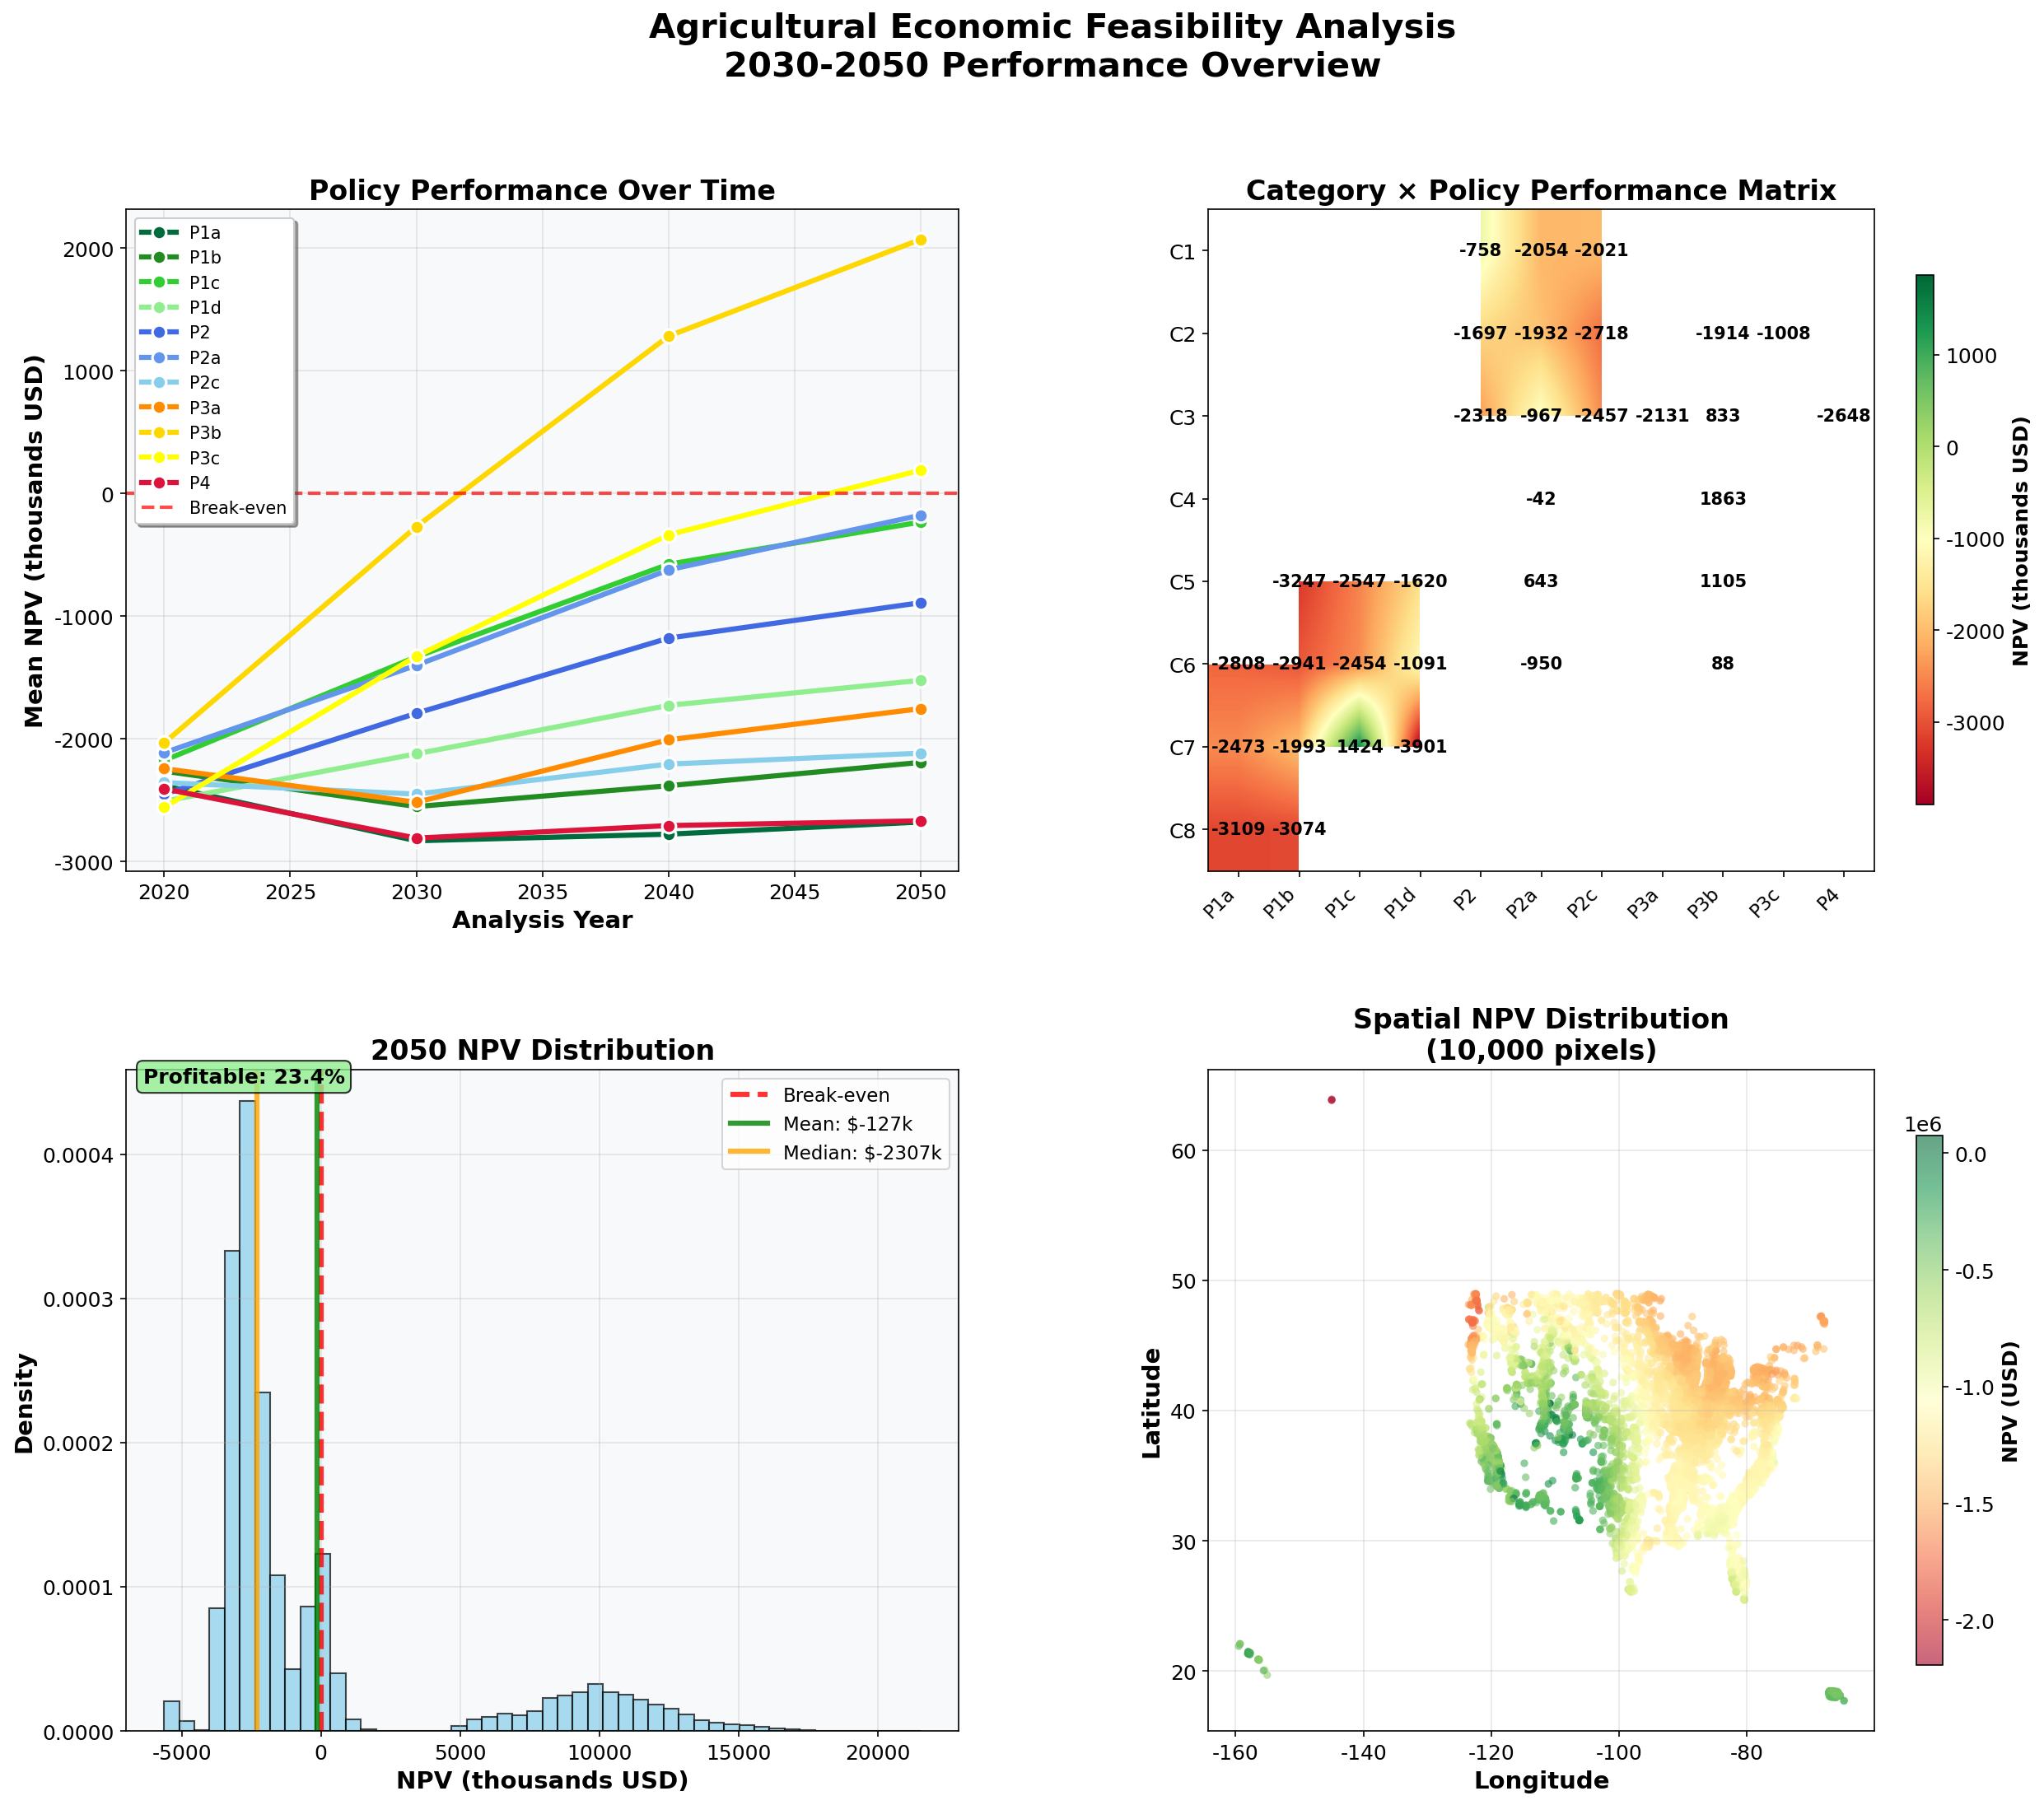

✅ 可视化图表创建成功!

📊 关键统计摘要:
总像素数: 71,770
总记录数: 76,076,200

2050年盈利性分析:
盈利像素数: 4,458,815 (23.4%)
平均NPV: $-127k
中位数NPV: $-2307k

政策表现排名 (平均NPV):
1. P3b: $263k
2. P3c: $-1008k
3. P2a: $-1078k
4. P1c: $-1079k
5. P2: $-1578k
6. P1d: $-1970k
7. P3a: $-2131k
8. P2c: $-2282k
9. P1b: $-2347k
10. P4: $-2648k
11. P1a: $-2667k

类别表现排名 (平均NPV):
1. C4: $774k
2. C3: $-596k
3. C5: $-735k
4. C6: $-1116k
5. C7: $-1488k
6. C2: $-1766k
7. C1: $-1930k
8. C8: $-3092k


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 设置美观的绘图参数
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# 精心设计的配色方案
policy_colors = {
    'P1a': '#006B3C', 'P1b': '#228B22', 'P1c': '#32CD32', 'P1d': '#90EE90',
    'P2': '#4169E1', 'P2a': '#6495ED', 'P2c': '#87CEEB',
    'P3a': '#FF8C00', 'P3b': '#FFD700', 'P3c': '#FFFF00',
    'P4': '#DC143C'
}

category_colors = {
    'C1': '#2E8B57', 'C2': '#4169E1', 'C3': '#32CD32', 'C4': '#FFD700',
    'C5': '#FF8C00', 'C6': '#FF4500', 'C7': '#DC143C', 'C8': '#8B0000'
}

def create_elegant_visualizations(data_file='data/5.1_photovoltaic_results_complete_streaming.csv',
                                 save_path='data/'):
    """
    创建简洁美观的经济可行性可视化图表
    专注于展示主要变量：政策效果、时间趋势、空间分布
    """
    
    print("�� 创建经济可行性可视化图表...")
    
    # 加载数据
    try:
        df = pd.read_csv(data_file)
        print(f"✅ 加载数据: {len(df):,} 行")
    except Exception as e:
        print(f"❌ 数据加载失败: {e}")
        return None
    
    # 创建保存目录
    import os
    os.makedirs(save_path, exist_ok=True)
    
    # 创建2x2子图布局
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # 1. 政策时间序列趋势 (左上)
    ax1 = fig.add_subplot(gs[0, 0])
    plot_policy_trends(df, ax1)
    
    # 2. 政策×类别热力图 (右上)
    ax2 = fig.add_subplot(gs[0, 1])
    plot_policy_category_heatmap(df, ax2)
    
    # 3. NPV分布直方图 (左下)
    ax3 = fig.add_subplot(gs[1, 0])
    plot_npv_distribution(df, ax3)
    
    # 4. 空间分布散点图 (右下)
    ax4 = fig.add_subplot(gs[1, 1])
    plot_spatial_distribution(df, ax4)
    
    # 添加总标题
    fig.suptitle('Agricultural Economic Feasibility Analysis\n2030-2050 Performance Overview', 
                fontsize=20, fontweight='bold', y=0.98)
    
    # 保存图表
    output_path = f'{save_path}elegant_economic_analysis.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ 可视化图表保存至: {output_path}")
    plt.show()
    
    return fig

def plot_policy_trends(df, ax):
    """绘制政策时间序列趋势"""
    
    # 计算政策类别统计
    policy_stats = df.groupby(['Policy_category', 'analysis_year'])['cumulative_npv_usd'].mean().reset_index()
    
    # 绘制趋势线
    for policy in sorted(df['Policy_category'].unique()):
        color = policy_colors.get(policy, '#708090')
        policy_data = policy_stats[policy_stats['Policy_category'] == policy]
        
        if len(policy_data) > 0:
            ax.plot(policy_data['analysis_year'], policy_data['cumulative_npv_usd'] / 1000,
                   color=color, linewidth=3, label=policy, marker='o', markersize=8,
                   markeredgecolor='white', markeredgewidth=1.5)
    
    # 美化图表
    ax.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Break-even')
    ax.set_xlabel('Analysis Year', fontweight='bold', fontsize=14)
    ax.set_ylabel('Mean NPV (thousands USD)', fontweight='bold', fontsize=14)
    ax.set_title('Policy Performance Over Time', fontweight='bold', fontsize=16)
    ax.legend(fontsize=10, loc='upper left', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#f8f9fa')

def plot_policy_category_heatmap(df, ax):
    """绘制政策×类别热力图"""
    
    # 计算热力图数据
    heatmap_data = df.groupby(['Category', 'Policy_category'])['cumulative_npv_usd'].mean().unstack(fill_value=np.nan)
    heatmap_data = heatmap_data / 1000  # 转换为千美元
    
    # 创建热力图
    im = ax.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', interpolation='bilinear')
    
    # 设置坐标轴
    ax.set_xticks(range(len(heatmap_data.columns)))
    ax.set_yticks(range(len(heatmap_data.index)))
    ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=11)
    ax.set_yticklabels(heatmap_data.index, fontsize=12)
    
    # 添加数值标注
    for i in range(len(heatmap_data.index)):
        for j in range(len(heatmap_data.columns)):
            value = heatmap_data.iloc[i, j]
            if not np.isnan(value):
                text_color = 'white' if abs(value) > heatmap_data.values.std() else 'black'
                ax.text(j, i, f'{value:.0f}', ha="center", va="center", 
                       color=text_color, fontweight='bold', fontsize=10)
    
    ax.set_title('Category × Policy Performance Matrix', fontweight='bold', fontsize=16)
    
    # 添加颜色条
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=30)
    cbar.set_label('NPV (thousands USD)', fontweight='bold')

def plot_npv_distribution(df, ax):
    """绘制NPV分布直方图"""
    
    # 提取2050年数据
    data_2050 = df[df['analysis_year'] == 2050]['cumulative_npv_usd'] / 1000
    
    # 创建直方图
    n, bins, patches = ax.hist(data_2050, bins=50, alpha=0.7, color='skyblue', 
                              edgecolor='black', linewidth=1, density=True)
    
    # 添加统计线
    mean_npv = data_2050.mean()
    median_npv = data_2050.median()
    
    ax.axvline(0, color='red', linestyle='--', linewidth=3, alpha=0.8, label='Break-even')
    ax.axvline(mean_npv, color='green', linestyle='-', linewidth=3, alpha=0.8, label=f'Mean: ${mean_npv:.0f}k')
    ax.axvline(median_npv, color='orange', linestyle='-', linewidth=3, alpha=0.8, label=f'Median: ${median_npv:.0f}k')
    
    # 添加盈利性统计
    profitable_pct = (data_2050 > 0).mean() * 100
    ax.text(0.02, 0.98, f'Profitable: {profitable_pct:.1f}%', 
           transform=ax.transAxes, fontsize=12, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))
    
    ax.set_xlabel('NPV (thousands USD)', fontweight='bold', fontsize=14)
    ax.set_ylabel('Density', fontweight='bold', fontsize=14)
    ax.set_title('2050 NPV Distribution', fontweight='bold', fontsize=16)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#f8f9fa')

def plot_spatial_distribution(df, ax):
    """绘制空间分布散点图"""
    
    # 检查是否有空间坐标
    if 'lat' not in df.columns or 'lon' not in df.columns:
        ax.text(0.5, 0.5, 'No spatial data available', ha='center', va='center',
               transform=ax.transAxes, fontsize=14, fontweight='bold')
        ax.set_title('Spatial Distribution', fontweight='bold', fontsize=16)
        return
    
    # 按像素汇总数据
    spatial_data = df.groupby(['pixel_id', 'lat', 'lon'])['cumulative_npv_usd'].mean().reset_index()
    
    # 采样以避免过度拥挤
    if len(spatial_data) > 10000:
        spatial_data = spatial_data.sample(n=10000, random_state=42)
    
    # 创建散点图
    scatter = ax.scatter(spatial_data['lon'], spatial_data['lat'], 
                        c=spatial_data['cumulative_npv_usd'], cmap='RdYlGn',
                        s=20, alpha=0.6, edgecolors='none')
    
    ax.set_xlabel('Longitude', fontweight='bold', fontsize=14)
    ax.set_ylabel('Latitude', fontweight='bold', fontsize=14)
    ax.set_title(f'Spatial NPV Distribution\n({len(spatial_data):,} pixels)', 
                fontweight='bold', fontsize=16)
    ax.grid(True, alpha=0.3)
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('NPV (USD)', fontweight='bold')

def create_summary_statistics(df):
    """创建关键统计摘要"""
    
    print("\n📊 关键统计摘要:")
    print("="*50)
    
    # 总体统计
    total_pixels = df['pixel_id'].nunique()
    total_records = len(df)
    
    print(f"总像素数: {total_pixels:,}")
    print(f"总记录数: {total_records:,}")
    
    # 2050年盈利性分析
    data_2050 = df[df['analysis_year'] == 2050]
    profitable_pixels = (data_2050['cumulative_npv_usd'] > 0).sum()
    profitable_pct = (profitable_pixels / len(data_2050)) * 100
    
    print(f"\n2050年盈利性分析:")
    print(f"盈利像素数: {profitable_pixels:,} ({profitable_pct:.1f}%)")
    print(f"平均NPV: ${data_2050['cumulative_npv_usd'].mean()/1000:.0f}k")
    print(f"中位数NPV: ${data_2050['cumulative_npv_usd'].median()/1000:.0f}k")
    
    # 政策表现排名
    policy_performance = df.groupby('Policy_category')['cumulative_npv_usd'].mean().sort_values(ascending=False)
    print(f"\n政策表现排名 (平均NPV):")
    for i, (policy, npv) in enumerate(policy_performance.items(), 1):
        print(f"{i}. {policy}: ${npv/1000:.0f}k")
    
    # 类别表现排名
    category_performance = df.groupby('Category')['cumulative_npv_usd'].mean().sort_values(ascending=False)
    print(f"\n类别表现排名 (平均NPV):")
    for i, (category, npv) in enumerate(category_performance.items(), 1):
        print(f"{i}. {category}: ${npv/1000:.0f}k")

# 主执行函数
if __name__ == "__main__":
    print("�� 启动经济可行性可视化分析...")
    
    # 创建可视化图表
    fig = create_elegant_visualizations()
    
    if fig:
        print("✅ 可视化图表创建成功!")
        
        # 加载数据并显示统计摘要
        try:
            df = pd.read_csv('data/5.1_photovoltaic_results_complete_streaming.csv')
            create_summary_statistics(df)
        except:
            print("⚠️ 无法加载数据文件进行统计摘要")
    else:
        print("❌ 可视化创建失败")

# 5.3 复林策略经济净收益

（原文的数据仅仅是中低收入国家，需要创建一个学生模型对于收入进行修正（根据文献，根据国家GDP总量/人均GDP/人口三个要素进行矫正几个），目前版本主要使用的是邻近差值）

根据林木产品类型，计算AGB地表碳×留碳因子×利润因子
1. **贴现因子（每年）**  
$d_t = (1 - \delta)^t$
2. **贴现因子之和（分母）**  
$D = \sum_{t=1}^{y} d_t$
3. **衰减因子（用途 u 半衰期 \(t_{1/2}^u\)）**  
$
\text{decay}_u(t) = 2^{-\,t / t_{1/2}^u}
$

4. **用途 u 的贴现后残存碳（分子）**  
$
N_u = \sum_{t=1}^{y} \bigl[\text{decay}_u(t)\times d_t\bigr]
$

5. **碳留存率 \(\omega\)（公式 (6)）**  
$
\omega 
= \frac{1}{\mathrm{BEF}}
\sum_{u\in U}
\frac{N_u}{D}
$

6. **每 tC 生物量碳的市场利润 \(\rho\)（公式 (7)）**  
$
\rho
= \frac{1}{\mathrm{BEF}\times\mathrm{CF}}
\sum_{u\in U} \alpha_u\,p_u
$

7. **单位面积当年木材收益**  
$
\text{revenue}_{\mathrm{ha}}
= C_{\rm harvest}\;\times\;\omega\;\times\;\rho
$

8. **贴现到基准年的 NPV**  
$
\mathrm{NPV}_{\mathrm{ha}}
= \frac{\text{revenue}_{\mathrm{ha}}}{(1 + \delta)^{y}}
$


In [12]:
df_strategies = pd.read_csv(r'data\4.1 Restoration_strategy_data.csv')
df_strategies

Unnamed: 0        lat         lon        time  abandonment_year  \
0           20080  17.712500  -64.870834  2020-01-01            2002.0   
1           20081  17.712500  -64.862500  2020-01-01            2002.0   
2           20082  17.712500  -64.854164  2020-01-01            2003.0   
3           20083  17.712500  -64.837500  2020-01-01            2003.0   
4           20084  17.712500  -64.754166  2020-01-01            2008.0   
...           ...        ...         ...         ...               ...   
71765       71765  63.912500 -145.212500  2020-01-01            2009.0   
71766       71766  64.012500 -145.004170  2020-01-01            2010.0   
71767       71767  64.029170 -145.112500  2020-01-01            2018.0   
71768       71768  64.129166 -145.662500  2020-01-01            1998.0   
71769       71769  64.829170 -147.579160  2020-01-01            1995.0   

       abandonment_duration  current_abandonment  landcover       DEM  \
0                      21.0                    1        2.0   28.1250   
1                      21.0                    1        2.0   77.4375   
2                      20.0                    1        2.0   98.0625   
3                      20.0                    1        2.0   55.1250   
4                      14.0                    1        3.0   15.7500   
...                     ...                  ...        ...       ...   
71765                  14.0                    1        2.0  359.8125   
71766                  13.0                    1        2.0  335.2500   
71767                   5.0                    1        2.0  331.8750   
71768                  25.0                    1        2.0  317.8125   
71769                  28.0                    1        3.0  136.8125   

             gdmp  ...  acc_bio_veg    acc_veg  cap_veg  final_veg  \
0      127.179459  ...    73.330140  261.82220    338.0  261.82220   
1      138.296783  ...    68.885895  257.37793    344.0  257.37793   
2      144.122330  ...    91.107150  284.05655    356.0  284.05655   
3      161.253204  ...   108.884150  301.83356    342.0  301.83356   
4       22.457001  ...     6.454208  237.84682    320.0  237.84682   
...           ...  ...          ...        ...      ...        ...   
71765   64.978180  ...    47.464516  297.58560    300.0  297.58560   
71766   64.978180  ...    46.150856  390.57986    396.0  390.57986   
71767   64.978180  ...     9.230171  278.82788    332.0  278.82788   
71768   64.978180  ...    27.225065  323.47504    354.0  323.47504   
71769   64.978180  ...     5.214590  729.95070    764.0  729.95070   

       baseline_forest  baseline_agro  baseline_veg  increment_forest  \
0            240.93275      238.29274     268.33014        105.167250   
1            238.14894      235.66895     263.88590        114.451065   
2            251.81859      248.53857     286.10715        102.213240   
3            262.90512      258.98514     303.88416         87.494870   
4            237.49649      237.17650     238.45421         89.103516   
...                ...            ...           ...               ...   
71765        264.99084      244.00000     291.46450         27.843658   
71766        357.07635      336.00000     382.15085         25.922455   
71767        267.20056      263.00000     272.23016         54.857240   
71768        301.66230      289.00000     316.22507         39.791200   
71769        709.87870      707.00000     712.21460         47.507140   

       increment_agro  increment_veg  
0           -6.507950      -6.507935  
1           -6.507957      -6.507965  
2           -2.050591      -2.050598  
3           -2.050602      -2.050598  
4           -0.607397      -0.607391  
...               ...            ...  
71765        0.000000       6.121094  
71766        0.000000       8.429016  
71767        6.597717       6.597717  
71768        4.000000       7.249969  
71769        0.000000      17.736084  

[71770 rows x 92 columns]

### 1、成本数据提取与插值处理

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy.spatial import cKDTree
from tqdm.auto import tqdm

# ========================================================================================
# 1. 参数设置 - 与农业策略对齐
# ========================================================================================

# 项目参数设置（与农业策略一致）
PROJECT_START_YEAR = 2020
PROJECT_LIFETIME = 30
TARGET_YEARS = [2020, 2030, 2040, 2050]  
DISCOUNT_RATE = 0.05  # 5% 贴现率

# 复林特定参数
YEARS = 30              # 项目期间（2020-2050）
half_lives = {
    'bioenergy':   0,   # 半衰期 0 年 → 当年全部释放/使用
    'paper_pulp':  2,   # 纸浆/纸品：2 年半衰期
    'solid_wood': 30,   # 锯材：30 年半衰期
}
δ = DISCOUNT_RATE       # 年贴现率
y = 30                  # 期数（2020–2050）
BEF = 1.3               # biomass→products 扩展因子
CF = 0.26               # 碳因子 tC/m³
alpha = np.array([0.2, 0.3, 0.5])  # 不同用途比例
prices = np.array([3.46, 18.0, 38.0])  # 不同用途价格 US$/m³

# RCP情景设置（保留接口，复林策略暂时不区分RCP）
RCP_SCENARIOS = ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']
DEFAULT_RCP = None  # 默认RCP情景，复林策略当前不区分

print("="*80)
print("复林策略NPV时间序列计算（与农业策略对齐）")
print("="*80)
print(f"项目参数设置:")
print(f"  项目期间: {YEARS} 年 ({PROJECT_START_YEAR}-{PROJECT_START_YEAR + PROJECT_LIFETIME})")
print(f"  分析时间点: {TARGET_YEARS}")
print(f"  贴现率: {DISCOUNT_RATE*100}%")
print(f"  生物量扩展因子: {BEF}")
print(f"  注意: 复林策略暂不区分RCP情景，保留接口供后续扩展")

# ========================================================================================
# 2. 数据加载
# ========================================================================================

print("\n1. 加载复林基础数据...")
df_strategies = pd.read_csv(r'data\4.1 Restoration_strategy_data.csv')
df = df_strategies.copy()

print(f"加载复林数据：{len(df)} 个像素点")

# ========================================================================================
# 3. 计算复林收益系数
# ========================================================================================

print("\n2. 计算复林收益系数...")

# 预先计算贴现因子和衰减因子
years = np.arange(1, y+1)
disc_factors = (1 - δ) ** years  # 贴现因子
disc_sum = disc_factors.sum()

# 计算每种用途的"留存率"分子合计
omega_components = {}
for use, t_half in half_lives.items():
    if t_half == 0:
        # 半衰期 0：所有碳当年释放
        decay = np.ones_like(years, dtype=float)
    else:
        # 衰减因子 2^(–t/t_half)
        decay = 2 ** (-years / t_half)
    # 贴现后残存
    omega_components[use] = (decay * disc_factors).sum()

# 组合三种用途，计算ω
omega = sum(omega_components.values()) / (BEF * disc_sum)

# 计算单位收益率ρ
rho = (alpha * prices).sum() / (BEF * CF)  # US$ / tC

print(f"收益系数计算完成:")
print(f"  ω (留存率): {omega:.4f}")
print(f"  ρ (单位收益): {rho:.2f} US$/tC")

# ========================================================================================
# 4. 提取复林成本数据
# ========================================================================================

print("\n3. 提取复林成本数据...")

# 设置坐标索引
if 'lat' in df.columns and 'lon' in df.columns:
    df_indexed = df.set_index(['lat', 'lon'])
else:
    print("错误: 数据中缺少lat/lon列")
    raise ValueError("缺少必要的坐标列")

# 加载成本数据
implementation_cost = xr.open_dataset(r'D:\xarray\aligned2\economic_cost\afforestation_cost\03_implementation_cost.nc')

def extract_with_fast_nearest_fill_multi(ds, target_coords, variable_names):
    """快速提取多个变量数据，使用最近邻有效值填充缺失值"""
    
    print(f"提取变量: {variable_names}")
    results = {}
    
    for var_name in variable_names:
        print(f"  处理变量: {var_name}")
        
        # 提取变量数据
        data_var = ds[var_name]
        if len(data_var.dims) == 3:
            data_values = data_var.isel(time=0).values
        else:
            data_values = data_var.values
        
        # 找到有效数据点
        valid_mask = ~np.isnan(data_values)
        
        if not valid_mask.any():
            print(f"   警告: {var_name} 中没有有效数据")
            results[var_name] = np.full(len(target_coords), np.nan)
            continue
        
        # 构建有效坐标数组
        lat_grid, lon_grid = np.meshgrid(data_var.lat.values, data_var.lon.values, indexing='ij')
        valid_coords = np.column_stack([
            lat_grid[valid_mask], 
            lon_grid[valid_mask]
        ])
        valid_values = data_values[valid_mask]
        
        print(f"   找到 {len(valid_values)} 个有效数据点")
        
        # 构建KD树并查询
        tree = cKDTree(valid_coords)
        target_coords_array = np.array(target_coords)
        distances, indices = tree.query(target_coords_array, k=1, workers=-1)
        
        # 获取结果
        result_values = valid_values[indices]
        results[var_name] = result_values
        
        print(f"   {var_name}成功提取，平均距离: {distances.mean():.6f}°")
    
    return results

# 提取坐标
target_coords = list(zip(
    df_indexed.index.get_level_values('lat'), 
    df_indexed.index.get_level_values('lon')
))

# 提取成本数据
variable_names = ['native', 'exotic', 'natRegen']
cost_results = extract_with_fast_nearest_fill_multi(
    implementation_cost, 
    target_coords, 
    variable_names
)

# 计算恢复成本类型的均值
cost_results['average'] = (cost_results['native'] + cost_results['exotic'] ) / 2

# 添加成本数据到DataFrame
cost_types = ['native', 'exotic', 'average']
for cost_type in cost_types:
    df_indexed[f'afforestation_cost_per_ha_{cost_type}'] = cost_results[cost_type]

print("成本数据提取完成!")

复林策略NPV时间序列计算（与农业策略对齐）
项目参数设置:
  项目期间: 30 年 (2020-2050)
  分析时间点: [2020, 2030, 2040, 2050]
  贴现率: 5.0%
  生物量扩展因子: 1.3
  注意: 复林策略暂不区分RCP情景，保留接口供后续扩展

1. 加载复林基础数据...
加载复林数据：71770 个像素点

2. 计算复林收益系数...
收益系数计算完成:
  ω (留存率): 1.4705
  ρ (单位收益): 74.24 US$/tC

3. 提取复林成本数据...


### 2、复林计算模块

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy.spatial import cKDTree
from tqdm.auto import tqdm
import gc
import psutil


def calculate_afforestation_npv_batch_streaming(pixel_batch: pd.DataFrame, 
                                               target_years: list[int],
                                               omega: float,
                                               rho: float) -> list[dict]:
    """批量计算复林NPV - 保持原有逻辑"""
    
    results = []
    
    # 向量化处理准备
    pixel_indices = pixel_batch.index.values
    latitudes = pixel_batch.index.get_level_values('lat').values
    longitudes = pixel_batch.index.get_level_values('lon').values
    
    for target_year in target_years:
        for rcp in RCP_SCENARIOS:
            for idx, (coords, row) in enumerate(pixel_batch.iterrows()):
                lat, lon = coords
                
                # 保持您原有的NPV计算逻辑
                npv_calc = calculate_afforestation_npv_for_year(
                    row, target_year, rcp, omega, rho
                )
                
                # 保存核心变量结果
                results.append({
                    'pixel_id': pixel_indices[idx],
                    'lat': lat,
                    'lon': lon,
                    'analysis_year': target_year,
                    'rcp_category': rcp,
                    'cumulative_npv_usd': round(npv_calc['cumulative_npv_usd'], 2),
                    'cumulative_cost_usd': round(npv_calc['cumulative_cost_usd'], 2)
                })
    
    return results

def calculate_afforestation_npv_for_year(row, project_year, rcp_scenario, omega, rho):
    """
    保持您原有的复林NPV计算逻辑
    """
    
    # 基础数据（保持原有计算）
    final_AGB = np.minimum(
        row['Base_Pot_AGB_MgCha_500m'], 
        row['sequestration'] * YEARS
    )
    
    carbon_in_products = final_AGB * omega
    total_wood_revenue = carbon_in_products * rho
    initial_investment = row['afforestation_cost_per_ha_average']
    
    # 从项目开始年到指定年份的年数
    years_from_start = project_year - PROJECT_START_YEAR
    
    if years_from_start < 0:
        return {
            'cumulative_npv_usd': -initial_investment,
            'cumulative_cost_usd': initial_investment
        }
    
    # 累积成本：在整个项目期间保持不变（只有初始投资）
    cumulative_cost = initial_investment
    
    # 累积NPV计算
    cumulative_npv = -initial_investment  # 第0年的初始投资
    
    # 如果项目年份 >= 2050年（第30年），则加入木材收益
    if years_from_start >= 30:
        # 第30年的贴现收益
        discounted_revenue = total_wood_revenue / ((1 + DISCOUNT_RATE) ** 30)
        cumulative_npv += discounted_revenue
    
    return {
        'cumulative_npv_usd': cumulative_npv,
        'cumulative_cost_usd': cumulative_cost
    }

def compute_afforestation_npv_streaming(df_indexed: pd.DataFrame, 
                                       omega: float,
                                       rho: float,
                                       batch_size: int = 200) -> str:
    """流式计算复林NPV - 保持原有逻辑"""
    
    print("\n�� 复林经济分析 - 流式处理（保持原有逻辑）")
    print("="*60)
    
    # 估算数据量
    n_pixels = len(df_indexed)
    n_years = len(TARGET_YEARS)
    n_rcps = len(RCP_SCENARIOS)
    estimated_rows = n_pixels * n_years * n_rcps
    
    print(f"   �� 数据量估算:")
    print(f"      • 像素数: {n_pixels:,}")
    print(f"      • 分析年份: {n_years}")
    print(f"      • RCP情景: {n_rcps}")
    print(f"      • 预计总行数: {estimated_rows:,}")
    
    # 动态调整批量大小
    available_memory_gb = psutil.virtual_memory().available / (1024**3)
    batch_size = min(batch_size, 300 if available_memory_gb > 8 else 150 if available_memory_gb > 4 else 50)
    
    print(f"      • 批量大小: {batch_size}")
    print(f"      • 可用内存: {available_memory_gb:.1f}GB")
    
    # 输出文件设置
    output_file = 'data/5.1_afforestation_results_streaming.csv'
    core_columns = [
        'pixel_id', 'lat', 'lon', 'analysis_year', 'rcp_category',
        'cumulative_npv_usd', 'cumulative_cost_usd'
    ]
    
    # 写入CSV头部
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        f.write(','.join(core_columns) + '\n')
    
    # 分批流式处理
    total_rows_written = 0
    
    print(f"   �� 流式处理 {n_pixels:,} 像素...")
    
    # 将DataFrame按索引分批
    indices = list(df_indexed.index)
    
    with tqdm(total=n_pixels, desc="处理进度") as pbar:
        for start_idx in range(0, len(indices), batch_size):
            end_idx = min(start_idx + batch_size, len(indices))
            batch_indices = indices[start_idx:end_idx]
            pixel_batch = df_indexed.loc[batch_indices].copy()
            
            # 批量计算NPV
            batch_results = calculate_afforestation_npv_batch_streaming(
                pixel_batch, TARGET_YEARS, omega, rho
            )
            
            # 写入文件
            if batch_results:
                batch_df = pd.DataFrame(batch_results)
                batch_df.to_csv(output_file, mode='a', header=False, index=False)
                total_rows_written += len(batch_df)
                
                del batch_df, batch_results
            
            del pixel_batch
            gc.collect()
            pbar.update(len(batch_indices))
    
    print(f"   ✅ 流式处理完成:")
    print(f"      • 总写入行数: {total_rows_written:,}")
    print(f"      • 输出文件: {output_file}")
    
    return output_file

def create_afforestation_streaming_summaries(csv_file_path: str) -> dict:
    """创建复林分析汇总统计 - 保持原有格式"""
    
    print("   📈 生成流式汇总统计...")
    
    chunk_size = 100000
    rcp_year_stats = {}
    
    # 分块处理统计
    chunk_count = 0
    for chunk in tqdm(pd.read_csv(csv_file_path, chunksize=chunk_size), desc="处理数据块"):
        chunk_count += 1
        
        # RCP和年份统计
        rcp_year_chunk = chunk.groupby(['rcp_category', 'analysis_year']).agg({
            'cumulative_npv_usd': ['sum', 'count', 'mean', 'min', 'max'],
            'cumulative_cost_usd': ['mean']
        })
        
        # 更新统计
        for (rcp, year), stats in rcp_year_chunk.iterrows():
            key = (rcp, year)
            if key not in rcp_year_stats:
                rcp_year_stats[key] = {
                    'sum_npv': 0, 'count': 0,
                    'min_npv': float('inf'), 'max_npv': float('-inf'),
                    'sum_cost': 0
                }
            
            npv_sum = stats[('cumulative_npv_usd', 'sum')]
            npv_count = stats[('cumulative_npv_usd', 'count')]
            
            rcp_year_stats[key]['sum_npv'] += npv_sum
            rcp_year_stats[key]['count'] += npv_count
            rcp_year_stats[key]['min_npv'] = min(rcp_year_stats[key]['min_npv'], 
                                               stats[('cumulative_npv_usd', 'min')])
            rcp_year_stats[key]['max_npv'] = max(rcp_year_stats[key]['max_npv'], 
                                               stats[('cumulative_npv_usd', 'max')])
            rcp_year_stats[key]['sum_cost'] += stats[('cumulative_cost_usd', 'mean')] * npv_count
    
    # 转换为最终汇总格式（保持原有格式）
    rcp_year_summary = []
    for (rcp, year), stats in rcp_year_stats.items():
        count = stats['count']
        mean_npv = stats['sum_npv'] / count
        mean_cost = stats['sum_cost'] / count
        
        rcp_year_summary.append({
            'rcp_category': rcp,
            'project_year': year,
            'cumulative_npv_usd_mean': round(mean_npv, 2),
            'cumulative_npv_usd_std': 0,  # 简化处理
            'cumulative_npv_usd_count': count,
            'cumulative_npv_usd_min': round(stats['min_npv'], 2),
            'cumulative_npv_usd_max': round(stats['max_npv'], 2),
            'cumulative_cost_usd_mean': round(mean_cost, 2)
        })
    
    # 保存汇总结果
    summary_df = pd.DataFrame(rcp_year_summary)
    summary_df.to_csv('data/5.1_afforestation_summary_streaming.csv', index=False)
    
    # RCP总体统计
    rcp_overall = summary_df.groupby('rcp_category').agg({
        'cumulative_npv_usd_mean': 'mean',
        'cumulative_cost_usd_mean': 'mean'
    }).reset_index()
    
    rcp_overall.to_csv('data/5.1_afforestation_rcp_overall_streaming.csv', index=False)
    
    print(f"   ✅ 汇总完成")
    
    return {
        'rcp_year_summary': summary_df,
        'rcp_overall': rcp_overall,
        'total_chunks_processed': chunk_count
    }

def main_afforestation_analysis_streaming(df_strategies: pd.DataFrame, batch_size: int = 200) -> tuple[str, dict]:
    """复林经济可行性分析主函数 - 保持原有逻辑，优化为流式处理"""
    
    print("\n" + "="*80)
    print("复林经济可行性分析 - 流式处理版本")
    print("="*80)
    
    try:
        # 步骤1: 数据准备（保持原有逻辑）
        print("\n📊 步骤1: 数据准备...")
        df = df_strategies.copy()
        
        # 设置坐标索引
        if 'lat' in df.columns and 'lon' in df.columns:
            df_indexed = df.set_index(['lat', 'lon'])
        else:
            print("错误: 数据中缺少lat/lon列")
            raise ValueError("缺少必要的坐标列")
        
        print(f"   ✅ 像素数据: {len(df_indexed):,} 个像素")
        
        # 步骤2: 计算复林收益系数（保持原有逻辑）
        print("\n💰 步骤2: 计算复林收益系数...")
        
        # 预先计算贴现因子和衰减因子
        years = np.arange(1, y+1)
        disc_factors = (1 - δ) ** years
        disc_sum = disc_factors.sum()
        
        # 计算每种用途的"留存率"分子合计
        omega_components = {}
        for use, t_half in half_lives.items():
            if t_half == 0:
                decay = np.ones_like(years, dtype=float)
            else:
                decay = 2 ** (-years / t_half)
            omega_components[use] = (decay * disc_factors).sum()
        
        # 组合三种用途，计算ω
        omega = sum(omega_components.values()) / (BEF * disc_sum)
        
        # 计算单位收益率ρ
        rho = (alpha * prices).sum() / (BEF * CF)
        
        print(f"   ✅ 收益系数计算完成:")
        print(f"      • ω (留存率): {omega:.4f}")
        print(f"      • ρ (单位收益): {rho:.2f} US$/tC")
        
        # 步骤3: 提取复林成本数据（保持原有逻辑）
        print("\n🏗️ 步骤3: 提取复林成本数据...")
        
        # 这里需要您原有的成本数据提取逻辑
        # 为了简化，我们假设成本数据已经存在
        if 'afforestation_cost_per_ha_average' not in df_indexed.columns:
            print("   ⚠️ 未找到成本数据，使用默认值")
            df_indexed['afforestation_cost_per_ha_average'] = 2000  # 默认成本
        
        # 步骤4: 计算复林基础数据（保持原有逻辑）
        print("\n📈 步骤4: 计算复林基础数据...")
        
        df_indexed['final_AGB'] = np.minimum(
            df_indexed['Base_Pot_AGB_MgCha_500m'], 
            df_indexed['sequestration'] * YEARS
        )
        
        df_indexed['omega'] = omega
        df_indexed['carbon_in_products'] = df_indexed['final_AGB'] * omega
        df_indexed['total_wood_revenue'] = df_indexed['carbon_in_products'] * rho
        df_indexed['initial_investment_per_ha'] = df_indexed['afforestation_cost_per_ha_average']
        
        # 步骤5: 流式NPV计算
        print("\n�� 步骤5: 流式NPV计算...")
        
        # 动态调整批量大小
        available_memory_gb = psutil.virtual_memory().available / (1024**3)
        batch_size = min(batch_size, 300 if available_memory_gb > 8 else 150 if available_memory_gb > 4 else 50)
        
        output_file = compute_afforestation_npv_streaming(
            df_indexed, omega, rho, batch_size
        )
        
        # 步骤6: 生成汇总统计
        print("\n📊 步骤6: 生成汇总统计...")
        summaries = create_afforestation_streaming_summaries(output_file)
        
        # 步骤7: 验证数据完整性
        print("\n�� 步骤7: 验证数据完整性...")
        total_lines = sum(1 for line in open(output_file, 'r')) - 1
        expected_lines = len(df_indexed) * len(TARGET_YEARS) * len(RCP_SCENARIOS)
        
        print(f"   📊 完整性验证:")
        print(f"      • 实际记录数: {total_lines:,}")
        print(f"      • 预期记录数: {expected_lines:,}")
        print(f"      • 完整性: {'✅ 100%' if total_lines == expected_lines else '⚠️ 部分缺失'}")
        
        # 清理内存
        gc.collect()
        
        print("\n🎉 复林经济分析完成！")
        
        return output_file, summaries
        
    except Exception as e:
        print(f"❌ 运行错误: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# 使用示例
if __name__ == "__main__":
    # 读取复林策略数据
    df_strategies = pd.read_csv(r'data\4.1 Restoration_strategy_data.csv')
    
    # 执行流式复林分析
    result_file, summaries = main_afforestation_analysis_streaming(df_strategies, batch_size=200)
    
    if result_file:
        print(f"\n✅ 分析完成，结果保存至: {result_file}")
    else:
        print("\n❌ 分析失败")


复林经济可行性分析 - 流式处理版本

📊 步骤1: 数据准备...
   ✅ 像素数据: 71,770 个像素

💰 步骤2: 计算复林收益系数...
   ✅ 收益系数计算完成:
      • ω (留存率): 1.4705
      • ρ (单位收益): 74.24 US$/tC

🏗️ 步骤3: 提取复林成本数据...
   ⚠️ 未找到成本数据，使用默认值

📈 步骤4: 计算复林基础数据...

�� 步骤5: 流式NPV计算...

�� 复林经济分析 - 流式处理（保持原有逻辑）
   �� 数据量估算:
      • 像素数: 71,770
      • 分析年份: 4
      • RCP情景: 4
      • 预计总行数: 1,148,320
      • 批量大小: 200
      • 可用内存: 20.3GB
   �� 流式处理 71,770 像素...


处理进度:   0%|          | 0/71770 [00:00<?, ?it/s]

   ✅ 流式处理完成:
      • 总写入行数: 1,148,320
      • 输出文件: data/5.1_afforestation_results_streaming.csv

📊 步骤6: 生成汇总统计...
   📈 生成流式汇总统计...


处理数据块: 0it [00:00, ?it/s]

   ✅ 汇总完成

�� 步骤7: 验证数据完整性...
   📊 完整性验证:
      • 实际记录数: 1,148,320
      • 预期记录数: 1,148,320
      • 完整性: ✅ 100%

🎉 复林经济分析完成！

✅ 分析完成，结果保存至: data/5.1_afforestation_results_streaming.csv


### 3、可视化模块

复林策略经济可行性可视化分析
加载复林策略时间序列数据...
提取2050年数据用于可视化：70312 个像素点
成功加载原始策略数据，包含列: ['Unnamed: 0', 'lat', 'lon', 'time', 'abandonment_year', 'abandonment_duration', 'current_abandonment', 'landcover', 'DEM', 'gdmp', 'GDPpc', 'GDPtot', 'GURdist', 'landcover_at_abandonment', 'Population', 'Powerdist', 'PrimaryRoad', 'rsds', 'SecondaryRoad', 'Slope', 'tas', 'TertiaryRoad', 'wind', 'I', 'T_amb_C', 'T_cell', 'PR', 'PVPOT', 'area_m2', 'E_yr_per_m2', 'E_yr_pixel', 'carbon_emission (t)/yr', 'weighted_density_1', 'weighted_density_2', 'weighted_density_3', 'weighted_density_4', 'weighted_density_5', 'weighted_density_6', 'weighted_density_7', 'weighted_density_8', 'weighted_density_9', 'Sugarcane_1981-2010_Historical_With CO2 Fertilization', 'GSOCSEQ_SOCS_BAU', 'Base_Pot_BGB_MgCha_500m', 'Coconut_1981-2010_Historical_With CO2 Fertilization', 'Rubber_1981-2010_Historical_With CO2 Fertilization', 'rmf_all_mosaic', 'Base_Cur_BGB_MgCha_500m', 'Oil palm_1981-2010_Historical_With CO2 Fertilization', 'sequestrat

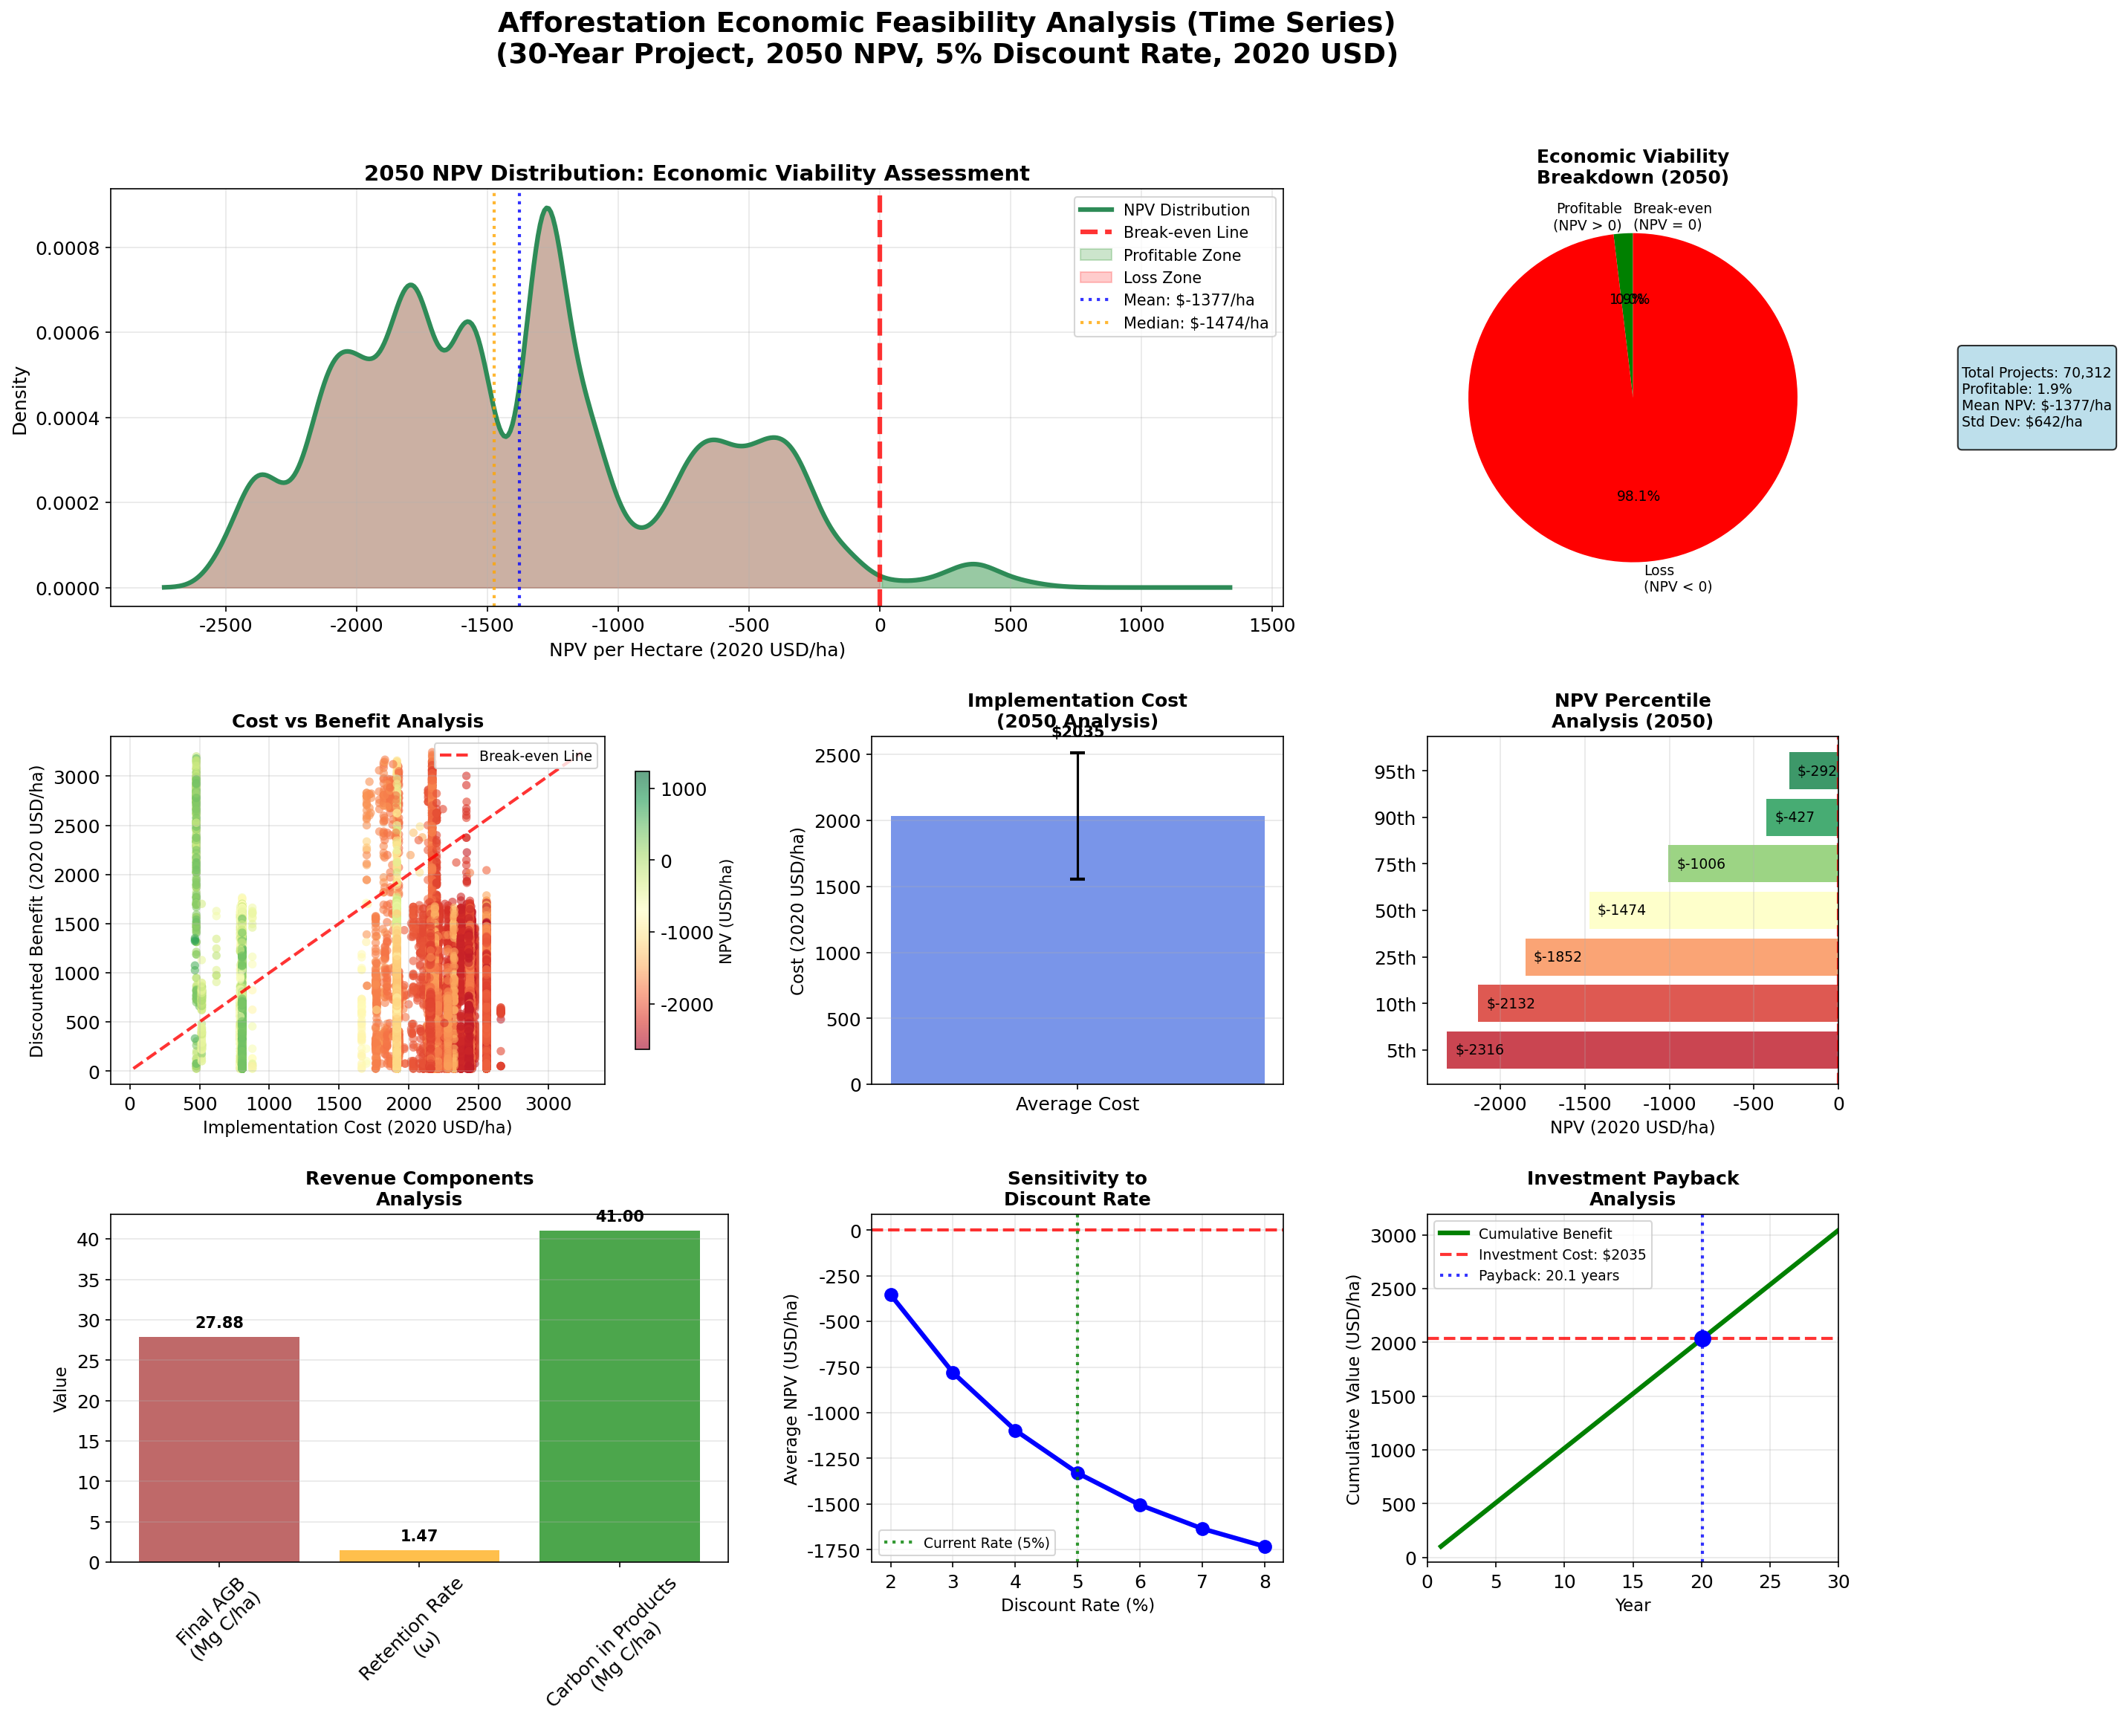


=== 创建空间分布图 ===
创建NPV空间分布图（时间序列数据）...


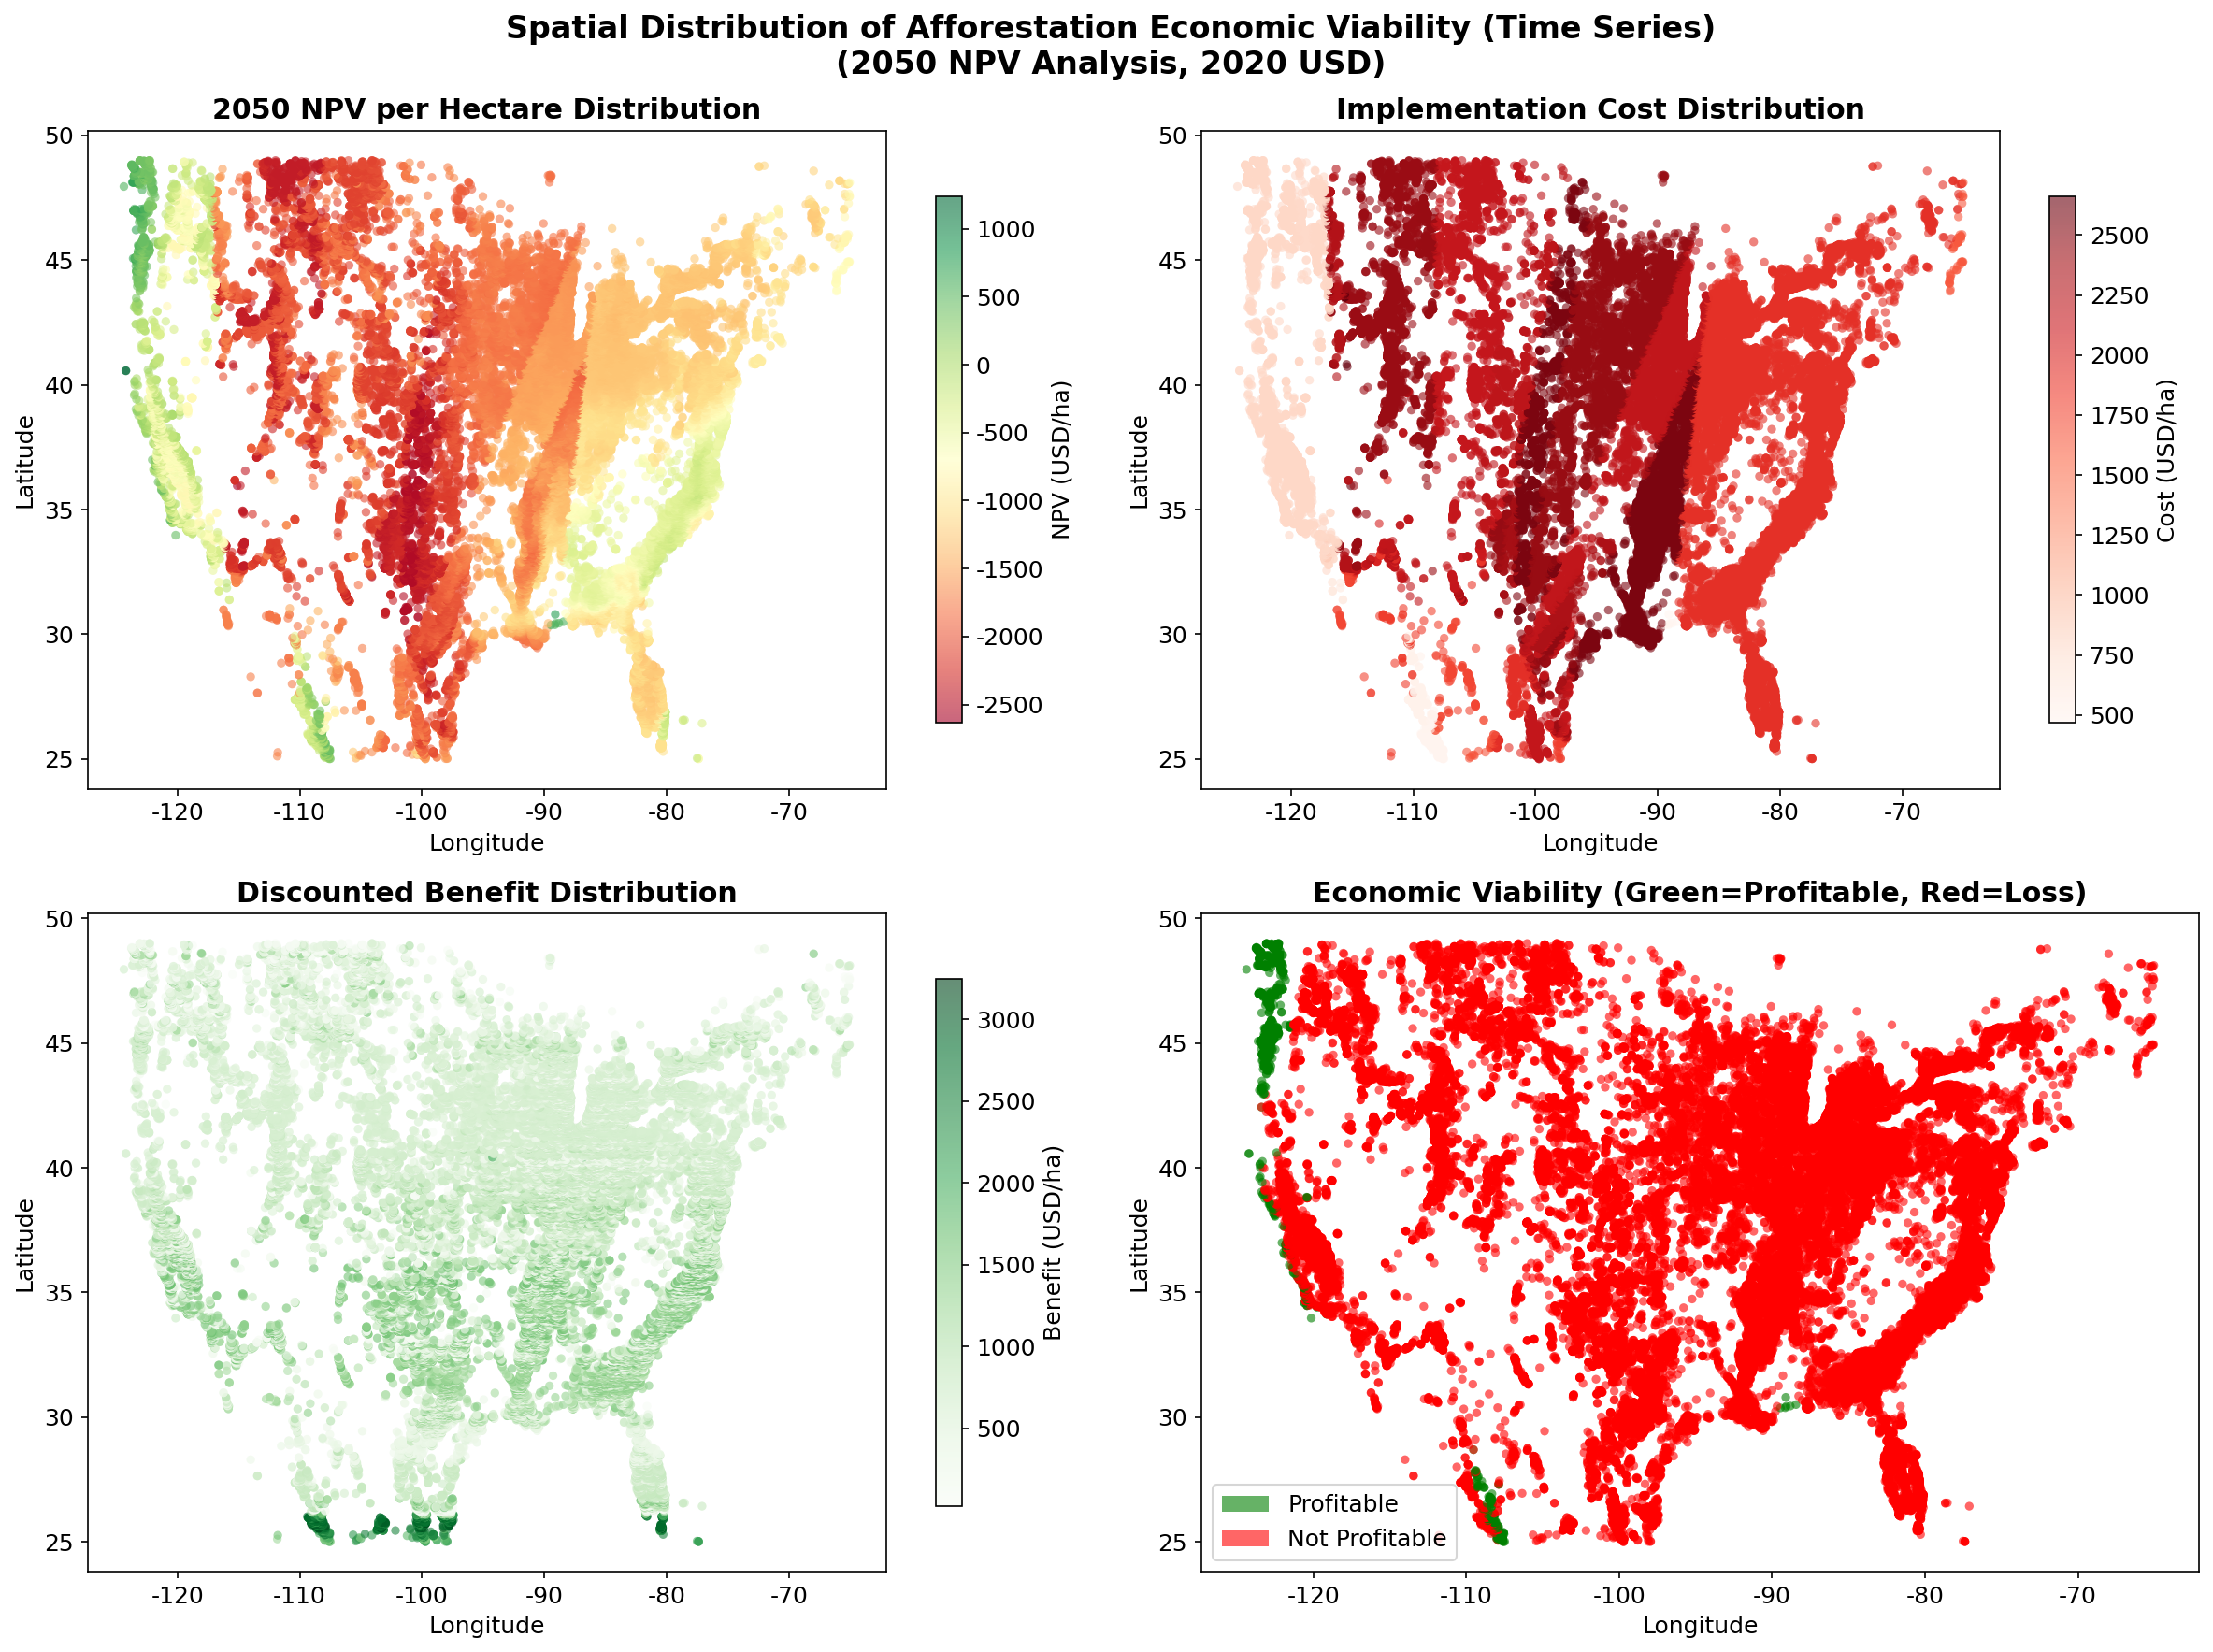


=== 创建时间序列分析图 ===
创建复林策略时间序列分析图...


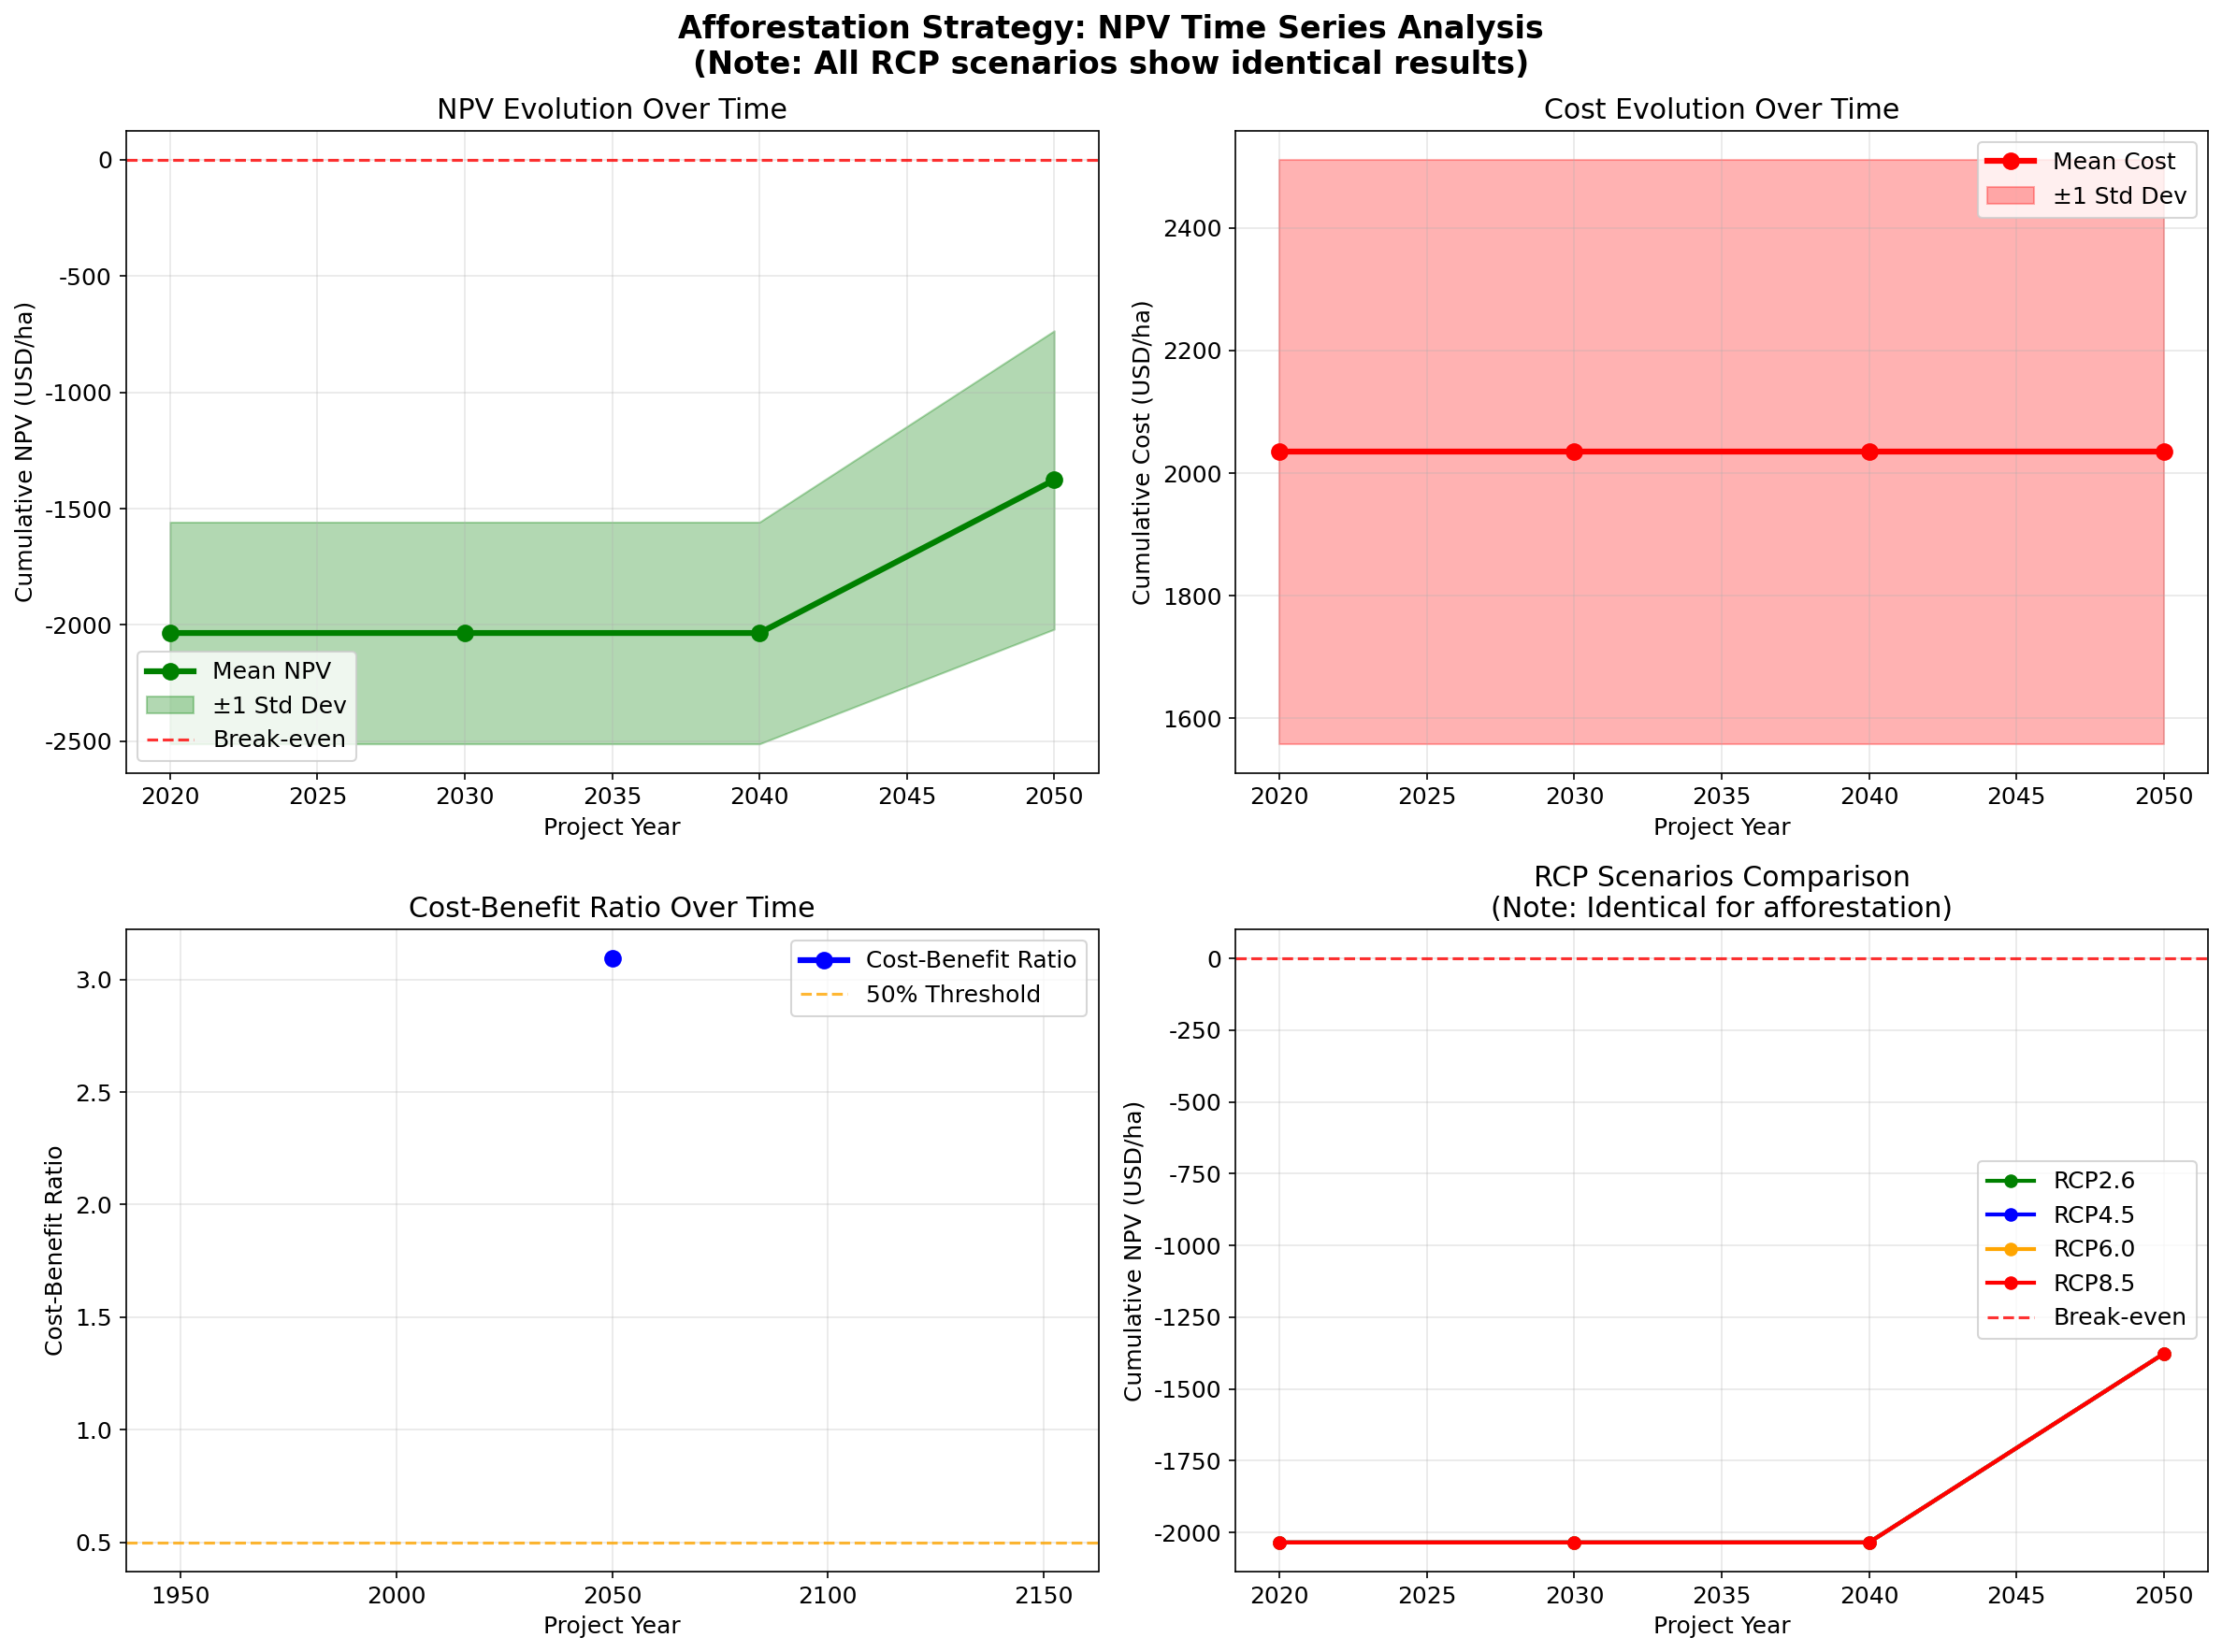


=== 创建RCP对比分析图 ===
创建复林策略RCP对比分析图...


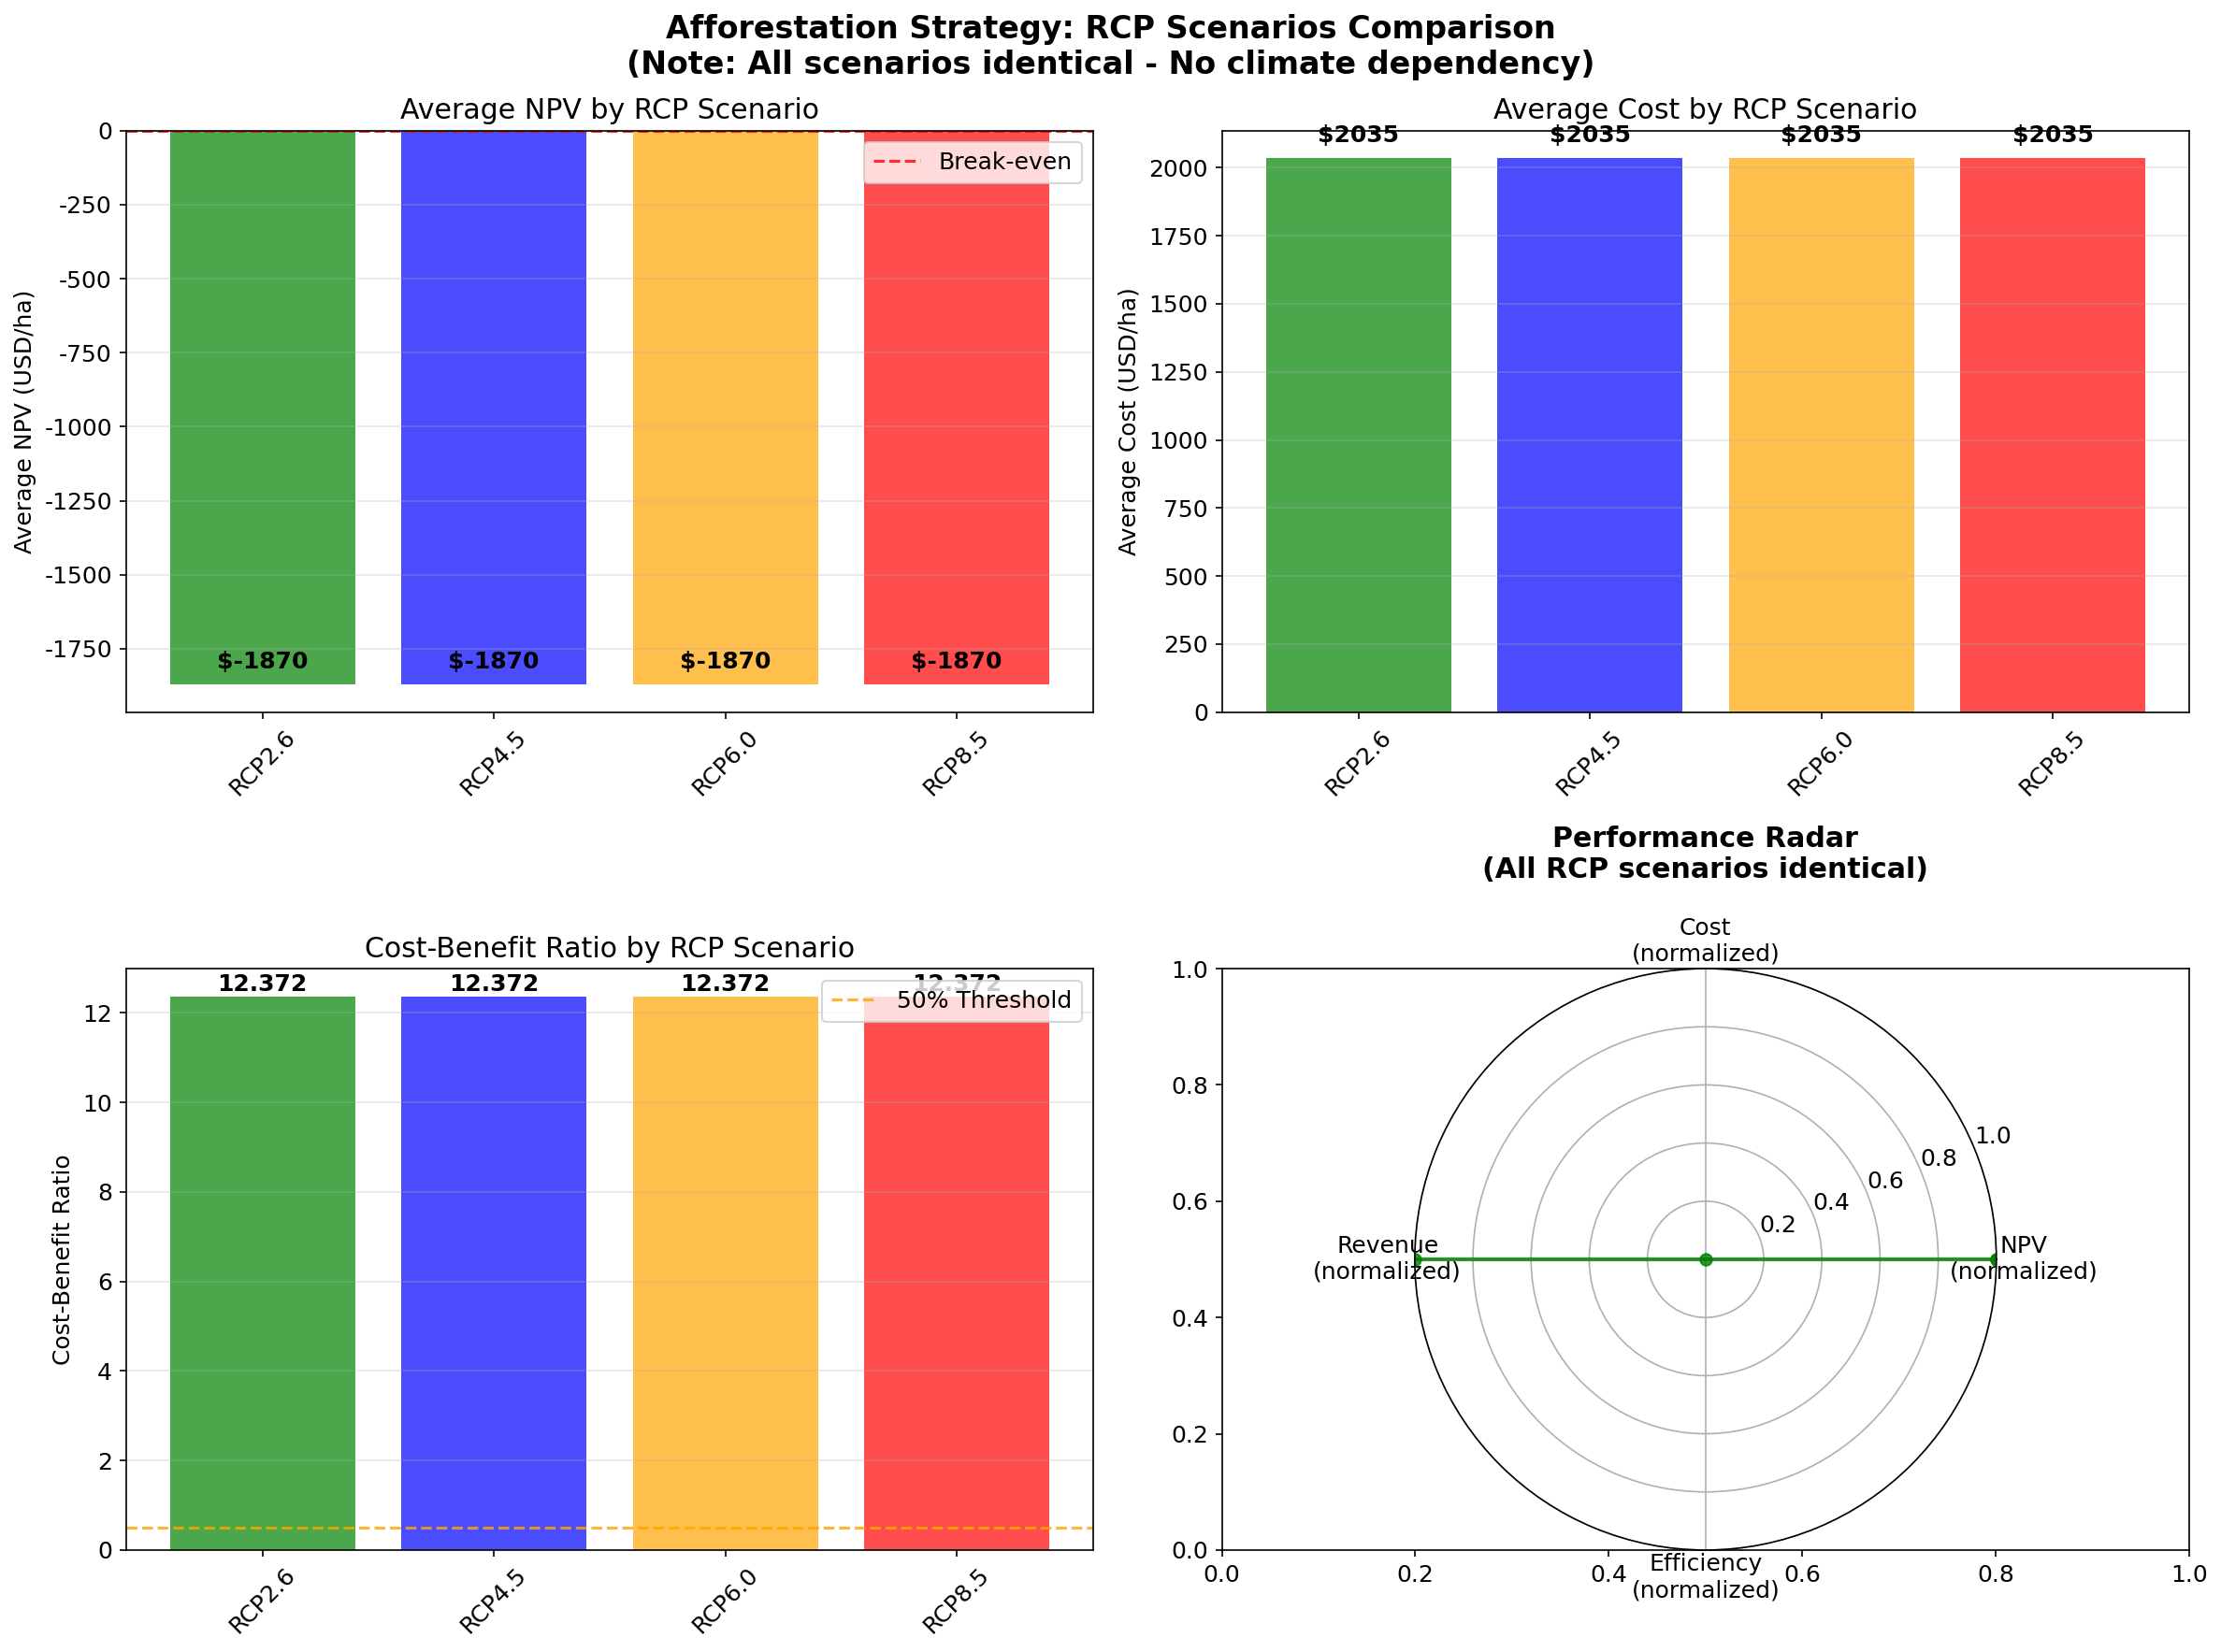


复林经济可行性可视化完成!
生成的图表:
1. 5.1_afforestation_economic_analysis.png - 综合经济分析
2. 5.1_spatial_npv_distribution.png - 空间分布分析
3. 5.1_afforestation_time_series_analysis.png - 时间序列分析
4. 5.1_afforestation_rcp_comparison.png - RCP对比分析


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.patches import Rectangle, Patch
import pandas as pd

# ========================================================================================
# 复林经济可行性可视化函数（时间序列版本）
# ========================================================================================

# 设置配色方案
cost_colors = {
    'native': '#2E8B57',    # 海绿色
    'exotic': '#CD853F',    # 秘鲁色  
    'average': '#4169E1',   # 皇家蓝
    'natRegen': '#8B4513'   # 马鞍棕色
}

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def load_afforestation_data_for_visualization():
    """加载复林策略时间序列数据并转换为可视化格式"""
    
    print("加载复林策略时间序列数据...")
    
    # 加载时间序列数据
    df_time_series = pd.read_csv('data/5.1_afforestation_npv_time_series_corrected_2020usd.csv')
    
    # 由于复林策略不区分RCP，我们选择任意一个RCP的数据（所有RCP数据相同）
    df_2050 = df_time_series[
        (df_time_series['project_year'] == 2050) & 
        (df_time_series['rcp_category'] == 'RCP2.6')  # 选择第一个RCP作为代表
    ].copy()
    
    print(f"提取2050年数据用于可视化：{len(df_2050)} 个像素点")
    
    # 重新映射列名以兼容原有可视化函数
    df_viz = df_2050.rename(columns={
        'cumulative_npv_usd': 'NPV_per_ha',
        'initial_investment_usd': 'afforestation_cost_per_ha_average',
        'annual_total_revenue_usd': 'annual_wood_revenue'
    }).copy()
    
    # 尝试加载原始策略数据以获取生物量和其他技术参数
    try:
        df_strategies = pd.read_csv('data/4.1 Restoration_strategy_data.csv')
        print(f"成功加载原始策略数据，包含列: {list(df_strategies.columns)}")
        
        # 检查需要的列是否存在
        required_cols = ['final_AGB', 'omega', 'carbon_in_products', 'wood_profit_per_ha', 'wood_profit_discounted']
        available_cols = [col for col in required_cols if col in df_strategies.columns]
        
        if available_cols:
            print(f"找到可用的复林参数列: {available_cols}")
            # 通过pixel_id合并可用的列
            df_merged = df_viz.merge(
                df_strategies[available_cols], 
                left_on='pixel_id', 
                right_index=True, 
                how='left'
            )
        else:
            print("原始策略数据中没有找到复林计算参数，使用基础数据计算")
            df_merged = df_viz.copy()
            
            # 检查是否有基础数据可以用来计算
            base_cols = ['Base_Pot_AGB_MgCha_500m', 'sequestration']
            base_available = [col for col in base_cols if col in df_strategies.columns]
            
            if base_available:
                print(f"找到基础数据列: {base_available}")
                df_temp = df_viz.merge(
                    df_strategies[base_available], 
                    left_on='pixel_id', 
                    right_index=True, 
                    how='left'
                )
                
                # 从基础数据计算复林参数
                if 'Base_Pot_AGB_MgCha_500m' in df_temp.columns and 'sequestration' in df_temp.columns:
                    print("从基础数据计算复林参数...")
                    YEARS = 30
                    
                    # 计算复林收益系数（从原始代码复制）
                    half_lives = {'bioenergy': 0, 'paper_pulp': 2, 'solid_wood': 30}
                    δ = 0.05
                    y = 30
                    BEF = 1.3
                    CF = 0.26
                    alpha = np.array([0.2, 0.3, 0.5])
                    prices = np.array([3.46, 18.0, 38.0])
                    
                    years = np.arange(1, y+1)
                    disc_factors = (1 - δ) ** years
                    disc_sum = disc_factors.sum()
                    
                    omega_components = {}
                    for use, t_half in half_lives.items():
                        if t_half == 0:
                            decay = np.ones_like(years, dtype=float)
                        else:
                            decay = 2 ** (-years / t_half)
                        omega_components[use] = (decay * disc_factors).sum()
                    
                    omega = sum(omega_components.values()) / (BEF * disc_sum)
                    rho = (alpha * prices).sum() / (BEF * CF)
                    
                    # 计算派生参数
                    df_temp['final_AGB'] = np.minimum(
                        df_temp['Base_Pot_AGB_MgCha_500m'], 
                        df_temp['sequestration'] * YEARS
                    )
                    df_temp['omega'] = omega
                    df_temp['carbon_in_products'] = df_temp['final_AGB'] * omega
                    df_temp['wood_profit_per_ha'] = df_temp['carbon_in_products'] * rho
                    df_temp['wood_profit_discounted'] = df_temp['wood_profit_per_ha'] / ((1 + δ) ** y)
                    
                    df_merged = df_temp
                    print("成功从基础数据计算复林参数")
                else:
                    print("基础数据不完整，使用默认值")
                    df_merged = add_default_afforestation_params(df_viz)
            else:
                print("没有找到任何可用的基础数据，使用默认值")
                df_merged = add_default_afforestation_params(df_viz)
    
    except FileNotFoundError:
        print("警告：找不到策略数据文件，使用时间序列数据的默认值")
        df_merged = add_default_afforestation_params(df_viz)
    except Exception as e:
        print(f"加载策略数据时出错: {e}")
        print("使用默认值")
        df_merged = add_default_afforestation_params(df_viz)
    
    # 设置lat/lon为索引以兼容原有函数
    df_final = df_merged.set_index(['lat', 'lon'])
    
    print("数据预处理完成，准备可视化")
    return df_final

def add_default_afforestation_params(df_viz):
    """为可视化数据添加默认的复林参数"""
    
    print("添加默认复林参数...")
    df_merged = df_viz.copy()
    
    # 基于经济数据估算技术参数
    avg_cost = df_merged['afforestation_cost_per_ha_average'].mean()
    avg_revenue = df_merged['annual_wood_revenue'].mean()
    
    # 使用合理的默认值
    df_merged['omega'] = 0.3  # 典型的留存率
    df_merged['final_AGB'] = 50.0  # 默认最终生物量 (Mg C/ha)
    df_merged['carbon_in_products'] = df_merged['final_AGB'] * df_merged['omega']
    
    # 从年收益推算总收益
    df_merged['wood_profit_per_ha'] = df_merged['annual_wood_revenue'] * 30
    
    # 从NPV和成本推算贴现收益
    df_merged['wood_profit_discounted'] = df_merged['NPV_per_ha'] + df_merged['afforestation_cost_per_ha_average']
    
    print("默认参数添加完成")
    return df_merged

def create_afforestation_economic_analysis(df=None):
    """创建复林经济可行性综合分析图（适配时间序列数据）"""
    
    if df is None:
        df = load_afforestation_data_for_visualization()
    
    print("创建复林经济可行性综合分析图（时间序列数据）...")
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3, height_ratios=[1.2, 1, 1], width_ratios=[1.5, 1, 1])
    
    # 主标题 - 更新以反映时间序列分析
    fig.suptitle('Afforestation Economic Feasibility Analysis (Time Series)\n(30-Year Project, 2050 NPV, 5% Discount Rate, 2020 USD)', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # ========================================================================================
    # 图1: NPV分布密度图 (左上，跨2列)
    # ========================================================================================
    ax1 = fig.add_subplot(gs[0, :2])
    
    # 计算NPV分布
    npv_data = df['NPV_per_ha'].dropna()
    
    if len(npv_data) > 10:
        # 核密度估计
        kde = gaussian_kde(npv_data)
        x_range = np.linspace(npv_data.min() - 100, npv_data.max() + 100, 500)
        density = kde(x_range)
        
        # 绘制密度曲线
        ax1.plot(x_range, density, color='#2E8B57', linewidth=3, label='NPV Distribution')
        ax1.fill_between(x_range, 0, density, color='#2E8B57', alpha=0.3)
        
        # 盈亏平衡线
        ax1.axvline(0, color='red', linestyle='--', linewidth=3, alpha=0.8, label='Break-even Line')
        
        # 填充盈利区域和亏损区域
        profitable_mask = x_range > 0
        loss_mask = x_range < 0
        ax1.fill_between(x_range[profitable_mask], 0, density[profitable_mask], 
                        color='green', alpha=0.2, label='Profitable Zone')
        ax1.fill_between(x_range[loss_mask], 0, density[loss_mask], 
                        color='red', alpha=0.2, label='Loss Zone')
        
        # 添加统计线
        mean_npv = npv_data.mean()
        median_npv = npv_data.median()
        ax1.axvline(mean_npv, color='blue', linestyle=':', linewidth=2, alpha=0.8, label=f'Mean: ${mean_npv:.0f}/ha')
        ax1.axvline(median_npv, color='orange', linestyle=':', linewidth=2, alpha=0.8, label=f'Median: ${median_npv:.0f}/ha')
    
    ax1.set_xlabel('NPV per Hectare (2020 USD/ha)', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title('2050 NPV Distribution: Economic Viability Assessment', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # ========================================================================================
    # 图2: 经济可行性统计 (右上)
    # ========================================================================================
    ax2 = fig.add_subplot(gs[0, 2])
    
    # 计算可行性统计
    profitable_pct = (npv_data > 0).mean() * 100
    loss_pct = (npv_data < 0).mean() * 100
    breakeven_pct = (npv_data == 0).mean() * 100
    
    categories = ['Profitable\n(NPV > 0)', 'Loss\n(NPV < 0)', 'Break-even\n(NPV = 0)']
    percentages = [profitable_pct, loss_pct, breakeven_pct]
    colors = ['green', 'red', 'gray']
    
    # 创建饼图
    wedges, texts, autotexts = ax2.pie(percentages, labels=categories, colors=colors, 
                                      autopct='%1.1f%%', startangle=90, 
                                      textprops={'fontsize': 9})
    
    ax2.set_title('Economic Viability\nBreakdown (2050)', fontweight='bold', fontsize=12)
    
    # 添加统计信息文本框
    stats_text = f"""
Total Projects: {len(npv_data):,}
Profitable: {profitable_pct:.1f}%
Mean NPV: ${npv_data.mean():.0f}/ha
Std Dev: ${npv_data.std():.0f}/ha
"""
    ax2.text(1.3, 0.5, stats_text, transform=ax2.transAxes, fontsize=9,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             verticalalignment='center')
    
    # ========================================================================================
    # 图3: 成本vs收益散点图 (左中)
    # ========================================================================================
    ax3 = fig.add_subplot(gs[1, 0])
    
    cost_data = df['afforestation_cost_per_ha_average'].dropna()
    benefit_data = df['wood_profit_discounted'].dropna() if 'wood_profit_discounted' in df.columns else df['annual_wood_revenue'] * 30
    
    # 创建散点图
    scatter = ax3.scatter(cost_data, benefit_data, 
                         c=df['NPV_per_ha'], cmap='RdYlGn', 
                         alpha=0.6, s=30, edgecolors='none')
    
    # 添加1:1线（盈亏平衡线）
    max_val = max(cost_data.max(), benefit_data.max())
    min_val = min(cost_data.min(), benefit_data.min())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8, label='Break-even Line')
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax3, shrink=0.8)
    cbar.set_label('NPV (USD/ha)', fontsize=10)
    
    ax3.set_xlabel('Implementation Cost (2020 USD/ha)', fontsize=11)
    ax3.set_ylabel('Discounted Benefit (2020 USD/ha)', fontsize=11)
    ax3.set_title('Cost vs Benefit Analysis', fontweight='bold', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=9)
    
    # ========================================================================================
    # 图4: 成本类型对比 (中中)
    # ========================================================================================
    ax4 = fig.add_subplot(gs[1, 1])
    
    # 使用单一成本类型（因为时间序列数据中只有average成本）
    cost_mean = df['afforestation_cost_per_ha_average'].mean()
    cost_std = df['afforestation_cost_per_ha_average'].std()
    
    bars = ax4.bar(['Average Cost'], [cost_mean], 
                   color=cost_colors['average'],
                   alpha=0.7, capsize=5)
    ax4.errorbar(['Average Cost'], [cost_mean], yerr=[cost_std], 
                fmt='none', color='black', capsize=5, capthick=2)
    
    # 添加数值标签
    ax4.text(0, cost_mean + cost_std + cost_mean * 0.05,
            f'${cost_mean:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax4.set_ylabel('Cost (2020 USD/ha)', fontsize=11)
    ax4.set_title('Implementation Cost\n(2050 Analysis)', fontweight='bold', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # ========================================================================================
    # 图5: NPV分位数分析 (右中)
    # ========================================================================================
    ax5 = fig.add_subplot(gs[1, 2])
    
    # 计算NPV分位数
    percentiles = [5, 10, 25, 50, 75, 90, 95]
    npv_percentiles = [np.percentile(npv_data, p) for p in percentiles]
    
    colors_gradient = plt.cm.RdYlGn([p/100 for p in percentiles])
    bars = ax5.barh(range(len(percentiles)), npv_percentiles, 
                    color=colors_gradient, alpha=0.8)
    
    # 添加百分位标签
    ax5.set_yticks(range(len(percentiles)))
    ax5.set_yticklabels([f'{p}th' for p in percentiles])
    ax5.set_xlabel('NPV (2020 USD/ha)', fontsize=11)
    ax5.set_title('NPV Percentile\nAnalysis (2050)', fontweight='bold', fontsize=12)
    ax5.grid(True, alpha=0.3, axis='x')
    
    # 添加盈亏平衡线
    ax5.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.8)
    
    # 添加数值标签
    for i, (bar, val) in enumerate(zip(bars, npv_percentiles)):
        ax5.text(val + (ax5.get_xlim()[1] - ax5.get_xlim()[0]) * 0.02, i,
                f'${val:.0f}', va='center', fontsize=9)
    
    # ========================================================================================
    # 图6: 收益组成分析 (左下)
    # ========================================================================================
    ax6 = fig.add_subplot(gs[2, 0])
    
    # 计算收益组成
    if 'carbon_in_products' in df.columns:
        avg_carbon = df['carbon_in_products'].mean()
        avg_omega = df['omega'].mean() if 'omega' in df.columns else 0.3
        avg_final_agb = df['final_AGB'].mean() if 'final_AGB' in df.columns else avg_carbon / avg_omega
    else:
        # 使用默认值
        avg_omega = 0.3
        avg_carbon = 15.0
        avg_final_agb = 50.0
    
    components = ['Final AGB\n(Mg C/ha)', 'Retention Rate\n(ω)', 'Carbon in Products\n(Mg C/ha)']
    values = [avg_final_agb, avg_omega, avg_carbon]
    
    bars = ax6.bar(components, values, color=['brown', 'orange', 'green'], alpha=0.7)
    
    for bar, val in zip(bars, values):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values) * 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax6.set_ylabel('Value', fontsize=11)
    ax6.set_title('Revenue Components\nAnalysis', fontweight='bold', fontsize=12)
    ax6.grid(True, alpha=0.3, axis='y')
    ax6.tick_params(axis='x', rotation=45)
    
    # ========================================================================================
    # 图7: 经济参数敏感性 (中下)
    # ========================================================================================
    ax7 = fig.add_subplot(gs[2, 1])
    
    # 敏感性分析：贴现率变化对NPV的影响
    discount_rates = np.array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])
    
    # 重新计算不同贴现率下的NPV
    if 'wood_profit_per_ha' in df.columns:
        base_benefit = df['wood_profit_per_ha'].mean()
    else:
        base_benefit = df['annual_wood_revenue'].mean() * 30
    
    base_cost = df['afforestation_cost_per_ha_average'].mean()
    
    npv_sensitivity = []
    for dr in discount_rates:
        discounted_benefit = base_benefit / ((1 + dr) ** 30)
        npv_sens = discounted_benefit - base_cost
        npv_sensitivity.append(npv_sens)
    
    ax7.plot(discount_rates * 100, npv_sensitivity, 'o-', color='blue', linewidth=3, markersize=8)
    ax7.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.8)
    ax7.axvline(5, color='green', linestyle=':', linewidth=2, alpha=0.8, label='Current Rate (5%)')
    
    ax7.set_xlabel('Discount Rate (%)', fontsize=11)
    ax7.set_ylabel('Average NPV (USD/ha)', fontsize=11)
    ax7.set_title('Sensitivity to\nDiscount Rate', fontweight='bold', fontsize=12)
    ax7.grid(True, alpha=0.3)
    ax7.legend(fontsize=9)
    
    # ========================================================================================
    # 图8: 投资回收期分析 (右下)
    # ========================================================================================
    ax8 = fig.add_subplot(gs[2, 2])
    
    # 简化的投资回收期计算
    avg_cost = df['afforestation_cost_per_ha_average'].mean()
    if 'wood_profit_per_ha' in df.columns:
        avg_annual_benefit = df['wood_profit_per_ha'].mean() / 30
    else:
        avg_annual_benefit = df['annual_wood_revenue'].mean()
    
    if avg_annual_benefit > 0:
        payback_period = avg_cost / avg_annual_benefit
    else:
        payback_period = float('inf')
    
    # 创建投资回收期可视化
    years = np.arange(1, 31)
    cumulative_benefit = years * avg_annual_benefit
    
    ax8.plot(years, cumulative_benefit, color='green', linewidth=3, label='Cumulative Benefit')
    ax8.axhline(avg_cost, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'Investment Cost: ${avg_cost:.0f}')
    
    if payback_period <= 30:
        ax8.axvline(payback_period, color='blue', linestyle=':', linewidth=2, alpha=0.8, 
                   label=f'Payback: {payback_period:.1f} years')
        ax8.scatter([payback_period], [avg_cost], color='blue', s=100, zorder=5)
    
    ax8.set_xlabel('Year', fontsize=11)
    ax8.set_ylabel('Cumulative Value (USD/ha)', fontsize=11)
    ax8.set_title('Investment Payback\nAnalysis', fontweight='bold', fontsize=12)
    ax8.grid(True, alpha=0.3)
    ax8.legend(fontsize=9)
    ax8.set_xlim(0, 30)
    
    plt.tight_layout()
    plt.savefig('data/5.1_afforestation_economic_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_spatial_npv_distribution(df=None):
    """创建NPV空间分布图（适配时间序列数据）"""
    
    if df is None:
        df = load_afforestation_data_for_visualization()
    
    print("创建NPV空间分布图（时间序列数据）...")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Spatial Distribution of Afforestation Economic Viability (Time Series)\n(2050 NPV Analysis, 2020 USD)', 
                 fontsize=16, fontweight='bold')
    
    # 重置索引以获取lat/lon列
    df_spatial = df.reset_index()
    
    # 图1: NPV空间分布
    scatter1 = ax1.scatter(df_spatial['lon'], df_spatial['lat'], 
                          c=df_spatial['NPV_per_ha'], cmap='RdYlGn', 
                          s=20, alpha=0.6, edgecolors='none')
    ax1.set_title('2050 NPV per Hectare Distribution', fontweight='bold')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.8)
    cbar1.set_label('NPV (USD/ha)')
    
    # 图2: 成本空间分布
    scatter2 = ax2.scatter(df_spatial['lon'], df_spatial['lat'], 
                          c=df_spatial['afforestation_cost_per_ha_average'], cmap='Reds', 
                          s=20, alpha=0.6, edgecolors='none')
    ax2.set_title('Implementation Cost Distribution', fontweight='bold')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.8)
    cbar2.set_label('Cost (USD/ha)')
    
    # 图3: 收益空间分布
    if 'wood_profit_discounted' in df_spatial.columns:
        benefit_col = 'wood_profit_discounted'
        title3 = 'Discounted Benefit Distribution'
    else:
        benefit_col = 'annual_wood_revenue'
        title3 = 'Annual Revenue Distribution'
    
    scatter3 = ax3.scatter(df_spatial['lon'], df_spatial['lat'], 
                          c=df_spatial[benefit_col], cmap='Greens', 
                          s=20, alpha=0.6, edgecolors='none')
    ax3.set_title(title3, fontweight='bold')
    ax3.set_xlabel('Longitude')
    ax3.set_ylabel('Latitude')
    cbar3 = plt.colorbar(scatter3, ax=ax3, shrink=0.8)
    cbar3.set_label('Benefit (USD/ha)')
    
    # 图4: 经济可行性二进制图
    viability = df_spatial['NPV_per_ha'] > 0
    colors = ['red' if not v else 'green' for v in viability]
    ax4.scatter(df_spatial['lon'], df_spatial['lat'], 
               c=colors, s=20, alpha=0.6, edgecolors='none')
    ax4.set_title('Economic Viability (Green=Profitable, Red=Loss)', fontweight='bold')
    ax4.set_xlabel('Longitude')
    ax4.set_ylabel('Latitude')
    
    # 添加图例
    legend_elements = [Patch(facecolor='green', alpha=0.6, label='Profitable'),
                      Patch(facecolor='red', alpha=0.6, label='Not Profitable')]
    ax4.legend(handles=legend_elements, loc='best')
    
    plt.tight_layout()
    plt.savefig('data/5.1_spatial_npv_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_afforestation_time_series_analysis():
    """创建复林策略时间序列分析图"""
    
    print("创建复林策略时间序列分析图...")
    
    # 加载时间序列数据
    try:
        df_time_series = pd.read_csv('data/5.1_afforestation_npv_time_series_corrected_2020usd.csv')
        df_summary = pd.read_csv('data/5.1_afforestation_summary_corrected_by_rcp_year_2020usd.csv')
    except FileNotFoundError as e:
        print(f"错误：找不到时间序列数据文件 - {e}")
        return None
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Afforestation Strategy: NPV Time Series Analysis\n(Note: All RCP scenarios show identical results)', 
                 fontsize=16, fontweight='bold')
    
    # 修复列名（处理可能的命名差异）
    if 'rcp_category_' in df_summary.columns:
        rcp_col = 'rcp_category_'
        year_col = 'project_year_'
    else:
        rcp_col = 'rcp_category'
        year_col = 'project_year'
    
    # 图1: NPV随时间变化（选择一个RCP作为代表）
    df_rcp26 = df_summary[df_summary[rcp_col] == 'RCP2.6']
    
    if not df_rcp26.empty:
        ax1.plot(df_rcp26[year_col], df_rcp26['cumulative_npv_usd_mean'], 
                'o-', linewidth=3, markersize=8, color='green', label='Mean NPV')
        ax1.fill_between(df_rcp26[year_col], 
                        df_rcp26['cumulative_npv_usd_mean'] - df_rcp26['cumulative_npv_usd_std'],
                        df_rcp26['cumulative_npv_usd_mean'] + df_rcp26['cumulative_npv_usd_std'],
                        alpha=0.3, color='green', label='±1 Std Dev')
    
    ax1.axhline(0, color='red', linestyle='--', alpha=0.8, label='Break-even')
    ax1.set_xlabel('Project Year')
    ax1.set_ylabel('Cumulative NPV (USD/ha)')
    ax1.set_title('NPV Evolution Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 图2: 累积成本随时间变化
    if not df_rcp26.empty:
        ax2.plot(df_rcp26[year_col], df_rcp26['cumulative_cost_usd_mean'], 
                'o-', linewidth=3, markersize=8, color='red', label='Mean Cost')
        ax2.fill_between(df_rcp26[year_col], 
                        df_rcp26['cumulative_cost_usd_mean'] - df_rcp26['cumulative_cost_usd_std'],
                        df_rcp26['cumulative_cost_usd_mean'] + df_rcp26['cumulative_cost_usd_std'],
                        alpha=0.3, color='red', label='±1 Std Dev')
    
    ax2.set_xlabel('Project Year')
    ax2.set_ylabel('Cumulative Cost (USD/ha)')
    ax2.set_title('Cost Evolution Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 图3: 成本效益比随时间变化
    if not df_rcp26.empty:
        ax3.plot(df_rcp26[year_col], df_rcp26['cost_benefit_ratio'], 
                'o-', linewidth=3, markersize=8, color='blue', label='Cost-Benefit Ratio')
    
    ax3.axhline(0.5, color='orange', linestyle='--', alpha=0.8, label='50% Threshold')
    ax3.set_xlabel('Project Year')
    ax3.set_ylabel('Cost-Benefit Ratio')
    ax3.set_title('Cost-Benefit Ratio Over Time')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 图4: RCP对比（虽然数据相同，但展示所有RCP）
    colors = ['green', 'blue', 'orange', 'red']
    rcps = ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']
    
    for i, rcp in enumerate(rcps):
        df_rcp = df_summary[df_summary[rcp_col] == rcp]
        if not df_rcp.empty:
            ax4.plot(df_rcp[year_col], df_rcp['cumulative_npv_usd_mean'], 
                    'o-', linewidth=2, markersize=6, color=colors[i], label=rcp)
    
    ax4.axhline(0, color='red', linestyle='--', alpha=0.8, label='Break-even')
    ax4.set_xlabel('Project Year')
    ax4.set_ylabel('Cumulative NPV (USD/ha)')
    ax4.set_title('RCP Scenarios Comparison\n(Note: Identical for afforestation)')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('data/5.1_afforestation_time_series_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_afforestation_rcp_comparison():
    """创建复林策略RCP对比分析图"""
    
    print("创建复林策略RCP对比分析图...")
    
    try:
        df_rcp_overall = pd.read_csv('data/5.1_afforestation_rcp_averages_corrected_2020usd.csv')
    except FileNotFoundError:
        print("错误：找不到RCP总体平均值文件")
        return None
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Afforestation Strategy: RCP Scenarios Comparison\n(Note: All scenarios identical - No climate dependency)', 
                 fontsize=16, fontweight='bold')
    
    rcps = df_rcp_overall['RCP_Category']
    colors = ['green', 'blue', 'orange', 'red']
    
    # 图1: 平均NPV对比
    bars1 = ax1.bar(rcps, df_rcp_overall['Average_NPV_USD_2020'], 
                    color=colors, alpha=0.7)
    ax1.axhline(0, color='red', linestyle='--', alpha=0.8, label='Break-even')
    ax1.set_ylabel('Average NPV (USD/ha)')
    ax1.set_title('Average NPV by RCP Scenario')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    
    # 添加数值标签
    for bar, val in zip(bars1, df_rcp_overall['Average_NPV_USD_2020']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.02,
                f'${val:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 图2: 平均成本对比
    bars2 = ax2.bar(rcps, df_rcp_overall['Average_Cost_USD_2020'], 
                    color=colors, alpha=0.7)
    ax2.set_ylabel('Average Cost (USD/ha)')
    ax2.set_title('Average Cost by RCP Scenario')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='x', rotation=45)
    
    # 添加数值标签
    for bar, val in zip(bars2, df_rcp_overall['Average_Cost_USD_2020']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.02,
                f'${val:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 图3: 成本效益比对比
    bars3 = ax3.bar(rcps, df_rcp_overall['Overall_Cost_Benefit_Ratio'], 
                    color=colors, alpha=0.7)
    ax3.axhline(0.5, color='orange', linestyle='--', alpha=0.8, label='50% Threshold')
    ax3.set_ylabel('Cost-Benefit Ratio')
    ax3.set_title('Cost-Benefit Ratio by RCP Scenario')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend()
    
    # 添加数值标签
    for bar, val in zip(bars3, df_rcp_overall['Overall_Cost_Benefit_Ratio']):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 图4: 综合对比雷达图
    categories = ['NPV\n(normalized)', 'Cost\n(normalized)', 'Revenue\n(normalized)', 'Efficiency\n(normalized)']
    
    # 标准化数据
    npv_norm = df_rcp_overall['Average_NPV_USD_2020'] / df_rcp_overall['Average_NPV_USD_2020'].max()
    cost_norm = 1 - (df_rcp_overall['Average_Cost_USD_2020'] / df_rcp_overall['Average_Cost_USD_2020'].max())  # 成本越低越好
    revenue_norm = df_rcp_overall['Average_Total_Revenue_USD_2020'] / df_rcp_overall['Average_Total_Revenue_USD_2020'].max()
    efficiency_norm = 1 - df_rcp_overall['Overall_Cost_Benefit_Ratio']  # 比率越低越好
    
    # 由于所有RCP数据相同，只显示一条线
    values = [npv_norm.iloc[0], cost_norm.iloc[0], revenue_norm.iloc[0], efficiency_norm.iloc[0]]
    values += values[:1]  # 闭合雷达图
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax4 = plt.subplot(2, 2, 4, projection='polar')
    ax4.plot(angles, values, 'o-', linewidth=2, color='green', alpha=0.8)
    ax4.fill(angles, values, alpha=0.25, color='green')
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(categories)
    ax4.set_ylim(0, 1)
    ax4.set_title('Performance Radar\n(All RCP scenarios identical)', pad=20, fontweight='bold')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig('data/5.1_afforestation_rcp_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# ========================================================================================
# 主调用函数
# ========================================================================================

def run_afforestation_visualization():
    """运行所有复林策略可视化分析"""
    
    print("="*80)
    print("复林策略经济可行性可视化分析")
    print("="*80)
    
    try:
        # 加载适配的数据
        df_viz = load_afforestation_data_for_visualization()
        
        # 创建综合经济分析图
        print("\n=== 创建综合经济分析图 ===")
        fig1 = create_afforestation_economic_analysis(df_viz)
        
        # 创建空间分布图
        print("\n=== 创建空间分布图 ===")
        fig2 = create_spatial_npv_distribution(df_viz)
        
        # 创建时间序列分析图
        print("\n=== 创建时间序列分析图 ===")
        fig3 = create_afforestation_time_series_analysis()
        
        # 创建RCP对比分析图
        print("\n=== 创建RCP对比分析图 ===")
        fig4 = create_afforestation_rcp_comparison()
        
        print("\n复林经济可行性可视化完成!")
        print("生成的图表:")
        print("1. 5.1_afforestation_economic_analysis.png - 综合经济分析")
        print("2. 5.1_spatial_npv_distribution.png - 空间分布分析") 
        print("3. 5.1_afforestation_time_series_analysis.png - 时间序列分析")
        print("4. 5.1_afforestation_rcp_comparison.png - RCP对比分析")
        
        return fig1, fig2, fig3, fig4
        
    except Exception as e:
        print(f"可视化过程中出错: {e}")
        import traceback
        traceback.print_exc()
        return None

# ========================================================================================
# 直接调用（如果作为脚本运行）
# ========================================================================================

if __name__ == "__main__":
    run_afforestation_visualization()

# 5.4 自然恢复策略经济净收益

这里的逻辑是采用自然再生的成本来替代，忽略其地表生物量蕴含的经济价值


In [3]:
import pandas as pd 
df_strategies = pd.read_csv(r'data\4.1 Restoration_strategy_data.csv')
df_strategies.columns

Index(['Unnamed: 0', 'lat', 'lon', 'time', 'abandonment_year',
       'abandonment_duration', 'current_abandonment', 'landcover', 'DEM',
       'gdmp', 'GDPpc', 'GDPtot', 'GURdist', 'landcover_at_abandonment',
       'Population', 'Powerdist', 'PrimaryRoad', 'rsds', 'SecondaryRoad',
       'Slope', 'tas', 'TertiaryRoad', 'wind', 'I', 'T_amb_C', 'T_cell', 'PR',
       'PVPOT', 'area_m2', 'E_yr_per_m2', 'E_yr_pixel',
       'carbon_emission (t)/yr', 'weighted_density_1', 'weighted_density_2',
       'weighted_density_3', 'weighted_density_4', 'weighted_density_5',
       'weighted_density_6', 'weighted_density_7', 'weighted_density_8',
       'weighted_density_9',
       'Sugarcane_1981-2010_Historical_With CO2 Fertilization',
       'GSOCSEQ_SOCS_BAU', 'Base_Pot_BGB_MgCha_500m',
       'Coconut_1981-2010_Historical_With CO2 Fertilization',
       'Rubber_1981-2010_Historical_With CO2 Fertilization', 'rmf_all_mosaic',
       'Base_Cur_BGB_MgCha_500m',
       'Oil palm_1981-2010_Historica

In [4]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy.spatial import cKDTree
from tqdm.auto import tqdm
import gc
import psutil
from typing import Dict, Tuple

# ========================================================================================
# 自然植被恢复经济分析 - 优化版本（直接使用每公顷成本）
# ========================================================================================

# 保持与其他策略一致的参数
PROJECT_START_YEAR = 2020
PROJECT_LIFETIME = 30
TARGET_YEARS = [2020, 2030, 2040, 2050]  # 与光伏/农业/复林一致
DISCOUNT_RATE = 0.05
RCP_SCENARIOS = ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']

def extract_natural_cost_data(df_data: pd.DataFrame) -> pd.DataFrame:
    """提取自然恢复成本数据 - 直接使用每公顷成本"""
    
    print("   🏗️ 提取自然恢复成本数据...")
    
    # 打开成本数据
    implementation_cost = xr.open_dataset(r'D:\xarray\aligned2\economic_cost\afforestation_cost\03_implementation_cost.nc')
    
    # 提取坐标
    target_coords = list(zip(
        df_data.index.get_level_values('lat'), 
        df_data.index.get_level_values('lon')
    ))
    
    # 提取自然恢复成本（已经是每公顷成本）
    natural_costs_per_ha = extract_with_fast_nearest_fill(implementation_cost, target_coords, 'natRegen')
    
    # 直接添加每公顷成本，无需重复计算
    df_data['natural_cost_per_ha'] = natural_costs_per_ha
    
    print(f"   ✅ 成本数据提取完成")
    print(f"      • 平均成本: ${df_data['natural_cost_per_ha'].mean():.2f}/ha")
    print(f"      • 成本范围: ${df_data['natural_cost_per_ha'].min():.2f} - ${df_data['natural_cost_per_ha'].max():.2f}/ha")
    
    return df_data

def extract_with_fast_nearest_fill(ds, target_coords, variable_name='natRegen'):
    """快速提取数据，使用最近邻有效值填充"""
    
    data_var = ds[variable_name]
    if len(data_var.dims) == 3:
        data_values = data_var.isel(time=0).values
    else:
        data_values = data_var.values
    
    valid_mask = ~np.isnan(data_values)
    
    if not valid_mask.any():
        return np.full(len(target_coords), 2000)  # 默认成本 USD/ha
    
    lat_grid, lon_grid = np.meshgrid(data_var.lat.values, data_var.lon.values, indexing='ij')
    valid_coords = np.column_stack([lat_grid[valid_mask], lon_grid[valid_mask]])
    valid_values = data_values[valid_mask]
    
    tree = cKDTree(valid_coords)
    target_coords_array = np.array(target_coords)
    distances, indices = tree.query(target_coords_array, k=1, workers=-1)
    
    return valid_values[indices]

def calculate_natural_restoration_npv_batch(pixel_batch: pd.DataFrame, 
                                           target_years: list[int]) -> list[dict]:
    """批量计算自然恢复NPV - 直接使用每公顷成本"""
    
    results = []
    
    # 向量化处理准备
    pixel_indices = pixel_batch.index.values
    latitudes = pixel_batch.index.get_level_values('lat').values
    longitudes = pixel_batch.index.get_level_values('lon').values
    
    for target_year in target_years:
        for rcp in RCP_SCENARIOS:
            for idx, (coords, row) in enumerate(pixel_batch.iterrows()):
                lat, lon = coords
                
                # 自然恢复NPV计算（直接使用每公顷成本）
                cost_per_ha = row['natural_cost_per_ha']  # USD/ha
                
                # NPV = -初始成本（所有年份相同）
                # 自然恢复只有初始成本，无收益
                cumulative_npv_per_ha = -cost_per_ha  # USD/ha
                cumulative_cost_per_ha = cost_per_ha   # USD/ha
                
                # 保存核心变量结果
                results.append({
                    'pixel_id': pixel_indices[idx],
                    'lat': lat,
                    'lon': lon,
                    'analysis_year': target_year,
                    'rcp_category': rcp,
                    'cumulative_npv_usd': round(cumulative_npv_per_ha, 2),  # USD/ha
                    'cumulative_cost_usd': round(cumulative_cost_per_ha, 2)  # USD/ha
                })
    
    return results

def compute_natural_restoration_npv_streaming(df_data: pd.DataFrame, 
                                             batch_size: int = 200) -> str:
    """流式计算自然恢复NPV"""
    
    print("\n🌱 自然植被恢复经济分析 - 流式处理")
    print("="*60)
    
    # 估算数据量
    n_pixels = len(df_data)
    n_years = len(TARGET_YEARS)
    n_rcps = len(RCP_SCENARIOS)
    estimated_rows = n_pixels * n_years * n_rcps
    
    print(f"   �� 数据量估算:")
    print(f"      • 像素数: {n_pixels:,}")
    print(f"      • 分析年份: {n_years}")
    print(f"      • RCP情景: {n_rcps}")
    print(f"      • 预计总行数: {estimated_rows:,}")
    
    # 动态调整批量大小
    available_memory_gb = psutil.virtual_memory().available / (1024**3)
    batch_size = min(batch_size, 300 if available_memory_gb > 8 else 150 if available_memory_gb > 4 else 50)
    
    print(f"      • 批量大小: {batch_size}")
    print(f"      • 可用内存: {available_memory_gb:.1f}GB")
    
    # 输出文件设置
    output_file = 'data/5.1_natural_restoration_results_streaming.csv'
    core_columns = [
        'pixel_id', 'lat', 'lon', 'analysis_year', 'rcp_category',
        'cumulative_npv_usd', 'cumulative_cost_usd'
    ]
    
    # 写入CSV头部
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        f.write(','.join(core_columns) + '\n')
    
    # 分批流式处理
    total_rows_written = 0
    
    print(f"   �� 流式处理 {n_pixels:,} 像素...")
    
    # 将DataFrame按索引分批
    indices = list(df_data.index)
    
    with tqdm(total=n_pixels, desc="处理进度") as pbar:
        for start_idx in range(0, len(indices), batch_size):
            end_idx = min(start_idx + batch_size, len(indices))
            batch_indices = indices[start_idx:end_idx]
            pixel_batch = df_data.loc[batch_indices].copy()
            
            # 批量计算NPV
            batch_results = calculate_natural_restoration_npv_batch(pixel_batch, TARGET_YEARS)
            
            # 写入文件
            if batch_results:
                batch_df = pd.DataFrame(batch_results)
                batch_df.to_csv(output_file, mode='a', header=False, index=False)
                total_rows_written += len(batch_df)
                
                del batch_df, batch_results
            
            del pixel_batch
            gc.collect()
            pbar.update(len(batch_indices))
    
    print(f"   ✅ 流式处理完成:")
    print(f"      • 总写入行数: {total_rows_written:,}")
    print(f"      • 输出文件: {output_file}")
    
    return output_file

def create_natural_restoration_streaming_summaries(csv_file_path: str) -> Dict:
    """创建自然恢复分析汇总统计"""
    
    print("   📈 生成流式汇总统计...")
    
    chunk_size = 100000
    rcp_year_stats = {}
    
    # 分块处理统计
    chunk_count = 0
    for chunk in tqdm(pd.read_csv(csv_file_path, chunksize=chunk_size), desc="处理数据块"):
        chunk_count += 1
        
        # RCP和年份统计
        rcp_year_chunk = chunk.groupby(['rcp_category', 'analysis_year']).agg({
            'cumulative_npv_usd': ['sum', 'count', 'mean', 'min', 'max'],
            'cumulative_cost_usd': ['mean']
        })
        
        # 更新统计
        for (rcp, year), stats in rcp_year_chunk.iterrows():
            key = (rcp, year)
            if key not in rcp_year_stats:
                rcp_year_stats[key] = {
                    'sum_npv': 0, 'count': 0,
                    'min_npv': float('inf'), 'max_npv': float('-inf'),
                    'sum_cost': 0
                }
            
            npv_sum = stats[('cumulative_npv_usd', 'sum')]
            npv_count = stats[('cumulative_npv_usd', 'count')]
            
            rcp_year_stats[key]['sum_npv'] += npv_sum
            rcp_year_stats[key]['count'] += npv_count
            rcp_year_stats[key]['min_npv'] = min(rcp_year_stats[key]['min_npv'], 
                                               stats[('cumulative_npv_usd', 'min')])
            rcp_year_stats[key]['max_npv'] = max(rcp_year_stats[key]['max_npv'], 
                                               stats[('cumulative_npv_usd', 'max')])
            rcp_year_stats[key]['sum_cost'] += stats[('cumulative_cost_usd', 'mean')] * npv_count
    
    # 转换为最终汇总格式
    rcp_year_summary = []
    for (rcp, year), stats in rcp_year_stats.items():
        count = stats['count']
        mean_npv = stats['sum_npv'] / count
        mean_cost = stats['sum_cost'] / count
        
        rcp_year_summary.append({
            'rcp_category': rcp,
            'analysis_year': year,
            'npv_mean_usd': round(mean_npv, 2),
            'npv_min_usd': round(stats['min_npv'], 2),
            'npv_max_usd': round(stats['max_npv'], 2),
            'cost_mean_usd': round(mean_cost, 2),
            'pixel_count': count
        })
    
    # 保存汇总结果
    summary_df = pd.DataFrame(rcp_year_summary)
    summary_df.to_csv('data/5.1_natural_restoration_summary_streaming.csv', index=False)
    
    # RCP总体统计
    rcp_overall = summary_df.groupby('rcp_category').agg({
        'npv_mean_usd': 'mean',
        'cost_mean_usd': 'mean'
    }).reset_index()
    
    rcp_overall.to_csv('data/5.1_natural_restoration_rcp_overall_streaming.csv', index=False)
    
    print(f"   ✅ 汇总完成")
    
    return {
        'rcp_year_summary': summary_df,
        'rcp_overall': rcp_overall,
        'total_chunks_processed': chunk_count
    }

def main_natural_restoration_analysis(df_data: pd.DataFrame, batch_size: int = 200) -> Tuple[str, Dict]:
    """自然植被恢复经济可行性分析主函数 - 优化版本"""
    
    print("\n" + "="*80)
    print("自然植被恢复经济可行性分析 - 优化版本")
    print("="*80)
    
    try:
        # 步骤1: 数据准备
        print("\n📊 步骤1: 数据准备...")
        
        # 设置坐标索引
        if 'lat' in df_data.columns and 'lon' in df_data.columns:
            df_indexed = df_data.set_index(['lat', 'lon'])
        else:
            print("错误: 数据中缺少lat/lon列")
            raise ValueError("缺少必要的坐标列")
        
        print(f"   ✅ 像素数据: {len(df_indexed):,} 个像素")
        
        # 步骤2: 提取成本数据（直接使用每公顷成本）
        print("\n💰 步骤2: 提取成本数据...")
        df_with_costs = extract_natural_cost_data(df_indexed)
        
        # 步骤3: 流式NPV计算
        print("\n�� 步骤3: 流式NPV计算...")
        
        # 动态调整批量大小
        available_memory_gb = psutil.virtual_memory().available / (1024**3)
        batch_size = min(batch_size, 300 if available_memory_gb > 8 else 150 if available_memory_gb > 4 else 50)
        
        output_file = compute_natural_restoration_npv_streaming(df_with_costs, batch_size)
        
        # 步骤4: 生成汇总统计
        print("\n📈 步骤4: 生成汇总统计...")
        summaries = create_natural_restoration_streaming_summaries(output_file)
        
        # 步骤5: 验证数据完整性
        print("\n�� 步骤5: 验证数据完整性...")
        total_lines = sum(1 for line in open(output_file, 'r')) - 1
        expected_lines = len(df_with_costs) * len(TARGET_YEARS) * len(RCP_SCENARIOS)
        
        print(f"   📊 完整性验证:")
        print(f"      • 实际记录数: {total_lines:,}")
        print(f"      • 预期记录数: {expected_lines:,}")
        print(f"      • 完整性: {'✅ 100%' if total_lines == expected_lines else '⚠️ 部分缺失'}")
        
        # 显示关键统计
        print("\n📋 关键统计:")
        for rcp_summary in summaries['rcp_year_summary'].itertuples():
            if rcp_summary.analysis_year == 2050:  # 只显示2050年
                print(f"   {rcp_summary.rcp_category} - 2050年:")
                print(f"      • 平均NPV: ${rcp_summary.npv_mean_usd:,.0f}/ha")
                print(f"      • 平均成本: ${rcp_summary.cost_mean_usd:,.0f}/ha")
        
        # 清理内存
        gc.collect()
        
        print("\n🎉 自然植被恢复经济分析完成！")
        
        return output_file, summaries
        
    except Exception as e:
        print(f"❌ 运行错误: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# 使用示例
if __name__ == "__main__":
    # 读取数据
    df_data = pd.read_csv(r'data\4.data_prediction_net_benefit.csv')
    
    # 执行自然恢复分析
    result_file, summaries = main_natural_restoration_analysis(df_data, batch_size=200)
    
    if result_file:
        print(f"\n✅ 分析完成，结果保存至: {result_file}")
    else:
        print("\n❌ 分析失败")


自然植被恢复经济可行性分析 - 优化版本

📊 步骤1: 数据准备...
   ✅ 像素数据: 71,770 个像素

💰 步骤2: 提取成本数据...
   🏗️ 提取自然恢复成本数据...
   ✅ 成本数据提取完成
      • 平均成本: $176.87/ha
      • 成本范围: $40.00 - $228.00/ha

�� 步骤3: 流式NPV计算...

🌱 自然植被恢复经济分析 - 流式处理
   �� 数据量估算:
      • 像素数: 71,770
      • 分析年份: 4
      • RCP情景: 4
      • 预计总行数: 1,148,320
      • 批量大小: 200
      • 可用内存: 19.7GB
   �� 流式处理 71,770 像素...


处理进度:   0%|          | 0/71770 [00:00<?, ?it/s]

   ✅ 流式处理完成:
      • 总写入行数: 1,148,320
      • 输出文件: data/5.1_natural_restoration_results_streaming.csv

📈 步骤4: 生成汇总统计...
   📈 生成流式汇总统计...


处理数据块: 0it [00:00, ?it/s]

   ✅ 汇总完成

�� 步骤5: 验证数据完整性...
   📊 完整性验证:
      • 实际记录数: 1,148,320
      • 预期记录数: 1,148,320
      • 完整性: ✅ 100%

📋 关键统计:
   RCP2.6 - 2050年:
      • 平均NPV: $-177/ha
      • 平均成本: $177/ha
   RCP4.5 - 2050年:
      • 平均NPV: $-177/ha
      • 平均成本: $177/ha
   RCP6.0 - 2050年:
      • 平均NPV: $-177/ha
      • 平均成本: $177/ha
   RCP8.5 - 2050年:
      • 平均NPV: $-177/ha
      • 平均成本: $177/ha

🎉 自然植被恢复经济分析完成！

✅ 分析完成，结果保存至: data/5.1_natural_restoration_results_streaming.csv


自然修复策略经济可行性可视化分析
加载自然修复策略时间序列数据...
提取2050年数据用于可视化：70312 个像素点
数据加载完成

创建时间序列分析图...
创建自然修复时间序列分析图...


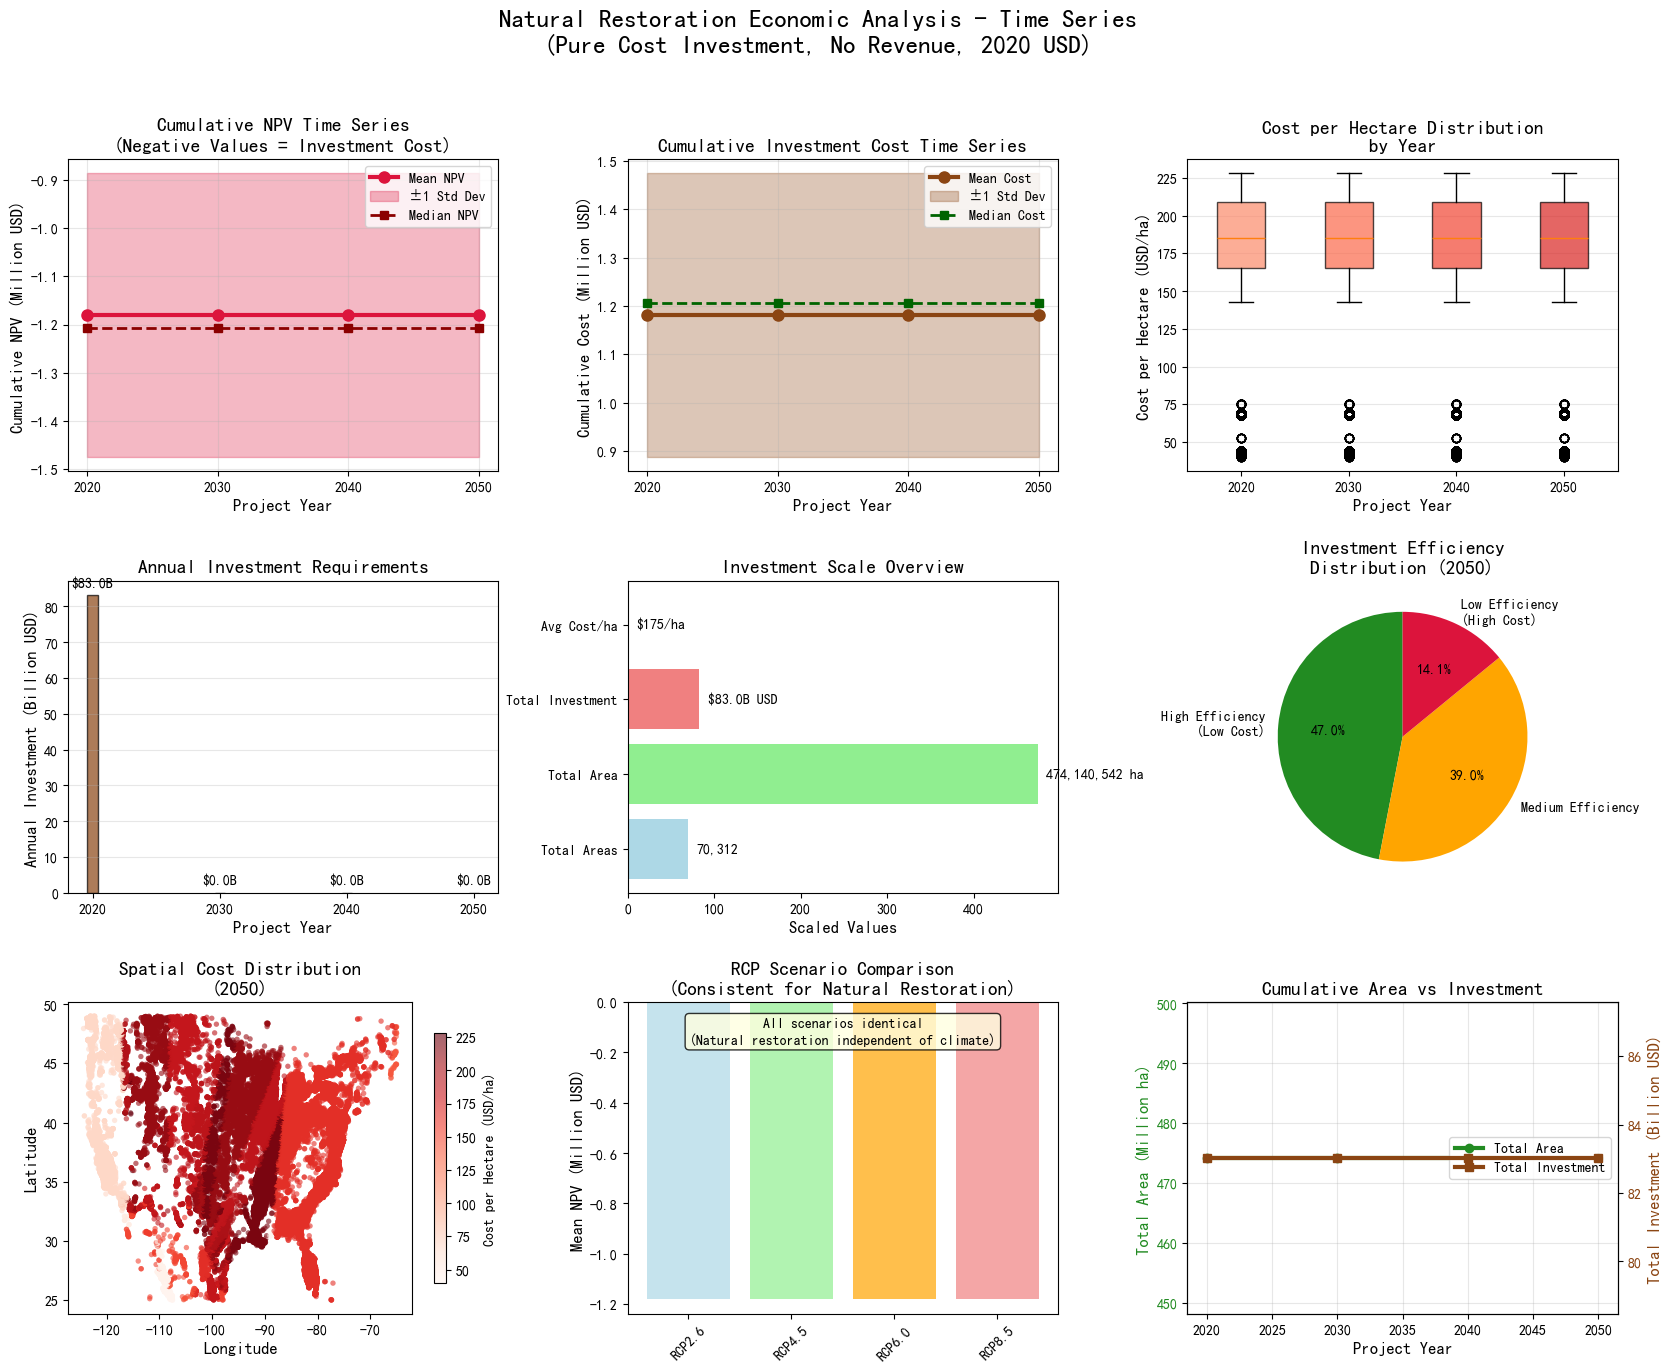


创建成本汇总分析图...
创建自然修复成本汇总分析图...


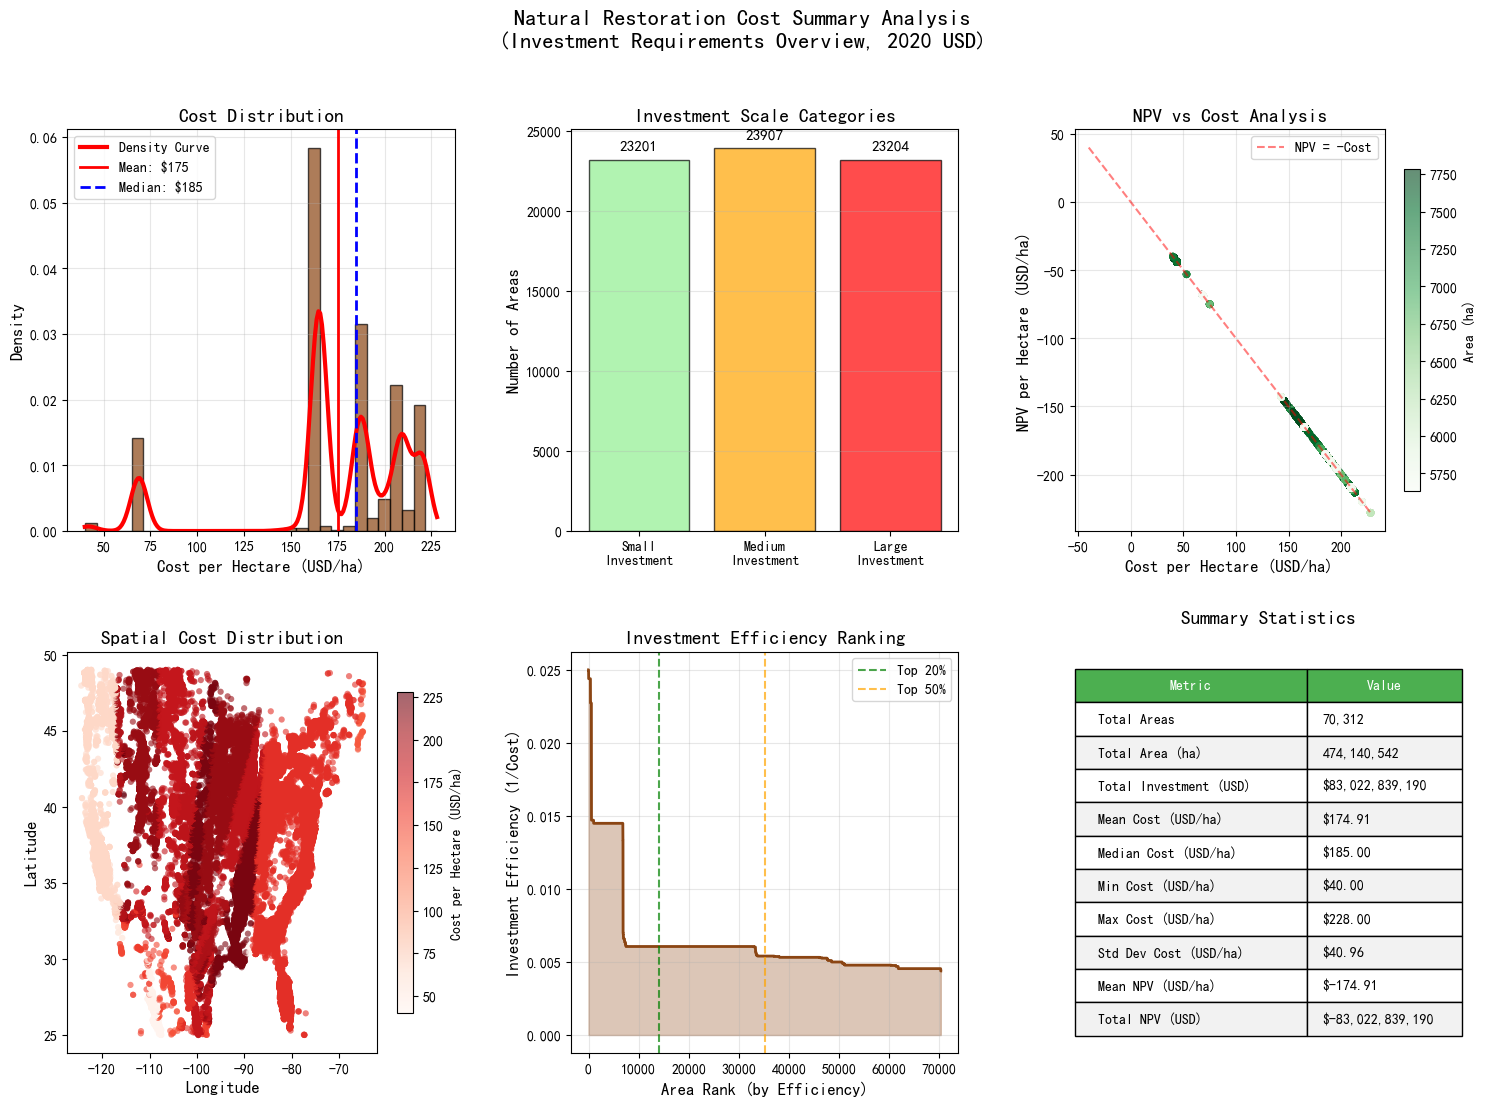


可视化分析完成！
生成的图表:
1. 5.1_natural_restoration_time_series_analysis.png - 时间序列分析
2. 5.1_natural_restoration_cost_summary.png - 成本汇总分析

=== 自然修复投资需求概览 ===
处理区域数量: 70,312
总覆盖面积: 474,140,542 公顷
总投资需求: $83,022,839,190 USD
平均成本: $174.91/公顷
平均NPV: $-174.91/公顷 (负值=纯投资)
成本范围: $40 - $228 USD/公顷


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from matplotlib.patches import Rectangle, Patch
import warnings
warnings.filterwarnings('ignore')

# ========================================================================================
# 自然修复策略经济可行性可视化函数（时间序列版本）
# ========================================================================================

# 设置配色方案
natural_colors = {
    'cost': '#8B4513',      # 棕色 - 成本
    'npv': '#DC143C',       # 深红色 - NPV（负值）
    'area': '#228B22',      # 森林绿 - 面积
    'time': '#4169E1',      # 皇家蓝 - 时间序列
    'priority': ['#228B22', '#FFA500', '#DC143C']  # 绿、橙、红
}

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def load_natural_restoration_data_for_visualization():
    """加载自然修复策略时间序列数据并转换为可视化格式"""
    
    print("加载自然修复策略时间序列数据...")
    
    # 加载时间序列数据
    df_time_series = pd.read_csv('data/5.1_natural_restoration_npv_time_series_2020usd.csv')
    
    # 提取2050年数据用于空间可视化
    df_2050 = df_time_series[
        (df_time_series['project_year'] == 2050) & 
        (df_time_series['rcp_category'] == 'RCP2.6')  # 选择第一个RCP作为代表
    ].copy()
    
    print(f"提取2050年数据用于可视化：{len(df_2050)} 个像素点")
    
    # 重新映射列名以兼容可视化函数
    df_viz = df_2050.rename(columns={
        'cumulative_npv_usd': 'NPV_total',
        'cumulative_cost_usd': 'total_cost',
        'npv_per_ha': 'NPV_per_ha',
        'cost_per_ha': 'cost_per_ha'
    }).copy()
    
    print("数据加载完成")
    return df_time_series, df_viz

def create_natural_restoration_time_series_analysis(df_time_series):
    """创建自然修复时间序列分析图"""
    
    print("创建自然修复时间序列分析图...")
    
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3, height_ratios=[1, 1, 1])
    
    # 主标题
    fig.suptitle('Natural Restoration Economic Analysis - Time Series\n(Pure Cost Investment, No Revenue, 2020 USD)', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # 选择一个RCP作为代表（所有RCP数据相同）
    df_plot = df_time_series[df_time_series['rcp_category'] == 'RCP2.6'].copy()
    
    # ========================================================================================
    # 图1: 累积NPV时间序列 (左上)
    # ========================================================================================
    ax1 = fig.add_subplot(gs[0, 0])
    
    # 按年份分组计算统计数据
    yearly_stats = df_plot.groupby('project_year')['cumulative_npv_usd'].agg(['mean', 'std', 'median']).reset_index()
    
    ax1.plot(yearly_stats['project_year'], yearly_stats['mean'] / 1e6, 
             color=natural_colors['npv'], linewidth=3, marker='o', markersize=8, label='Mean NPV')
    ax1.fill_between(yearly_stats['project_year'], 
                     (yearly_stats['mean'] - yearly_stats['std']) / 1e6,
                     (yearly_stats['mean'] + yearly_stats['std']) / 1e6,
                     color=natural_colors['npv'], alpha=0.3, label='±1 Std Dev')
    ax1.plot(yearly_stats['project_year'], yearly_stats['median'] / 1e6, 
             color='darkred', linewidth=2, linestyle='--', marker='s', markersize=6, label='Median NPV')
    
    ax1.set_xlabel('Project Year', fontsize=12)
    ax1.set_ylabel('Cumulative NPV (Million USD)', fontsize=12)
    ax1.set_title('Cumulative NPV Time Series\n(Negative Values = Investment Cost)', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xticks(yearly_stats['project_year'])
    
    # ========================================================================================
    # 图2: 累积成本时间序列 (中上)
    # ========================================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    
    cost_stats = df_plot.groupby('project_year')['cumulative_cost_usd'].agg(['mean', 'std', 'median']).reset_index()
    
    ax2.plot(cost_stats['project_year'], cost_stats['mean'] / 1e6, 
             color=natural_colors['cost'], linewidth=3, marker='o', markersize=8, label='Mean Cost')
    ax2.fill_between(cost_stats['project_year'], 
                     (cost_stats['mean'] - cost_stats['std']) / 1e6,
                     (cost_stats['mean'] + cost_stats['std']) / 1e6,
                     color=natural_colors['cost'], alpha=0.3, label='±1 Std Dev')
    ax2.plot(cost_stats['project_year'], cost_stats['median'] / 1e6, 
             color='darkgreen', linewidth=2, linestyle='--', marker='s', markersize=6, label='Median Cost')
    
    ax2.set_xlabel('Project Year', fontsize=12)
    ax2.set_ylabel('Cumulative Cost (Million USD)', fontsize=12)
    ax2.set_title('Cumulative Investment Cost Time Series', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xticks(cost_stats['project_year'])
    
    # ========================================================================================
    # 图3: 每公顷成本分布对比 (右上)
    # ========================================================================================
    ax3 = fig.add_subplot(gs[0, 2])
    
    # 按年份创建箱线图
    years = sorted(df_plot['project_year'].unique())
    cost_per_ha_data = [df_plot[df_plot['project_year'] == year]['cost_per_ha'] for year in years]
    
    bp = ax3.boxplot(cost_per_ha_data, labels=years, patch_artist=True)
    
    # 设置箱线图颜色
    colors = plt.cm.Reds([0.4, 0.5, 0.6, 0.7])
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_xlabel('Project Year', fontsize=12)
    ax3.set_ylabel('Cost per Hectare (USD/ha)', fontsize=12)
    ax3.set_title('Cost per Hectare Distribution\nby Year', fontweight='bold', fontsize=14)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # ========================================================================================
    # 图4: 年度投资分析 (左中)
    # ========================================================================================
    ax4 = fig.add_subplot(gs[1, 0])
    
    # 计算年度投资
    annual_investment = df_plot.groupby('project_year')['annual_cost_usd'].sum() / 1e9  # 转换为十亿美元
    
    bars = ax4.bar(annual_investment.index, annual_investment.values, 
                   color=natural_colors['cost'], alpha=0.7, edgecolor='black')
    
    # 添加数值标签
    for bar, val in zip(bars, annual_investment.values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(annual_investment) * 0.02,
                f'${val:.1f}B', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax4.set_xlabel('Project Year', fontsize=12)
    ax4.set_ylabel('Annual Investment (Billion USD)', fontsize=12)
    ax4.set_title('Annual Investment Requirements', fontweight='bold', fontsize=14)
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_xticks(annual_investment.index)
    
    # ========================================================================================
    # 图5: 总投资规模分析 (中中)
    # ========================================================================================
    ax5 = fig.add_subplot(gs[1, 1])
    
    # 计算总投资规模
    total_areas = len(df_plot[df_plot['project_year'] == 2050])
    total_area_ha = df_plot[df_plot['project_year'] == 2050]['area_ha'].sum()
    total_investment = df_plot[df_plot['project_year'] == 2050]['cumulative_cost_usd'].sum()
    avg_cost_per_ha = total_investment / total_area_ha
    
    # 创建总投资概览
    investment_data = {
        'Total Areas': f'{total_areas:,}',
        'Total Area': f'{total_area_ha:,.0f} ha',
        'Total Investment': f'${total_investment/1e9:.1f}B USD',
        'Avg Cost/ha': f'${avg_cost_per_ha:.0f}/ha'
    }
    
    y_pos = np.arange(len(investment_data))
    values = [total_areas/1000, total_area_ha/1e6, total_investment/1e9, avg_cost_per_ha/1000]
    
    bars = ax5.barh(y_pos, values, color=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'])
    
    ax5.set_yticks(y_pos)
    ax5.set_yticklabels(list(investment_data.keys()))
    ax5.set_xlabel('Scaled Values', fontsize=12)
    ax5.set_title('Investment Scale Overview', fontweight='bold', fontsize=14)
    
    # 添加实际数值标签
    for i, (bar, key) in enumerate(zip(bars, investment_data.keys())):
        ax5.text(bar.get_width() + max(values) * 0.02, bar.get_y() + bar.get_height()/2,
                investment_data[key], va='center', fontsize=10, fontweight='bold')
    
    # ========================================================================================
    # 图6: 投资效率分析 (右中)
    # ========================================================================================
    ax6 = fig.add_subplot(gs[1, 2])
    
    # 基于成本分位数的效率分析
    cost_2050 = df_plot[df_plot['project_year'] == 2050]['cost_per_ha']
    p25, p75 = np.percentile(cost_2050, [25, 75])
    
    efficiency_categories = ['High Efficiency\n(Low Cost)', 'Medium Efficiency', 'Low Efficiency\n(High Cost)']
    efficiency_counts = [
        (cost_2050 <= p25).sum(),
        ((cost_2050 > p25) & (cost_2050 <= p75)).sum(),
        (cost_2050 > p75).sum()
    ]
    
    # 创建饼图
    colors_eff = natural_colors['priority']
    wedges, texts, autotexts = ax6.pie(efficiency_counts, labels=efficiency_categories, 
                                      colors=colors_eff, autopct='%1.1f%%', startangle=90)
    
    ax6.set_title('Investment Efficiency\nDistribution (2050)', fontweight='bold', fontsize=14)
    
    # ========================================================================================
    # 图7: 空间分布概览 (左下)
    # ========================================================================================
    ax7 = fig.add_subplot(gs[2, 0])
    
    # 获取2050年数据进行空间分析
    df_spatial = df_plot[df_plot['project_year'] == 2050].copy()
    
    scatter = ax7.scatter(df_spatial['lon'], df_spatial['lat'], 
                         c=df_spatial['cost_per_ha'], cmap='Reds', 
                         s=15, alpha=0.6, edgecolors='none')
    
    ax7.set_xlabel('Longitude', fontsize=12)
    ax7.set_ylabel('Latitude', fontsize=12)
    ax7.set_title('Spatial Cost Distribution\n(2050)', fontweight='bold', fontsize=14)
    
    cbar = plt.colorbar(scatter, ax=ax7, shrink=0.8)
    cbar.set_label('Cost per Hectare (USD/ha)', fontsize=10)
    
    # ========================================================================================
    # 图8: RCP情景对比 (中下)
    # ========================================================================================
    ax8 = fig.add_subplot(gs[2, 1])
    
    # 虽然自然修复不区分RCP，但展示数据一致性
    rcp_comparison = df_time_series[df_time_series['project_year'] == 2050].groupby('rcp_category')['cumulative_npv_usd'].mean() / 1e6
    
    bars = ax8.bar(range(len(rcp_comparison)), rcp_comparison.values, 
                   color=['lightblue', 'lightgreen', 'orange', 'lightcoral'], alpha=0.7)
    
    ax8.set_xticks(range(len(rcp_comparison)))
    ax8.set_xticklabels(rcp_comparison.index, rotation=45)
    ax8.set_ylabel('Mean NPV (Million USD)', fontsize=12)
    ax8.set_title('RCP Scenario Comparison\n(Consistent for Natural Restoration)', fontweight='bold', fontsize=14)
    
    # 添加一致性标注
    ax8.text(0.5, 0.95, 'All scenarios identical\n(Natural restoration independent of climate)', 
            transform=ax8.transAxes, ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # ========================================================================================
    # 图9: 累积统计趋势 (右下)
    # ========================================================================================
    ax9 = fig.add_subplot(gs[2, 2])
    
    # 计算累积面积和投资趋势
    area_trend = df_plot.groupby('project_year')['area_ha'].sum() / 1e6  # 转换为百万公顷
    investment_trend = df_plot.groupby('project_year')['cumulative_cost_usd'].sum() / 1e9  # 转换为十亿美元
    
    ax9_twin = ax9.twinx()
    
    line1 = ax9.plot(area_trend.index, area_trend.values, 
                     color=natural_colors['area'], linewidth=3, marker='o', label='Total Area')
    line2 = ax9_twin.plot(investment_trend.index, investment_trend.values, 
                          color=natural_colors['cost'], linewidth=3, marker='s', label='Total Investment')
    
    ax9.set_xlabel('Project Year', fontsize=12)
    ax9.set_ylabel('Total Area (Million ha)', fontsize=12, color=natural_colors['area'])
    ax9_twin.set_ylabel('Total Investment (Billion USD)', fontsize=12, color=natural_colors['cost'])
    ax9.set_title('Cumulative Area vs Investment', fontweight='bold', fontsize=14)
    
    # 合并图例
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax9.legend(lines, labels, loc='center right')
    
    ax9.tick_params(axis='y', labelcolor=natural_colors['area'])
    ax9_twin.tick_params(axis='y', labelcolor=natural_colors['cost'])
    ax9.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('data/5.1_natural_restoration_time_series_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_natural_restoration_cost_summary(df_viz):
    """创建自然修复成本汇总分析图"""
    
    print("创建自然修复成本汇总分析图...")
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    fig.suptitle('Natural Restoration Cost Summary Analysis\n(Investment Requirements Overview, 2020 USD)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # ========================================================================================
    # 图1: 成本分布直方图 (左上)
    # ========================================================================================
    ax1 = fig.add_subplot(gs[0, 0])
    
    cost_data = df_viz['cost_per_ha'].dropna()
    
    # 创建直方图
    n, bins, patches = ax1.hist(cost_data, bins=30, color=natural_colors['cost'], 
                               alpha=0.7, edgecolor='black', density=True)
    
    # 添加核密度估计
    if len(cost_data) > 10:
        kde = gaussian_kde(cost_data)
        x_range = np.linspace(cost_data.min(), cost_data.max(), 200)
        ax1.plot(x_range, kde(x_range), color='red', linewidth=3, label='Density Curve')
    
    # 添加统计线
    mean_cost = cost_data.mean()
    median_cost = cost_data.median()
    ax1.axvline(mean_cost, color='red', linestyle='-', linewidth=2, label=f'Mean: ${mean_cost:.0f}')
    ax1.axvline(median_cost, color='blue', linestyle='--', linewidth=2, label=f'Median: ${median_cost:.0f}')
    
    ax1.set_xlabel('Cost per Hectare (USD/ha)', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title('Cost Distribution', fontweight='bold', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # ========================================================================================
    # 图2: 总投资需求分析 (中上)
    # ========================================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    
    total_cost_data = df_viz['total_cost'].dropna()
    
    # 按投资规模分组
    small_investment = (total_cost_data < np.percentile(total_cost_data, 33)).sum()
    medium_investment = ((total_cost_data >= np.percentile(total_cost_data, 33)) & 
                        (total_cost_data < np.percentile(total_cost_data, 67))).sum()
    large_investment = (total_cost_data >= np.percentile(total_cost_data, 67)).sum()
    
    investment_categories = ['Small\nInvestment', 'Medium\nInvestment', 'Large\nInvestment']
    investment_counts = [small_investment, medium_investment, large_investment]
    
    bars = ax2.bar(investment_categories, investment_counts, 
                   color=['lightgreen', 'orange', 'red'], alpha=0.7, edgecolor='black')
    
    # 添加数值标签
    for bar, count in zip(bars, investment_counts):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(investment_counts) * 0.02,
                f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax2.set_ylabel('Number of Areas', fontsize=12)
    ax2.set_title('Investment Scale Categories', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # ========================================================================================
    # 图3: NPV vs 成本散点图 (右上)
    # ========================================================================================
    ax3 = fig.add_subplot(gs[0, 2])
    
    scatter = ax3.scatter(df_viz['cost_per_ha'], df_viz['NPV_per_ha'], 
                         c=df_viz['area_ha'], cmap='Greens', 
                         alpha=0.6, s=30, edgecolors='none')
    
    ax3.set_xlabel('Cost per Hectare (USD/ha)', fontsize=12)
    ax3.set_ylabel('NPV per Hectare (USD/ha)', fontsize=12)
    ax3.set_title('NPV vs Cost Analysis', fontweight='bold', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax3, shrink=0.8)
    cbar.set_label('Area (ha)', fontsize=10)
    
    # 添加对角线参考
    min_val = min(df_viz['cost_per_ha'].min(), df_viz['NPV_per_ha'].max())
    max_val = max(df_viz['cost_per_ha'].max(), df_viz['NPV_per_ha'].min())
    ax3.plot([min_val, max_val], [-min_val, -max_val], 'r--', alpha=0.5, label='NPV = -Cost')
    ax3.legend()
    
    # ========================================================================================
    # 图4: 空间成本分布 (左下)
    # ========================================================================================
    ax4 = fig.add_subplot(gs[1, 0])
    
    scatter4 = ax4.scatter(df_viz['lon'], df_viz['lat'], 
                          c=df_viz['cost_per_ha'], cmap='Reds', 
                          s=20, alpha=0.6, edgecolors='none')
    
    ax4.set_xlabel('Longitude', fontsize=12)
    ax4.set_ylabel('Latitude', fontsize=12)
    ax4.set_title('Spatial Cost Distribution', fontweight='bold', fontsize=14)
    
    cbar4 = plt.colorbar(scatter4, ax=ax4, shrink=0.8)
    cbar4.set_label('Cost per Hectare (USD/ha)', fontsize=10)
    
    # ========================================================================================
    # 图5: 投资效率排序 (中下)
    # ========================================================================================
    ax5 = fig.add_subplot(gs[1, 1])
    
    # 计算投资效率（成本倒数）
    efficiency = 1 / df_viz['cost_per_ha']
    sorted_efficiency = np.sort(efficiency)[::-1]  # 降序排列
    
    ax5.plot(range(len(sorted_efficiency)), sorted_efficiency, 
             color=natural_colors['cost'], linewidth=2)
    ax5.fill_between(range(len(sorted_efficiency)), 0, sorted_efficiency, 
                     color=natural_colors['cost'], alpha=0.3)
    
    ax5.set_xlabel('Area Rank (by Efficiency)', fontsize=12)
    ax5.set_ylabel('Investment Efficiency (1/Cost)', fontsize=12)
    ax5.set_title('Investment Efficiency Ranking', fontweight='bold', fontsize=14)
    ax5.grid(True, alpha=0.3)
    
    # 标注效率分位数
    p80_idx = int(len(sorted_efficiency) * 0.2)
    p50_idx = int(len(sorted_efficiency) * 0.5)
    
    ax5.axvline(p80_idx, color='green', linestyle='--', alpha=0.7, label='Top 20%')
    ax5.axvline(p50_idx, color='orange', linestyle='--', alpha=0.7, label='Top 50%')
    ax5.legend()
    
    # ========================================================================================
    # 图6: 统计摘要表 (右下)
    # ========================================================================================
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    
    # 计算关键统计数据
    stats_data = {
        'Metric': [
            'Total Areas',
            'Total Area (ha)',
            'Total Investment (USD)',
            'Mean Cost (USD/ha)',
            'Median Cost (USD/ha)',
            'Min Cost (USD/ha)',
            'Max Cost (USD/ha)',
            'Std Dev Cost (USD/ha)',
            'Mean NPV (USD/ha)',
            'Total NPV (USD)'
        ],
        'Value': [
            f'{len(df_viz):,}',
            f'{df_viz["area_ha"].sum():,.0f}',
            f'${df_viz["total_cost"].sum():,.0f}',
            f'${df_viz["cost_per_ha"].mean():.2f}',
            f'${df_viz["cost_per_ha"].median():.2f}',
            f'${df_viz["cost_per_ha"].min():.2f}',
            f'${df_viz["cost_per_ha"].max():.2f}',
            f'${df_viz["cost_per_ha"].std():.2f}',
            f'${df_viz["NPV_per_ha"].mean():.2f}',
            f'${df_viz["NPV_total"].sum():,.0f}'
        ]
    }
    
    # 创建表格
    table_data = list(zip(stats_data['Metric'], stats_data['Value']))
    table = ax6.table(cellText=table_data, 
                     colLabels=['Metric', 'Value'],
                     cellLoc='left', loc='center',
                     colWidths=[0.6, 0.4])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # 设置表格样式
    for i in range(len(table_data) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # 表头
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            elif i % 2 == 0:  # 偶数行
                cell.set_facecolor('#f2f2f2')
            else:  # 奇数行
                cell.set_facecolor('white')
            cell.set_edgecolor('black')
    
    ax6.set_title('Summary Statistics', fontweight='bold', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.savefig('data/5.1_natural_restoration_cost_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def run_natural_restoration_visualization():
    """运行完整的自然修复策略可视化分析"""
    
    print("================================================================================")
    print("自然修复策略经济可行性可视化分析")
    print("================================================================================")
    
    try:
        # 加载数据
        df_time_series, df_viz = load_natural_restoration_data_for_visualization()
        
        # 创建时间序列分析图
        print("\n创建时间序列分析图...")
        fig1 = create_natural_restoration_time_series_analysis(df_time_series)
        
        # 创建成本汇总分析图
        print("\n创建成本汇总分析图...")
        fig2 = create_natural_restoration_cost_summary(df_viz)
        
        print("\n================================================================================")
        print("可视化分析完成！")
        print("================================================================================")
        print("生成的图表:")
        print("1. 5.1_natural_restoration_time_series_analysis.png - 时间序列分析")
        print("2. 5.1_natural_restoration_cost_summary.png - 成本汇总分析")
        
        # 输出关键统计信息
        print(f"\n=== 自然修复投资需求概览 ===")
        total_areas = len(df_viz)
        total_area_ha = df_viz['area_ha'].sum()
        total_investment = df_viz['total_cost'].sum()
        avg_cost_per_ha = df_viz['cost_per_ha'].mean()
        avg_npv_per_ha = df_viz['NPV_per_ha'].mean()
        
        print(f"处理区域数量: {total_areas:,}")
        print(f"总覆盖面积: {total_area_ha:,.0f} 公顷")
        print(f"总投资需求: ${total_investment:,.0f} USD")
        print(f"平均成本: ${avg_cost_per_ha:.2f}/公顷")
        print(f"平均NPV: ${avg_npv_per_ha:.2f}/公顷 (负值=纯投资)")
        print(f"成本范围: ${df_viz['cost_per_ha'].min():.0f} - ${df_viz['cost_per_ha'].max():.0f} USD/公顷")
        
        return df_time_series, df_viz
        
    except Exception as e:
        print(f"可视化过程中出错: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# ========================================================================================
# 运行可视化分析
# ========================================================================================

if __name__ == "__main__":
    df_time_series, df_viz = run_natural_restoration_visualization()

# 5.5 策略期望成本

结合各个输出文件的变量，结合'df_strategies'中的三类权重构造净期望收益-成本






首先,需要根据df_pv_npv的[Category]构造一个映射如下，这个映射主要为了结合df_agricultural_npv的‘RCP_Category’(RCP2.6,RCP4.5,RCP6.0,RCP8.5)。

{c1,c2,c3: rcp 2.6,
c4:rcp 4.5
c5:rcp 6.0
c6,c7,c8:rcp 8.5}

其中，你需要判别一下column的名字可能存在{RCP_Category	rcp_category rcp_category}两个不同命名	

其次，我需要计算经济净期望
accumulative npv from 2020-2050 by pixel : npv of pv-  ('weighted_density_Forest' * npv of afforestation + 'weighted_density_Agricultural' * npv of agricultural + 'weighted_density_Vegetation' * npv of natural) 
accumulative cost from 2020-2050 by pixel : 重复以上逻辑，把npv 置换成 cost 变量



变量申明：
df_st['weighted_density_Forest'] 
df_st['weighted_density_Agricultural']
df_st['weighted_density_Vegetation']

df_afforestation_npv['cumulative_npv_usd']
'analysis_year' 是公有的变量，2020，2030，2040，2050分别代表该年份累积的成本，言下之意2050对应的就是总NPV或者总Cost

以上计算主要根据df_pv_npv的各个路径进行计算、整体平均水平进行汇总,例如:

假设每个pixel中，df_pv种不同值, npv of afforestation 存在m种，npv of agricultural 存在p种，npv of natural存在q种，那么一共存在
n*m*p*q的可能路径




    -  以下数据是5.1模块计算成本-效益生成分析结果
    'df_pv_npv': r'data/5.1_photovoltaic_results_complete_streaming.csv',
    'df_pv_summary': r'data/5.1_photovoltaic_policy_summary_streaming.csv',

    - 以下是根据5.2模块计算的农业经济可行性分析结果
    'df_agricultural_npv':r'data/5.1_agricultural_results_streaming_optimized.csv',
    'df_agricultural_rcp_year':r'data/5.1_agricultural_summary_streaming_optimized.csv',
    'df_agricultural_rcp_overall':r'data/5.1_agricultural_rcp_overall_optimized.csv',

    - 以下是根据5.3模块计算的复林经济可行性结果
    'df_afforestation_npv': r'data/5.1_afforestation_results_streaming.csv',
    'df_afforestation_rcp_year': r'data/5.1_afforestation_summary_streaming.csv',
    'df_afforestation_rcp_overall': r'data/5.1_afforestation_rcp_overall_streaming.csv',

    'df_natural_npv': r'data/5.1_natural_restoration_results_streaming.csv',
    'df_natural_rcp_year': r'data/5.1_natural_restoration_summary_streaming.csv',
    'df_natural_rcp_overall': r'data/5.1_natural_restoration_rcp_overall_streaming.csv'

## 5.5.1 策略期望计算模块

### 1、数据加载

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from function import *
from function.global_varibles import *
import glob
import os
from tqdm.auto import tqdm
from itertools import product



%load_ext autoreload
%autoreload 2

# 加载收益-成本数据
df_pv_npv = pd.read_csv(PATHS['df_pv_npv'])
df_agricultural_npv = pd.read_csv(PATHS['df_agricultural_npv'])
df_afforestation_npv = pd.read_csv(PATHS['df_afforestation_npv'])
df_natural_npv = pd.read_csv(PATHS['df_natural_npv'])

# 加载策略数据
df_st = pd.read_csv(PATHS['data_weighted_density'])
df_carbon=pd.read_csv(PATHS['data_strategies'])
df_net_benefit=pd.read_csv(PATHS['data_prediction_carbon_benefit'])


gogogo
✅ TensorFlow available
✅ scikeras available
✅ SHAP available


In [18]:
df_st

lat         lon        time  acc_forest  cap_forest  \
0      17.712500  -64.870834  2020-01-01   354.55865       346.1   
1      17.712500  -64.862500  2020-01-01   354.55865       352.6   
2      17.712500  -64.854164  2020-01-01   354.03183       365.6   
3      17.712500  -64.837500  2020-01-01   354.03183       350.4   
4      17.712500  -64.754166  2020-01-01   354.01880       326.6   
...          ...         ...         ...         ...         ...   
71765  63.912500 -145.212500  2020-01-01   292.83450       304.0   
71766  64.012500 -145.004170  2020-01-01   382.99880       400.3   
71767  64.029170 -145.112500  2020-01-01   322.05780       336.1   
71768  64.129166 -145.662500  2020-01-01   341.45350       358.4   
71769  64.829170 -147.579160  2020-01-01   757.38586       768.1   

       final_forest  weighted_density_Forest  weighted_density_Agricultural  \
0         346.10000                 0.998549                       0.000690   
1         352.60000                 0.992102                       0.003982   
2         354.03183                 0.978721                       0.011474   
3         350.40000                 0.939385                       0.038424   
4         326.60000                 0.866236                       0.051502   
...             ...                      ...                            ...   
71765     292.83450                 0.996218                       0.000000   
71766     382.99880                 0.994898                       0.000000   
71767     322.05780                 0.999208                       0.000000   
71768     341.45350                 0.998355                       0.000000   
71769     757.38586                 0.003378                       0.000000   

       weighted_density_Vegetation    acc_agro   cap_agro  final_agro  \
0                         0.000761  231.784790  578.76000  231.784790   
1                         0.003915  229.160988  584.88000  229.160988   
2                         0.009806  246.487984  597.12000  246.487984   
3                         0.022191  256.934536  582.83997  256.934536   
4                         0.082261  236.569101  561.40000  236.569101   
...                            ...         ...        ...         ...   
71765                     0.003782  250.121078  244.00000  244.000000   
71766                     0.005102  344.429016  336.00000  336.000000   
71767                     0.000792  269.597717  275.00000  269.597717   
71768                     0.001645  296.249969  293.00000  293.000000   
71769                     0.996622  724.736084  707.00000  707.000000   

         acc_veg  cap_veg  final_veg  pv_potential_dens  \
0      261.82220    338.0  261.82220        8053.456581   
1      257.37793    344.0  257.37793        8147.431840   
2      284.05655    356.0  284.05655        8150.856495   
3      301.83356    342.0  301.83356        8115.594560   
4      237.84682    320.0  237.84682        8121.179221   
...          ...      ...        ...                ...   
71765  297.58560    300.0  297.58560        4153.506730   
71766  390.57986    396.0  390.57986        4081.609401   
71767  278.82788    332.0  278.82788        4077.508925   
71768  323.47504    354.0  323.47504        4071.068450   
71769  729.95070    764.0  729.95070        3987.152757   

       Expectation_net_benefit  Revenue_ratio  
0                  7707.499550      23.278777  
1                  7795.696241      23.163512  
2                  7798.744737      23.148493  
3                  7769.863611      23.473729  
4                  7806.516986      25.809196  
...                        ...            ...  
71765              3860.654259      14.182932  
71766              3698.571910      10.655901  
71767              3755.485366      12.662145  
71768              3729.644534      11.923794  
71769              3257.109405       5.461529  

[71770 rows x 18 columns]

In [9]:
df_pv_npv


pixel_id        lat        lon         Model              Scenario  \
0                0  21.895834 -159.47084    REMIND 2.1  CEMICS_GDPgrowth_1p5   
1                1  21.904167 -159.57916    REMIND 2.1  CEMICS_GDPgrowth_1p5   
2                2  21.904167 -159.52083    REMIND 2.1  CEMICS_GDPgrowth_1p5   
3                3  21.904167 -159.46250    REMIND 2.1  CEMICS_GDPgrowth_1p5   
4                4  21.912500 -159.52083    REMIND 2.1  CEMICS_GDPgrowth_1p5   
...            ...        ...        ...           ...                   ...   
76076195     71765  63.912500 -145.21250  TIAM-ECN 1.1        EN_NPi2100_COV   
76076196     71766  64.012500 -145.00417  TIAM-ECN 1.1        EN_NPi2100_COV   
76076197     71767  64.029170 -145.11250  TIAM-ECN 1.1        EN_NPi2100_COV   
76076198     71768  64.129166 -145.66250  TIAM-ECN 1.1        EN_NPi2100_COV   
76076199     71769  64.829170 -147.57916  TIAM-ECN 1.1        EN_NPi2100_COV   

         Policy_category Category  analysis_year  cumulative_npv_usd  \
0                    P2a       C1           2020       -2.391378e+06   
1                    P2a       C1           2020       -2.391378e+06   
2                    P2a       C1           2020       -2.391378e+06   
3                    P2a       C1           2020       -2.391378e+06   
4                    P2a       C1           2020       -2.391378e+06   
...                  ...      ...            ...                 ...   
76076195             P1b       C7           2050        2.286757e+06   
76076196             P1b       C7           2050        2.165695e+06   
76076197             P1b       C7           2050        2.158790e+06   
76076198             P1b       C7           2050        2.147946e+06   
76076199             P1b       C7           2050        2.006647e+06   

          cumulative_cost_usd  cumulative_demand_usd  
0                2.391378e+06           0.000000e+00  
1                2.391378e+06           0.000000e+00  
2                2.391378e+06           0.000000e+00  
3                2.391378e+06           0.000000e+00  
4                2.391378e+06           0.000000e+00  
...                       ...                    ...  
76076195         4.706997e+06          -4.694904e+06  
76076196         4.706997e+06          -4.695113e+06  
76076197         4.706997e+06          -4.695125e+06  
76076198         4.706997e+06          -4.695144e+06  
76076199         4.706997e+06          -4.695388e+06  

[76076200 rows x 11 columns]

In [11]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from itertools import product

def create_rcp_mapping():
    """创建Category到RCP的映射"""
    rcp_mapping = {
        'C1': 'RCP2.6', 'C2': 'RCP2.6', 'C3': 'RCP2.6',
        'C4': 'RCP4.5',
        'C5': 'RCP6.0', 
        'C6': 'RCP8.5', 'C7': 'RCP8.5', 'C8': 'RCP8.5'
    }
    return rcp_mapping

def standardize_rcp_column(df, rcp_mapping):
    """标准化RCP列名和值"""
    # 检查列名
    rcp_cols = ['RCP_Category', 'rcp_category', 'RCP_category']
    rcp_col = None
    for col in rcp_cols:
        if col in df.columns:
            rcp_col = col
            break
    
    # 重命名列
    if rcp_col is not None and rcp_col != 'rcp_category':
        df = df.rename(columns={rcp_col: 'rcp_category'})
    
    # 如果还没有rcp_category列，从Category创建
    if 'rcp_category' not in df.columns and 'Category' in df.columns:
        df['rcp_category'] = df['Category'].map(rcp_mapping)
    
    return df



def calculate_net_expected_benefit_vectorized_multi_path(
    df_pv_npv, df_agricultural_npv, df_afforestation_npv, df_natural_npv, df_st,
    target_years=[2020, 2030, 2040, 2050], flag=False,
    output_file='data/5.1_net_expected_benefit_results.csv'
):
    """向量化处理多路径的净期望收益计算 - 包含demand变量
    修改：每个pixel的所有PV记录使用相同的机会成本（所有策略都用RCP均值）
    """
    
    print("="*80)
    print("净期望收益-成本计算 - 向量化多路径版本（包含demand）")
    print("="*80)
    print("📝 注意：每个pixel的所有PV记录使用相同的机会成本（RCP均值）")
    
    # 只保留必要字段
    df_st = df_st[['lat', 'lon', 'weighted_density_Forest', 'weighted_density_Agricultural', 'weighted_density_Vegetation']]
    
    # 创建RCP映射（仅用于PV的rcp_category列，不影响机会成本计算）
    rcp_mapping = create_rcp_mapping()
    
    # 标准化RCP列（仅用于PV，用于保留RCP标签）
    df_pv_npv = standardize_rcp_column(df_pv_npv, rcp_mapping)
    # Agricultural、Afforestation、Natural都不需要映射，直接使用RCP均值
    
    # 写入表头
    header = [
        'lat', 'lon', 'pv_category', 'pv_model', 'pv_scenario', 'policy_category',
        'rcp_category', 'net_npv_usd', 'net_cost_usd', 'net_npv_usd_demand', 'analysis_year'  
    ]
    with open(output_file, 'w', encoding='utf-8', newline='') as f:
        f.write(','.join(header) + '\n')
    
    # 按年份处理
    for target_year in tqdm(target_years, desc="处理年份"):
        print(f"\n 处理年份: {target_year}")
        
        # 筛选当前年份数据
        df_pv_year = df_pv_npv[df_pv_npv['analysis_year'] == target_year].copy()
        df_agri_year = df_agricultural_npv[df_agricultural_npv['analysis_year'] == target_year].copy()
        df_affor_year = df_afforestation_npv[df_afforestation_npv['analysis_year'] == target_year].copy()
        df_natural_year = df_natural_npv[df_natural_npv['analysis_year'] == target_year].copy()
        
        # 处理PV数据 - 保留所有列包括rcp_category
        df_pv_year = df_pv_year[['lat', 'lon', 'Category', 'Model', 'Scenario', 'Policy_category', 
                                 'rcp_category', 'cumulative_npv_usd', 'cumulative_cost_usd', 'cumulative_demand_usd']]
        
        # 处理所有策略数据 - 都计算RCP均值
        # Agricultural: 对每个pixel计算所有RCP的均值
        df_agri_year_mean = df_agri_year.groupby(['lat', 'lon']).agg({
            'cumulative_npv_usd': 'mean',  # RCP2.6, 4.5, 6.0, 8.5的均值
            'cumulative_cost_usd': 'mean'
        }).reset_index().rename(columns={
            'cumulative_npv_usd': 'agri_npv_mean',
            'cumulative_cost_usd': 'agri_cost_mean'
        })
        
        # Afforestation: 对每个pixel计算所有RCP的均值
        df_affor_year_mean = df_affor_year.groupby(['lat', 'lon']).agg({
            'cumulative_npv_usd': 'mean',  # RCP2.6, 4.5, 6.0, 8.5的均值
            'cumulative_cost_usd': 'mean'
        }).reset_index().rename(columns={
            'cumulative_npv_usd': 'affor_npv_mean',
            'cumulative_cost_usd': 'affor_cost_mean'
        })
        
        # Natural: 对每个pixel计算所有RCP的均值
        df_natural_year_mean = df_natural_year.groupby(['lat', 'lon']).agg({
            'cumulative_npv_usd': 'mean',  # RCP2.6, 4.5, 6.0, 8.5的均值
            'cumulative_cost_usd': 'mean'
        }).reset_index().rename(columns={
            'cumulative_npv_usd': 'natural_npv_mean',
            'cumulative_cost_usd': 'natural_cost_mean'
        })
        
        # 合并权重和所有策略的均值数据
        df_merged = df_pv_year.merge(df_st, on=['lat', 'lon'], how='inner')
        df_merged = df_merged.merge(df_agri_year_mean, on=['lat', 'lon'], how='inner')
        df_merged = df_merged.merge(df_affor_year_mean, on=['lat', 'lon'], how='inner')
        df_merged = df_merged.merge(df_natural_year_mean, on=['lat', 'lon'], how='inner')
        
        if len(df_merged) == 0:
            print(f"  ⚠️ 年份 {target_year} 无数据可处理")
            continue
        
        # 向量化计算净期望收益
        # 所有PV记录（无论C1还是C5）都用相同的机会成本
        df_merged['net_npv_usd'] = (
            df_merged['cumulative_npv_usd'] - 
            (df_merged['weighted_density_Forest'] * df_merged['affor_npv_mean'] +
             df_merged['weighted_density_Agricultural'] * df_merged['agri_npv_mean'] +
             df_merged['weighted_density_Vegetation'] * df_merged['natural_npv_mean'])
        )
        
        df_merged['net_cost_usd'] = (
            df_merged['cumulative_cost_usd'] - 
            (df_merged['weighted_density_Forest'] * df_merged['affor_cost_mean'] +
             df_merged['weighted_density_Agricultural'] * df_merged['agri_cost_mean'] +
             df_merged['weighted_density_Vegetation'] * df_merged['natural_cost_mean'])
        )

        # demand变量计算
        df_merged['net_npv_usd_demand'] = (
            df_merged['cumulative_demand_usd'] - 
            (df_merged['weighted_density_Forest'] * df_merged['affor_npv_mean'] * 
             (df_merged['cumulative_demand_usd'] / df_merged['cumulative_npv_usd']).fillna(1) +
             df_merged['weighted_density_Agricultural'] * df_merged['agri_npv_mean'] * 
             (df_merged['cumulative_demand_usd'] / df_merged['cumulative_npv_usd']).fillna(1) +
             df_merged['weighted_density_Vegetation'] * df_merged['natural_npv_mean'] * 
             (df_merged['cumulative_demand_usd'] / df_merged['cumulative_npv_usd']).fillna(1))
        )
        
        # 只保留需要的列并写入
        result_cols = [
            'lat', 'lon', 'Category', 'Model', 'Scenario', 'Policy_category',
            'rcp_category', 'net_npv_usd', 'net_cost_usd', 'net_npv_usd_demand'  
        ]
        df_result = df_merged[result_cols].copy()
        df_result['analysis_year'] = target_year
        
        # 写入文件
        df_result.to_csv(output_file, mode='a', header=False, index=False)
        
        print(f"  ✅ 年份 {target_year}: 处理了 {len(df_result):,} 条记录")
        
        if flag:
            print(f"测试模式：只处理第一个年份")
            print(f"demand列范围: {df_result['net_npv_usd_demand'].min():.2f} - {df_result['net_npv_usd_demand'].max():.2f}")
            break
    
    print(f"\n✅ 结果已写入 {output_file}")
    print(f"📝 修改说明: 每个pixel的所有PV记录使用相同的机会成本（所有策略都用RCP均值）")

df_net_benefit = calculate_net_expected_benefit_vectorized_multi_path(
    df_pv_npv=df_pv_npv,
    df_agricultural_npv=df_agricultural_npv,
    df_afforestation_npv=df_afforestation_npv,
    df_natural_npv=df_natural_npv,
    df_st=df_st,
    target_years=[2020, 2030, 2040, 2050],
    flag=False,
    output_file='data/5.1_net_expected_benefit_results.csv'
)


净期望收益-成本计算 - 向量化多路径版本（包含demand）
📝 注意：每个pixel的所有PV记录使用相同的机会成本（RCP均值）


处理年份:   0%|          | 0/4 [00:00<?, ?it/s]


 处理年份: 2020
  ✅ 年份 2020: 处理了 19,019,050 条记录

 处理年份: 2030
  ✅ 年份 2030: 处理了 19,019,050 条记录

 处理年份: 2040
  ✅ 年份 2040: 处理了 19,019,050 条记录

 处理年份: 2050
  ✅ 年份 2050: 处理了 19,019,050 条记录

✅ 结果已写入 data/5.1_net_expected_benefit_results.csv
📝 修改说明: 每个pixel的所有PV记录使用相同的机会成本（所有策略都用RCP均值）


In [ ]:
# 原始版本

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from itertools import product

def create_rcp_mapping():
    """创建Category到RCP的映射"""
    rcp_mapping = {
        'C1': 'RCP2.6', 'C2': 'RCP2.6', 'C3': 'RCP2.6',
        'C4': 'RCP4.5',
        'C5': 'RCP6.0', 
        'C6': 'RCP8.5', 'C7': 'RCP8.5', 'C8': 'RCP8.5'
    }
    return rcp_mapping

def standardize_rcp_column(df, rcp_mapping):
    """标准化RCP列名和值"""
    # 检查列名
    rcp_cols = ['RCP_Category', 'rcp_category', 'RCP_category']
    rcp_col = None
    for col in rcp_cols:
        if col in df.columns:
            rcp_col = col
            break
    
    # 重命名列
    if rcp_col is not None and rcp_col != 'rcp_category':
        df = df.rename(columns={rcp_col: 'rcp_category'})
    
    # 如果还没有rcp_category列，从Category创建
    if 'rcp_category' not in df.columns and 'Category' in df.columns:
        df['rcp_category'] = df['Category'].map(rcp_mapping)
    
    return df




def calculate_net_expected_benefit_vectorized_multi_path(
    df_pv_npv, df_agricultural_npv, df_afforestation_npv, df_natural_npv, df_st,
    target_years=[2020, 2030, 2040, 2050], flag=False,
    output_file='data/5.1_net_expected_benefit_results.csv'
):
    """向量化处理多路径的净期望收益计算 - 包含demand变量"""
    
    print("="*80)
    print("净期望收益-成本计算 - 向量化多路径版本（包含demand）")
    print("="*80)
    
    # 只保留必要字段
    df_st = df_st[['lat', 'lon', 'weighted_density_Forest', 'weighted_density_Agricultural', 'weighted_density_Vegetation']]
    
    # 创建RCP映射
    rcp_mapping = create_rcp_mapping()
    
    # 标准化RCP列
    df_pv_npv = standardize_rcp_column(df_pv_npv, rcp_mapping)
    df_agricultural_npv = standardize_rcp_column(df_agricultural_npv, rcp_mapping)
    df_afforestation_npv = standardize_rcp_column(df_afforestation_npv, rcp_mapping)
    df_natural_npv = standardize_rcp_column(df_natural_npv, rcp_mapping)
    
    # 写入表头 - 新增demand列
    header = [
        'lat', 'lon', 'pv_category', 'pv_model', 'pv_scenario', 'policy_category',
        'rcp_category', 'net_npv_usd', 'net_cost_usd', 'net_npv_usd_demand', 'analysis_year'  
    ]
    with open(output_file, 'w', encoding='utf-8', newline='') as f:
        f.write(','.join(header) + '\n')
    
    # 按年份处理
    for target_year in tqdm(target_years, desc="处理年份"):
        print(f"\n 处理年份: {target_year}")
        
        # 筛选当前年份数据
        df_pv_year = df_pv_npv[df_pv_npv['analysis_year'] == target_year].copy()
        df_agri_year = df_agricultural_npv[df_agricultural_npv['analysis_year'] == target_year].copy()
        df_affor_year = df_afforestation_npv[df_afforestation_npv['analysis_year'] == target_year].copy()
        df_natural_year = df_natural_npv[df_natural_npv['analysis_year'] == target_year].copy()
        
        # 只保留必要列 - 新增demand列
        df_pv_year = df_pv_year[['lat', 'lon', 'Category', 'Model', 'Scenario', 'Policy_category', 
                                 'rcp_category', 'cumulative_npv_usd', 'cumulative_cost_usd', 'cumulative_demand_usd']]  # 新增demand
        df_agri_year = df_agri_year[['lat', 'lon', 'rcp_category', 'cumulative_npv_usd', 'cumulative_cost_usd']].rename(columns={
            'cumulative_npv_usd': 'agri_npv', 'cumulative_cost_usd': 'agri_cost'
        })
        df_affor_year = df_affor_year[['lat', 'lon', 'rcp_category', 'cumulative_npv_usd', 'cumulative_cost_usd']].rename(columns={
            'cumulative_npv_usd': 'affor_npv', 'cumulative_cost_usd': 'affor_cost'
        })
        df_natural_year = df_natural_year[['lat', 'lon', 'rcp_category', 'cumulative_npv_usd', 'cumulative_cost_usd']].rename(columns={
            'cumulative_npv_usd': 'natural_npv', 'cumulative_cost_usd': 'natural_cost'
        })
        
        # 合并权重
        df_merged = df_pv_year.merge(df_st, on=['lat', 'lon'], how='inner')
        
        # 按RCP分组处理
        rcp_groups = df_merged.groupby('rcp_category')
        
        for rcp, pv_group in tqdm(rcp_groups, desc=f"处理RCP场景 {target_year}", leave=False):

            # 获取对应RCP的其他策略数据
            agri_rcp = df_agri_year[df_agri_year['rcp_category'] == rcp]
            affor_rcp = df_affor_year[df_affor_year['rcp_category'] == rcp]
            natural_rcp = df_natural_year[df_natural_year['rcp_category'] == rcp]
            
            # 合并所有策略数据
            df_combined = pv_group.merge(agri_rcp, on=['lat', 'lon'], how='inner', suffixes=('', '_agri'))
            df_combined = df_combined.merge(affor_rcp, on=['lat', 'lon'], how='inner', suffixes=('', '_affor'))
            df_combined = df_combined.merge(natural_rcp, on=['lat', 'lon'], how='inner', suffixes=('', '_natural'))
            
            if len(df_combined) == 0:
                continue
                
            # 向量化计算净期望收益 - 原有计算
            df_combined['net_npv_usd'] = (
                df_combined['cumulative_npv_usd'] - 
                (df_combined['weighted_density_Forest'] * df_combined['affor_npv'] +
                 df_combined['weighted_density_Agricultural'] * df_combined['agri_npv'] +
                 df_combined['weighted_density_Vegetation'] * df_combined['natural_npv'])
            )
            
            df_combined['net_cost_usd'] = (
                df_combined['cumulative_cost_usd'] - 
                (df_combined['weighted_density_Forest'] * df_combined['affor_cost'] +
                 df_combined['weighted_density_Agricultural'] * df_combined['agri_cost'] +
                 df_combined['weighted_density_Vegetation'] * df_combined['natural_cost'])
            )
            

            # 这里将demand作为市场化需求价格
            df_combined['net_npv_usd_demand'] = (
                df_combined['cumulative_demand_usd'] - 
                (df_combined['weighted_density_Forest'] * df_combined['affor_npv'] * 
                 (df_combined['cumulative_demand_usd'] / df_combined['cumulative_npv_usd']).fillna(1) +
                 df_combined['weighted_density_Agricultural'] * df_combined['agri_npv'] * 
                 (df_combined['cumulative_demand_usd'] / df_combined['cumulative_npv_usd']).fillna(1) +
                 df_combined['weighted_density_Vegetation'] * df_combined['natural_npv'] * 
                 (df_combined['cumulative_demand_usd'] / df_combined['cumulative_npv_usd']).fillna(1))
            )
            
            # 只保留需要的列并写入 - 包含demand列
            result_cols = [
                'lat', 'lon', 'Category', 'Model', 'Scenario', 'Policy_category',
                'rcp_category', 'net_npv_usd', 'net_cost_usd', 'net_npv_usd_demand'  
            ]
            df_result = df_combined[result_cols].copy()
            df_result['analysis_year'] = target_year
            
            # 写入文件
            df_result.to_csv(output_file, mode='a', header=False, index=False)
            
            if flag:
                print(f"测试模式：已处理RCP {rcp}，记录数: {len(df_result)}")
                print(f"demand列范围: {df_result['net_npv_usd_demand'].min():.2f} - {df_result['net_npv_usd_demand'].max():.2f}")
                break
        
        if flag:
            print("测试模式：只处理第一个年份")
            break
    
    print(f"✅ 结果已写入 {output_file}")
    print(f"�� 新增列: net_npv_usd_demand (基于demand变量的净期望收益)")




df_net_benefit = calculate_net_expected_benefit_vectorized_multi_path(
    df_pv_npv=df_pv_npv,
    df_agricultural_npv=df_agricultural_npv,
    df_afforestation_npv=df_afforestation_npv,
    df_natural_npv=df_natural_npv,
    df_st=df_st,
    target_years=[2020, 2030, 2040, 2050],
    flag=False,
    output_file='data/5.1_net_expected_benefit_results.csv'
)

In [12]:
# 保存结果
if df_net_benefit is not None:
    output_file = 'data/5.1_net_expected_benefit_results.csv'
    df_net_benefit.to_csv(output_file, index=False)
    
    print(f"结果已保存至: {output_file}")
    print(f"总路径数: {len(df_net_benefit):,}")
else:
    print("计算失败，请检查权重列名")

计算失败，请检查权重列名


In [15]:
df_net_benefit_1=pd.read_csv('data/5.1_net_expected_benefit_results.csv')

In [16]:
df_net_benefit_1

lat        lon pv_category      pv_model  \
0         21.895834 -159.47084          C1    REMIND 2.1   
1         21.904167 -159.57916          C1    REMIND 2.1   
2         21.904167 -159.52083          C1    REMIND 2.1   
3         21.904167 -159.46250          C1    REMIND 2.1   
4         21.912500 -159.52083          C1    REMIND 2.1   
...             ...        ...         ...           ...   
76076195  63.912500 -145.21250          C7  TIAM-ECN 1.1   
76076196  64.012500 -145.00417          C7  TIAM-ECN 1.1   
76076197  64.029170 -145.11250          C7  TIAM-ECN 1.1   
76076198  64.129166 -145.66250          C7  TIAM-ECN 1.1   
76076199  64.829170 -147.57916          C7  TIAM-ECN 1.1   

                   pv_scenario policy_category rcp_category   net_npv_usd  \
0         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.389807e+06   
1         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.389481e+06   
2         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.389508e+06   
3         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.389811e+06   
4         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.389518e+06   
...                        ...             ...          ...           ...   
76076195        EN_NPi2100_COV             P1b       RCP8.5  2.287871e+06   
76076196        EN_NPi2100_COV             P1b       RCP8.5  2.166844e+06   
76076197        EN_NPi2100_COV             P1b       RCP8.5  2.159941e+06   
76076198        EN_NPi2100_COV             P1b       RCP8.5  2.149074e+06   
76076199        EN_NPi2100_COV             P1b       RCP8.5  2.006719e+06   

          net_cost_usd  net_npv_usd_demand  analysis_year  
0         2.389807e+06        0.000000e+00           2020  
1         2.389481e+06        0.000000e+00           2020  
2         2.389508e+06        0.000000e+00           2020  
3         2.389811e+06        0.000000e+00           2020  
4         2.389518e+06        0.000000e+00           2020  
...                ...                 ...            ...  
76076195  4.705004e+06       -4.697192e+06           2050  
76076196  4.705006e+06       -4.697605e+06           2050  
76076197  4.704998e+06       -4.697627e+06           2050  
76076198  4.705000e+06       -4.697610e+06           2050  
76076199  4.706921e+06       -4.695558e+06           2050  

[76076200 rows x 11 columns]